In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from nflows import flows, transforms, distributions
from tqdm import tqdm
import xarray as xr

from src.couplings.feed_forward import FeedForwardCoupling
from src.diffeomorphisms.vector.nflow import NFlowVectorDiffeomorphism

from src.dynamics.nonlinear.hybrid_lower_triangular import HybridLowerTriangularNonlinearDynamics
from src.dynamics.linear.standard import StandardLinearDynamics

from src.nn.module.activation.polynomial import PolynomialActivation
from src.transforms.polynomial_parity import PolynomialParityTransform

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(42)

# Results settings
data_folder = "data/CRB_flashy_highNSE/highnse/timeseries"
time_series_id = "14354185210"
results_folder = os.path.join("results/CRB_flashy_highNSE/highnse/timeseries", time_series_id)

figsize = (8, 6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20  # Change this value to your desired font size

### Load data ###

In [2]:
# Open the .nc file
ds = xr.open_dataset(os.path.join(data_folder, time_series_id + ".nc"))

# Get the list of variable names, excluding 'q_quality'
var_names = [var for var in ds.data_vars if var != 'q_quality']

# Create a list to store the data arrays
data_arrays = []
v = None

# Iterate through the selected variables
for var_name in var_names:
    # Skip variables with '_min_' or '_max_' in their names
    if '_min_' in var_name or '_max_' in var_name:
        print(f"{var_name} (skipped)")
        continue

    if var_name == 'q_mmday':
        # Handle q_mmday separately
        v = torch.from_numpy(ds[var_name].values)[0:4000]
    else:
        # Append the variable data
        data_arrays.append(torch.from_numpy(ds[var_name].values))
        print(var_name)

# Stack the tensors to create a 2D tensor
data = torch.stack(data_arrays).t()

# Close the dataset
ds.close()

raw_X = data[0:4000]
n = raw_X.shape[0]
d = raw_X.shape[1]
i = torch.arange(n)
dt = 1.

print(raw_X.shape)

dewpoint_temperature_2m__min__era5l_daily (skipped)
dewpoint_temperature_2m__max__era5l_daily (skipped)
dewpoint_temperature_2m__mean__era5l_daily
potential_evaporation__sum__era5l_daily
snow_depth_water_equivalent__min__era5l_daily (skipped)
snow_depth_water_equivalent__max__era5l_daily (skipped)
snow_depth_water_equivalent__mean__era5l_daily
surface_net_solar_radiation__min__era5l_daily (skipped)
surface_net_solar_radiation__max__era5l_daily (skipped)
surface_net_solar_radiation__mean__era5l_daily
surface_net_thermal_radiation__min__era5l_daily (skipped)
surface_net_thermal_radiation__max__era5l_daily (skipped)
surface_net_thermal_radiation__mean__era5l_daily
surface_pressure__min__era5l_daily (skipped)
surface_pressure__max__era5l_daily (skipped)
surface_pressure__mean__era5l_daily
temperature_2m__min__era5l_daily (skipped)
temperature_2m__max__era5l_daily (skipped)
temperature_2m__mean__era5l_daily
total_precipitation__sum__era5l_daily
u_component_of_wind_10m__min__era5l_daily (ski

In [3]:
# data cleaning

def interpolate_and_handle_outliers(X, outlier_threshold=4):
    """
    Interpolate NaN values and handle outliers in a 2D PyTorch tensor.
    
    Args:
    X (torch.Tensor): Input tensor of shape (n, m) where n is the data dimension and m is the number of features.
    outlier_threshold (float): Multiplier for the median norm to determine outliers.
    
    Returns:
    torch.Tensor: Processed tensor with interpolated values and handled outliers.
    """
    n, m = X.shape
    X_processed = X.clone()

    # Calculate the norm for each time step, ignoring NaNs
    norms = torch.sqrt(torch.nansum(X**2, dim=1))
    median_norm = torch.nanmedian(norms)

    # Identify NaN and outlier positions
    is_nan = torch.isnan(X)
    is_outlier = norms > (outlier_threshold * median_norm)

    # Iterate over each data point
    for i in range(n):
        if is_nan[i].any() or is_outlier[i]:
            # Find previous and next valid indices
            prev_idx = next((j for j in range(i - 1, -1, -1) if not is_nan[j].any() and not is_outlier[j]), None)
            next_idx = next((j for j in range(i + 1, n) if not is_nan[j].any() and not is_outlier[j]), None)

            if prev_idx is not None and next_idx is not None:
                # Linear interpolation between previous and next valid points
                X_processed[i] = (X[prev_idx] + X[next_idx]) / 2
            elif prev_idx is not None:
                # Use previous valid point if no next valid point
                X_processed[i] = X[prev_idx]
            elif next_idx is not None:
                # Use next valid point if no previous valid point
                X_processed[i] = X[next_idx]
            else:
                # If no valid points are found, leave as NaN or handle as needed
                pass

    return X_processed

X = interpolate_and_handle_outliers(raw_X)
X /= X.max()

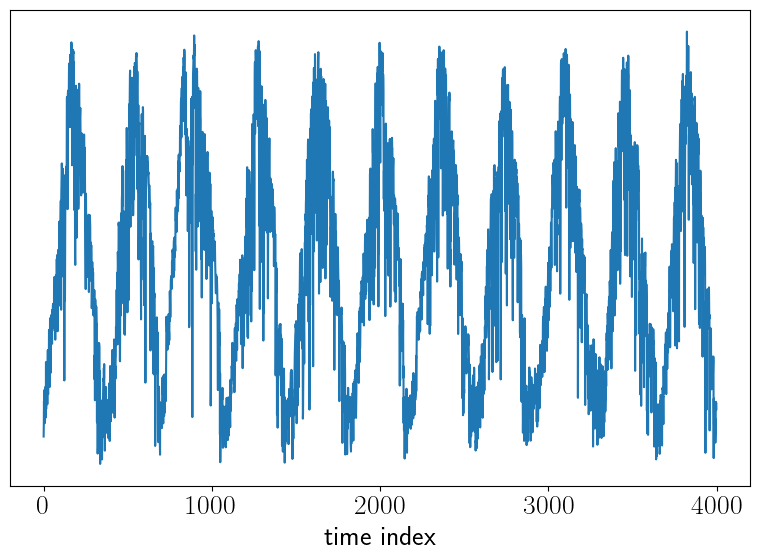

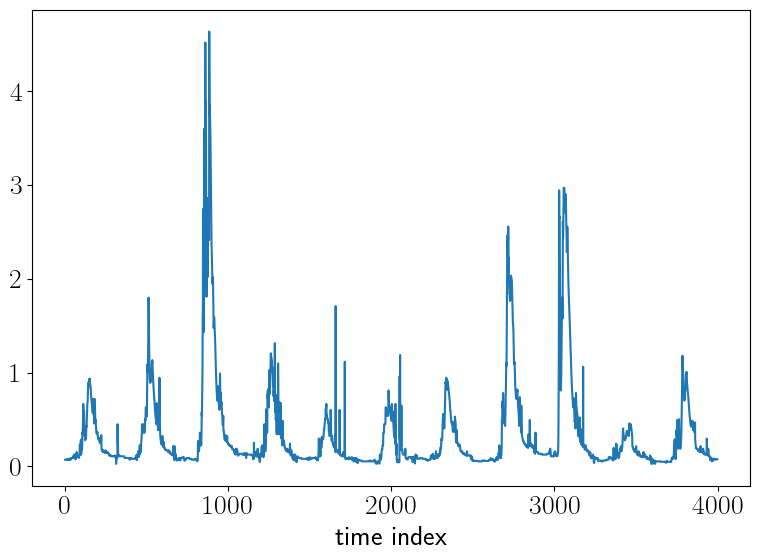

In [4]:
# Plot data dynamics
plt.figure(figsize=figsize)
plt.plot(range(n), X.norm(2,1))
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data_norm.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v)
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data.eps"))
plt.show()

In [5]:
# split in train and validation
split = 0.8
n_ = int(split * n)
i_train = i[:n_].float()
X_train = X[:n_].float()
v_train = v[:n_].float()
i_val = i[n_:].float()
X_val = X[n_:].float()
v_val = v[n_:].float()

### Reconstruct using LDDMD ###

Top dominant frequencies:
tensor([0.0028, 0.0055, 0.0005, 0.0023, 0.0033, 0.0010, 0.0082, 0.0038, 0.0018,
        0.0050, 0.0060, 0.0065, 0.0045, 0.0040, 0.0015, 0.0068, 0.0110, 0.0043,
        0.0013, 0.0095, 0.0070, 0.0088, 0.0078, 0.0093, 0.0073])


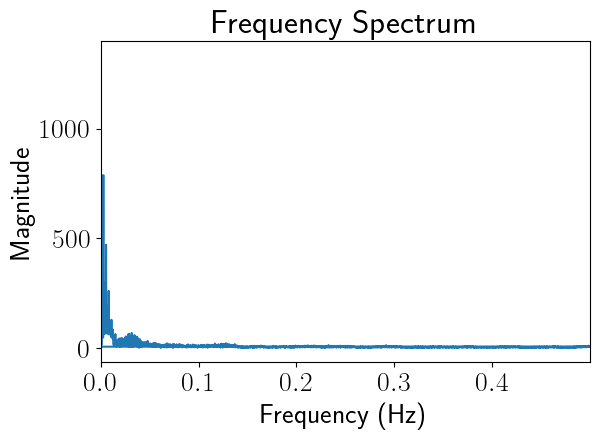

In [6]:
# Compute the FFT
fft_result = torch.fft.fft(v)

# Compute the frequency bins
n = len(i)
sample_rate = 1 / (dt * (i[1] - i[0]))  # Assuming uniform sampling
freqs = torch.fft.fftfreq(n, d=1/sample_rate)

# Compute the magnitude spectrum
magnitude_spectrum = torch.abs(fft_result)

# Find the dominant frequencies
dominant_freqs = freqs[torch.argsort(magnitude_spectrum, descending=True)]

# Print the top dominant frequencies
print("Top dominant frequencies:")
print(dominant_freqs[1:50:2].abs())

plt.plot(freqs, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum')
plt.xlim(0, freqs.max())  # Display only positive frequencies
plt.tight_layout()
plt.show()

In [7]:
# Construct data loader
class TimeSeriesDataset(Dataset):
    def __init__(self, i, x, v):
        self.i = i
        self.x = x
        self.v = v

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            self.i[idx,None],
            self.x[idx],
            self.v[idx,None]
        )

# Create the dataset
dataset = TimeSeriesDataset(i_train, X_train, v_train) 

# Create the DataLoader
batch_size = 256  # Adjust as needed
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Define additional neural network helpers
def create_flow_model(dim, n_flows, order):
    base_dist = distributions.StandardNormal(shape=[dim])
    transforms_list = []
    for _ in range(n_flows):
        transforms_list.append(PolynomialParityTransform(dim, order, parity=1))
    flow_transforms = transforms.CompositeTransform(transforms_list)
    return NFlowVectorDiffeomorphism(dim, flows.Flow(transform=flow_transforms, distribution=base_dist))

def create_feed_forward_model(dim_in, dim_out, n_layers, hidden_dim, order):
    if hidden_dim is None:
        hidden_dim = dim_in
    layers = []
    layers.append(nn.Linear(dim_in, hidden_dim))
    for _ in range(n_layers-1):
        layers.append(PolynomialActivation(hidden_dim, order))
        layers.append(nn.Linear(hidden_dim, hidden_dim))
    layers.append(PolynomialActivation(hidden_dim, order))
    layers.append(nn.Linear(hidden_dim, dim_out))
    return FeedForwardCoupling(dim_in, dim_out, nn.Sequential(*layers))

def create_dynamics_model(dim, dt, freqs, decays=None, init=None):
    assert dim % 2 == 0
    omegas = nn.Parameter(freqs)
    if decays is None:
        mus = torch.zeros(dim//2)
    else:
        mus = nn.Parameter(decays)
    if init is None:
        x0 = nn.Parameter(torch.zeros(dim))
    else:
        x0 = nn.Parameter(init)
    return StandardLinearDynamics(dim, dt, mus, omegas, x0)

def create_regression_model(dim_in, hidden_dim):
    layers = []
    layers.append(nn.Linear(dim_in, hidden_dim))
    layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, 1))
    
    return nn.Sequential(*layers)

In [9]:
# Initialize the models
data_dim = d
latent_dim = 10

n_latent_flows = 1
phi = create_flow_model(latent_dim, n_latent_flows, 2)

n_coupling_layers = 1
hidden_dim_f = 4 * d
f = create_feed_forward_model(data_dim, latent_dim, n_coupling_layers, hidden_dim_f, 2)

freqs = torch.tensor([dominant_freqs[2*i+1] for i in range(latent_dim//2)]).abs()
K = create_dynamics_model(latent_dim, dt, freqs)

dynamics_model = HybridLowerTriangularNonlinearDynamics(K, phi, f).to(device)

hidden_dim_g = 4
regression_model = create_regression_model(latent_dim, hidden_dim_g).to(device)

# Combine all parameters from different components
all_params = list(dynamics_model.parameters()) + list(regression_model.parameters())

# Create the optimizer
optimizer = optim.Adam(all_params, lr=1e-3)

In [10]:
def validate_and_plot(dynamics_model, regression_model, i, x, p, v, start_idx=0, end_idx=-1):
    # Forward pass to get predictions
    p_net = dynamics_model.forward(i, x)

    # Compute learned signal using the regression model
    v_net = regression_model(p_net).detach().cpu()

    # Create a figure with 3 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot learned latent dynamics
    ax1.scatter(p[:, 0].detach().cpu().numpy()[start_idx:end_idx], p[:, 1].detach().cpu().numpy()[start_idx:end_idx], label='Original')
    ax1.scatter(p_net[:, 0].detach().cpu().numpy()[start_idx:end_idx], p_net[:, 1].detach().cpu().numpy()[start_idx:end_idx], label='Learned')
    ax1.set_title('Learned Latent Dynamics')
    ax1.legend()

    # Plot learned signal
    ax2.plot(i.detach().cpu().numpy()[start_idx:end_idx], v.detach().cpu().numpy()[start_idx:end_idx], label='Original')
    ax2.plot(i.detach().cpu().numpy()[start_idx:end_idx], v_net.numpy()[start_idx:end_idx], label='Learned')
    ax2.set_title('Learned Signal')
    ax2.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
# Training loop
def train(dynamics_model, regression_model, train_loader, optimizer, n_epochs, f_weight=1., phi_weight=0.05):
    loss_progression = []
    for epoch in range(n_epochs):
        for i_batch, x_batch, v_batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            # Compute predictions
            p_batch_net = dynamics_model.forward(i_batch, x_batch)
            v_batch_net = regression_model(p_batch_net)

            # Compute data fidelity loss
            loss = ((v_batch - v_batch_net).abs()).mean() # l1 loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")
        # Save last loss of the epoch
        loss_progression.append(loss.item())
    return loss_progression

In [12]:
# Train the model
n_epochs = 2000
losses = train(dynamics_model, regression_model, train_loader, optimizer, n_epochs)

100%|██████████| 13/13 [00:00<00:00, 60.03it/s]


Epoch 1/2000, Loss: 0.3322


100%|██████████| 13/13 [00:00<00:00, 84.31it/s]


Epoch 2/2000, Loss: 0.2565


100%|██████████| 13/13 [00:00<00:00, 67.16it/s]


Epoch 3/2000, Loss: 0.2597


100%|██████████| 13/13 [00:00<00:00, 65.58it/s]


Epoch 4/2000, Loss: 0.2817


100%|██████████| 13/13 [00:00<00:00, 63.66it/s]


Epoch 5/2000, Loss: 0.2477


100%|██████████| 13/13 [00:00<00:00, 49.55it/s]


Epoch 6/2000, Loss: 0.2336


100%|██████████| 13/13 [00:00<00:00, 47.82it/s]


Epoch 7/2000, Loss: 0.1904


100%|██████████| 13/13 [00:00<00:00, 30.74it/s]


Epoch 8/2000, Loss: 0.1611


100%|██████████| 13/13 [00:00<00:00, 47.61it/s]


Epoch 9/2000, Loss: 0.1407


100%|██████████| 13/13 [00:00<00:00, 67.36it/s]


Epoch 10/2000, Loss: 0.2511


100%|██████████| 13/13 [00:00<00:00, 89.91it/s]


Epoch 11/2000, Loss: 0.1813


100%|██████████| 13/13 [00:00<00:00, 94.30it/s]


Epoch 12/2000, Loss: 0.2130


100%|██████████| 13/13 [00:00<00:00, 83.89it/s]


Epoch 13/2000, Loss: 0.1701


100%|██████████| 13/13 [00:00<00:00, 87.34it/s]


Epoch 14/2000, Loss: 0.2084


100%|██████████| 13/13 [00:00<00:00, 93.02it/s]


Epoch 15/2000, Loss: 0.2019


100%|██████████| 13/13 [00:00<00:00, 50.50it/s]


Epoch 16/2000, Loss: 0.2544


100%|██████████| 13/13 [00:00<00:00, 88.89it/s]


Epoch 17/2000, Loss: 0.2276


100%|██████████| 13/13 [00:00<00:00, 95.89it/s]


Epoch 18/2000, Loss: 0.2658


100%|██████████| 13/13 [00:00<00:00, 86.55it/s]


Epoch 19/2000, Loss: 0.2484


100%|██████████| 13/13 [00:00<00:00, 94.91it/s]


Epoch 20/2000, Loss: 0.1707


100%|██████████| 13/13 [00:00<00:00, 94.44it/s]


Epoch 21/2000, Loss: 0.2392


100%|██████████| 13/13 [00:00<00:00, 88.16it/s]


Epoch 22/2000, Loss: 0.1674


100%|██████████| 13/13 [00:00<00:00, 96.32it/s]


Epoch 23/2000, Loss: 0.1997


100%|██████████| 13/13 [00:00<00:00, 93.37it/s]


Epoch 24/2000, Loss: 0.1535


100%|██████████| 13/13 [00:00<00:00, 91.76it/s]


Epoch 25/2000, Loss: 0.2444


100%|██████████| 13/13 [00:00<00:00, 83.93it/s]


Epoch 26/2000, Loss: 0.1804


100%|██████████| 13/13 [00:00<00:00, 96.50it/s]


Epoch 27/2000, Loss: 0.2136


100%|██████████| 13/13 [00:00<00:00, 95.63it/s]


Epoch 28/2000, Loss: 0.2430


100%|██████████| 13/13 [00:00<00:00, 85.54it/s]


Epoch 29/2000, Loss: 0.1609


100%|██████████| 13/13 [00:00<00:00, 86.14it/s]


Epoch 30/2000, Loss: 0.1992


100%|██████████| 13/13 [00:00<00:00, 98.43it/s]


Epoch 31/2000, Loss: 0.1681


100%|██████████| 13/13 [00:00<00:00, 83.46it/s]


Epoch 32/2000, Loss: 0.1713


100%|██████████| 13/13 [00:00<00:00, 63.89it/s]


Epoch 33/2000, Loss: 0.1484


100%|██████████| 13/13 [00:00<00:00, 50.31it/s]


Epoch 34/2000, Loss: 0.2299


100%|██████████| 13/13 [00:00<00:00, 55.45it/s]


Epoch 35/2000, Loss: 0.1370


100%|██████████| 13/13 [00:00<00:00, 51.79it/s]


Epoch 36/2000, Loss: 0.2058


100%|██████████| 13/13 [00:00<00:00, 40.91it/s]


Epoch 37/2000, Loss: 0.2266


100%|██████████| 13/13 [00:00<00:00, 74.89it/s]


Epoch 38/2000, Loss: 0.1641


100%|██████████| 13/13 [00:00<00:00, 92.01it/s]


Epoch 39/2000, Loss: 0.2142


100%|██████████| 13/13 [00:00<00:00, 102.31it/s]


Epoch 40/2000, Loss: 0.1435


100%|██████████| 13/13 [00:00<00:00, 98.99it/s] 


Epoch 41/2000, Loss: 0.1367


100%|██████████| 13/13 [00:00<00:00, 80.30it/s]


Epoch 42/2000, Loss: 0.1811


100%|██████████| 13/13 [00:00<00:00, 66.43it/s]


Epoch 43/2000, Loss: 0.2272


100%|██████████| 13/13 [00:00<00:00, 67.30it/s]


Epoch 44/2000, Loss: 0.1327


100%|██████████| 13/13 [00:00<00:00, 71.78it/s]


Epoch 45/2000, Loss: 0.1653


100%|██████████| 13/13 [00:00<00:00, 80.58it/s]


Epoch 46/2000, Loss: 0.1610


100%|██████████| 13/13 [00:00<00:00, 34.59it/s]


Epoch 47/2000, Loss: 0.1841


100%|██████████| 13/13 [00:00<00:00, 73.23it/s]


Epoch 48/2000, Loss: 0.1930


100%|██████████| 13/13 [00:00<00:00, 64.40it/s]


Epoch 49/2000, Loss: 0.1601


100%|██████████| 13/13 [00:00<00:00, 73.20it/s]


Epoch 50/2000, Loss: 0.2228


100%|██████████| 13/13 [00:00<00:00, 87.29it/s]


Epoch 51/2000, Loss: 0.1462


100%|██████████| 13/13 [00:00<00:00, 90.48it/s]


Epoch 52/2000, Loss: 0.2652


100%|██████████| 13/13 [00:00<00:00, 83.48it/s]


Epoch 53/2000, Loss: 0.1476


100%|██████████| 13/13 [00:00<00:00, 70.25it/s]


Epoch 54/2000, Loss: 0.2051


100%|██████████| 13/13 [00:00<00:00, 78.58it/s]


Epoch 55/2000, Loss: 0.1665


100%|██████████| 13/13 [00:00<00:00, 79.36it/s]


Epoch 56/2000, Loss: 0.2848


100%|██████████| 13/13 [00:00<00:00, 76.89it/s]


Epoch 57/2000, Loss: 0.2137


100%|██████████| 13/13 [00:00<00:00, 79.57it/s]


Epoch 58/2000, Loss: 0.1894


100%|██████████| 13/13 [00:00<00:00, 75.13it/s]


Epoch 59/2000, Loss: 0.1306


100%|██████████| 13/13 [00:00<00:00, 80.20it/s]


Epoch 60/2000, Loss: 0.1106


100%|██████████| 13/13 [00:00<00:00, 74.26it/s]


Epoch 61/2000, Loss: 0.1511


100%|██████████| 13/13 [00:00<00:00, 78.63it/s]


Epoch 62/2000, Loss: 0.1098


100%|██████████| 13/13 [00:00<00:00, 78.51it/s]


Epoch 63/2000, Loss: 0.1562


100%|██████████| 13/13 [00:00<00:00, 74.14it/s]


Epoch 64/2000, Loss: 0.1236


100%|██████████| 13/13 [00:00<00:00, 72.41it/s]


Epoch 65/2000, Loss: 0.1379


100%|██████████| 13/13 [00:00<00:00, 38.64it/s]


Epoch 66/2000, Loss: 0.1998


100%|██████████| 13/13 [00:00<00:00, 86.82it/s]


Epoch 67/2000, Loss: 0.1171


100%|██████████| 13/13 [00:00<00:00, 64.12it/s]


Epoch 68/2000, Loss: 0.2148


100%|██████████| 13/13 [00:00<00:00, 67.85it/s]


Epoch 69/2000, Loss: 0.1514


100%|██████████| 13/13 [00:00<00:00, 60.65it/s]


Epoch 70/2000, Loss: 0.1603


100%|██████████| 13/13 [00:00<00:00, 72.08it/s]


Epoch 71/2000, Loss: 0.1588


100%|██████████| 13/13 [00:00<00:00, 77.38it/s]


Epoch 72/2000, Loss: 0.1492


100%|██████████| 13/13 [00:00<00:00, 89.73it/s]


Epoch 73/2000, Loss: 0.2037


100%|██████████| 13/13 [00:00<00:00, 88.60it/s]


Epoch 74/2000, Loss: 0.1482


100%|██████████| 13/13 [00:00<00:00, 90.84it/s]


Epoch 75/2000, Loss: 0.1967


100%|██████████| 13/13 [00:00<00:00, 90.37it/s]


Epoch 76/2000, Loss: 0.1713


100%|██████████| 13/13 [00:00<00:00, 90.78it/s]


Epoch 77/2000, Loss: 0.1548


100%|██████████| 13/13 [00:00<00:00, 59.36it/s]


Epoch 78/2000, Loss: 0.1184


100%|██████████| 13/13 [00:00<00:00, 76.43it/s]


Epoch 79/2000, Loss: 0.2051


100%|██████████| 13/13 [00:00<00:00, 82.71it/s]


Epoch 80/2000, Loss: 0.1350


100%|██████████| 13/13 [00:00<00:00, 74.03it/s]


Epoch 81/2000, Loss: 0.1314


100%|██████████| 13/13 [00:00<00:00, 79.61it/s]


Epoch 82/2000, Loss: 0.1514


100%|██████████| 13/13 [00:00<00:00, 90.38it/s]


Epoch 83/2000, Loss: 0.1605


100%|██████████| 13/13 [00:00<00:00, 86.53it/s]


Epoch 84/2000, Loss: 0.1336


100%|██████████| 13/13 [00:00<00:00, 86.35it/s]


Epoch 85/2000, Loss: 0.1349


100%|██████████| 13/13 [00:00<00:00, 78.05it/s]


Epoch 86/2000, Loss: 0.1518


100%|██████████| 13/13 [00:00<00:00, 84.58it/s]


Epoch 87/2000, Loss: 0.1566


100%|██████████| 13/13 [00:00<00:00, 84.37it/s]


Epoch 88/2000, Loss: 0.1279


100%|██████████| 13/13 [00:00<00:00, 89.67it/s]


Epoch 89/2000, Loss: 0.1350


100%|██████████| 13/13 [00:00<00:00, 88.95it/s]


Epoch 90/2000, Loss: 0.1351


100%|██████████| 13/13 [00:00<00:00, 57.59it/s]


Epoch 91/2000, Loss: 0.2194


100%|██████████| 13/13 [00:00<00:00, 53.32it/s]


Epoch 92/2000, Loss: 0.1312


100%|██████████| 13/13 [00:00<00:00, 89.92it/s]


Epoch 93/2000, Loss: 0.1533


100%|██████████| 13/13 [00:00<00:00, 87.64it/s]


Epoch 94/2000, Loss: 0.1467


100%|██████████| 13/13 [00:00<00:00, 91.45it/s]


Epoch 95/2000, Loss: 0.1597


100%|██████████| 13/13 [00:00<00:00, 85.50it/s]


Epoch 96/2000, Loss: 0.1705


100%|██████████| 13/13 [00:00<00:00, 88.49it/s]


Epoch 97/2000, Loss: 0.1926


100%|██████████| 13/13 [00:00<00:00, 89.39it/s]


Epoch 98/2000, Loss: 0.1596


100%|██████████| 13/13 [00:00<00:00, 86.67it/s]


Epoch 99/2000, Loss: 0.1959


100%|██████████| 13/13 [00:00<00:00, 81.41it/s]


Epoch 100/2000, Loss: 0.1690


100%|██████████| 13/13 [00:00<00:00, 85.91it/s]


Epoch 101/2000, Loss: 0.1398


100%|██████████| 13/13 [00:00<00:00, 87.87it/s]


Epoch 102/2000, Loss: 0.1596


100%|██████████| 13/13 [00:00<00:00, 88.01it/s]


Epoch 103/2000, Loss: 0.1236


100%|██████████| 13/13 [00:00<00:00, 84.61it/s]


Epoch 104/2000, Loss: 0.1432


100%|██████████| 13/13 [00:00<00:00, 79.73it/s]


Epoch 105/2000, Loss: 0.1126


100%|██████████| 13/13 [00:00<00:00, 63.80it/s]


Epoch 106/2000, Loss: 0.1324


100%|██████████| 13/13 [00:00<00:00, 88.19it/s]


Epoch 107/2000, Loss: 0.1684


100%|██████████| 13/13 [00:00<00:00, 91.92it/s]


Epoch 108/2000, Loss: 0.1045


100%|██████████| 13/13 [00:00<00:00, 91.47it/s]


Epoch 109/2000, Loss: 0.1431


100%|██████████| 13/13 [00:00<00:00, 84.36it/s]


Epoch 110/2000, Loss: 0.1109


100%|██████████| 13/13 [00:00<00:00, 89.98it/s]


Epoch 111/2000, Loss: 0.2574


100%|██████████| 13/13 [00:00<00:00, 88.47it/s]


Epoch 112/2000, Loss: 0.1277


100%|██████████| 13/13 [00:00<00:00, 89.44it/s]


Epoch 113/2000, Loss: 0.1847


100%|██████████| 13/13 [00:00<00:00, 92.27it/s]


Epoch 114/2000, Loss: 0.0916


100%|██████████| 13/13 [00:00<00:00, 91.28it/s]


Epoch 115/2000, Loss: 0.1191


100%|██████████| 13/13 [00:00<00:00, 86.93it/s]


Epoch 116/2000, Loss: 0.1362


100%|██████████| 13/13 [00:00<00:00, 87.62it/s]


Epoch 117/2000, Loss: 0.1393


100%|██████████| 13/13 [00:00<00:00, 86.96it/s]


Epoch 118/2000, Loss: 0.1296


100%|██████████| 13/13 [00:00<00:00, 81.33it/s]


Epoch 119/2000, Loss: 0.1738


100%|██████████| 13/13 [00:00<00:00, 77.26it/s]


Epoch 120/2000, Loss: 0.1230


100%|██████████| 13/13 [00:00<00:00, 57.78it/s]


Epoch 121/2000, Loss: 0.1485


100%|██████████| 13/13 [00:00<00:00, 70.84it/s]


Epoch 122/2000, Loss: 0.1280


100%|██████████| 13/13 [00:00<00:00, 88.51it/s]


Epoch 123/2000, Loss: 0.1498


100%|██████████| 13/13 [00:00<00:00, 81.01it/s]


Epoch 124/2000, Loss: 0.1511


100%|██████████| 13/13 [00:00<00:00, 82.41it/s]


Epoch 125/2000, Loss: 0.1366


100%|██████████| 13/13 [00:00<00:00, 73.39it/s]


Epoch 126/2000, Loss: 0.1333


100%|██████████| 13/13 [00:00<00:00, 69.63it/s]


Epoch 127/2000, Loss: 0.1749


100%|██████████| 13/13 [00:00<00:00, 84.20it/s]


Epoch 128/2000, Loss: 0.1803


100%|██████████| 13/13 [00:00<00:00, 74.79it/s]


Epoch 129/2000, Loss: 0.2229


100%|██████████| 13/13 [00:00<00:00, 89.26it/s]


Epoch 130/2000, Loss: 0.1451


100%|██████████| 13/13 [00:00<00:00, 76.53it/s]


Epoch 131/2000, Loss: 0.1129


100%|██████████| 13/13 [00:00<00:00, 77.18it/s]


Epoch 132/2000, Loss: 0.1968


100%|██████████| 13/13 [00:00<00:00, 73.47it/s]


Epoch 133/2000, Loss: 0.1100


100%|██████████| 13/13 [00:00<00:00, 52.48it/s]


Epoch 134/2000, Loss: 0.1165


100%|██████████| 13/13 [00:00<00:00, 74.44it/s]


Epoch 135/2000, Loss: 0.1158


100%|██████████| 13/13 [00:00<00:00, 80.04it/s]


Epoch 136/2000, Loss: 0.0996


100%|██████████| 13/13 [00:00<00:00, 50.55it/s]


Epoch 137/2000, Loss: 0.1394


100%|██████████| 13/13 [00:00<00:00, 67.13it/s]


Epoch 138/2000, Loss: 0.1648


100%|██████████| 13/13 [00:00<00:00, 66.19it/s]


Epoch 139/2000, Loss: 0.1272


100%|██████████| 13/13 [00:00<00:00, 63.33it/s]


Epoch 140/2000, Loss: 0.1261


100%|██████████| 13/13 [00:00<00:00, 67.75it/s]


Epoch 141/2000, Loss: 0.1402


100%|██████████| 13/13 [00:00<00:00, 63.48it/s]


Epoch 142/2000, Loss: 0.1517


100%|██████████| 13/13 [00:00<00:00, 36.52it/s]


Epoch 143/2000, Loss: 0.1536


100%|██████████| 13/13 [00:00<00:00, 58.58it/s]


Epoch 144/2000, Loss: 0.2272


100%|██████████| 13/13 [00:00<00:00, 70.99it/s]


Epoch 145/2000, Loss: 0.1421


100%|██████████| 13/13 [00:00<00:00, 51.81it/s]


Epoch 146/2000, Loss: 0.1533


100%|██████████| 13/13 [00:00<00:00, 57.40it/s]


Epoch 147/2000, Loss: 0.1508


100%|██████████| 13/13 [00:00<00:00, 71.52it/s]


Epoch 148/2000, Loss: 0.0966


100%|██████████| 13/13 [00:00<00:00, 48.75it/s]


Epoch 149/2000, Loss: 0.1387


100%|██████████| 13/13 [00:00<00:00, 65.08it/s]


Epoch 150/2000, Loss: 0.1523


100%|██████████| 13/13 [00:00<00:00, 78.17it/s]


Epoch 151/2000, Loss: 0.1708


100%|██████████| 13/13 [00:00<00:00, 63.69it/s]


Epoch 152/2000, Loss: 0.1413


100%|██████████| 13/13 [00:00<00:00, 80.22it/s]


Epoch 153/2000, Loss: 0.1161


100%|██████████| 13/13 [00:00<00:00, 76.32it/s]


Epoch 154/2000, Loss: 0.1513


100%|██████████| 13/13 [00:00<00:00, 88.97it/s]


Epoch 155/2000, Loss: 0.1533


100%|██████████| 13/13 [00:00<00:00, 90.43it/s]


Epoch 156/2000, Loss: 0.1472


100%|██████████| 13/13 [00:00<00:00, 88.99it/s]


Epoch 157/2000, Loss: 0.1088


100%|██████████| 13/13 [00:00<00:00, 68.95it/s]


Epoch 158/2000, Loss: 0.0985


100%|██████████| 13/13 [00:00<00:00, 74.97it/s]


Epoch 159/2000, Loss: 0.0994


100%|██████████| 13/13 [00:00<00:00, 86.49it/s]


Epoch 160/2000, Loss: 0.1259


100%|██████████| 13/13 [00:00<00:00, 81.40it/s]


Epoch 161/2000, Loss: 0.1904


100%|██████████| 13/13 [00:00<00:00, 87.30it/s]


Epoch 162/2000, Loss: 0.1559


100%|██████████| 13/13 [00:00<00:00, 89.00it/s]


Epoch 163/2000, Loss: 0.1439


100%|██████████| 13/13 [00:00<00:00, 89.40it/s]


Epoch 164/2000, Loss: 0.1743


100%|██████████| 13/13 [00:00<00:00, 56.98it/s]


Epoch 165/2000, Loss: 0.1381


100%|██████████| 13/13 [00:00<00:00, 71.72it/s]


Epoch 166/2000, Loss: 0.0851


100%|██████████| 13/13 [00:00<00:00, 45.97it/s]


Epoch 167/2000, Loss: 0.2052


100%|██████████| 13/13 [00:00<00:00, 34.75it/s]


Epoch 168/2000, Loss: 0.1175


100%|██████████| 13/13 [00:00<00:00, 57.40it/s]


Epoch 169/2000, Loss: 0.1265


100%|██████████| 13/13 [00:00<00:00, 91.04it/s]


Epoch 170/2000, Loss: 0.1697


100%|██████████| 13/13 [00:00<00:00, 94.93it/s]


Epoch 171/2000, Loss: 0.1303


100%|██████████| 13/13 [00:00<00:00, 90.12it/s]


Epoch 172/2000, Loss: 0.1429


100%|██████████| 13/13 [00:00<00:00, 94.56it/s]


Epoch 173/2000, Loss: 0.1180


100%|██████████| 13/13 [00:00<00:00, 100.39it/s]


Epoch 174/2000, Loss: 0.1660


100%|██████████| 13/13 [00:00<00:00, 86.68it/s]


Epoch 175/2000, Loss: 0.1023


100%|██████████| 13/13 [00:00<00:00, 95.66it/s]


Epoch 176/2000, Loss: 0.1793


100%|██████████| 13/13 [00:00<00:00, 100.01it/s]


Epoch 177/2000, Loss: 0.1666


100%|██████████| 13/13 [00:00<00:00, 89.01it/s]


Epoch 178/2000, Loss: 0.1698


100%|██████████| 13/13 [00:00<00:00, 91.13it/s]


Epoch 179/2000, Loss: 0.1390


100%|██████████| 13/13 [00:00<00:00, 97.84it/s]


Epoch 180/2000, Loss: 0.1491


100%|██████████| 13/13 [00:00<00:00, 82.54it/s]


Epoch 181/2000, Loss: 0.1097


100%|██████████| 13/13 [00:00<00:00, 104.05it/s]


Epoch 182/2000, Loss: 0.1349


100%|██████████| 13/13 [00:00<00:00, 99.23it/s]


Epoch 183/2000, Loss: 0.1223


100%|██████████| 13/13 [00:00<00:00, 104.32it/s]


Epoch 184/2000, Loss: 0.1261


100%|██████████| 13/13 [00:00<00:00, 105.08it/s]


Epoch 185/2000, Loss: 0.1339


100%|██████████| 13/13 [00:00<00:00, 105.63it/s]


Epoch 186/2000, Loss: 0.1565


100%|██████████| 13/13 [00:00<00:00, 104.76it/s]


Epoch 187/2000, Loss: 0.1037


100%|██████████| 13/13 [00:00<00:00, 102.31it/s]


Epoch 188/2000, Loss: 0.2042


100%|██████████| 13/13 [00:00<00:00, 70.07it/s]


Epoch 189/2000, Loss: 0.1479


100%|██████████| 13/13 [00:00<00:00, 85.34it/s]


Epoch 190/2000, Loss: 0.1089


100%|██████████| 13/13 [00:00<00:00, 90.94it/s]


Epoch 191/2000, Loss: 0.1831


100%|██████████| 13/13 [00:00<00:00, 78.95it/s]


Epoch 192/2000, Loss: 0.1441


100%|██████████| 13/13 [00:00<00:00, 90.98it/s]


Epoch 193/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 99.29it/s]


Epoch 194/2000, Loss: 0.2059


100%|██████████| 13/13 [00:00<00:00, 94.79it/s]


Epoch 195/2000, Loss: 0.0994


100%|██████████| 13/13 [00:00<00:00, 91.39it/s]


Epoch 196/2000, Loss: 0.1768


100%|██████████| 13/13 [00:00<00:00, 74.83it/s]


Epoch 197/2000, Loss: 0.1225


100%|██████████| 13/13 [00:00<00:00, 89.39it/s]


Epoch 198/2000, Loss: 0.1758


100%|██████████| 13/13 [00:00<00:00, 85.62it/s]


Epoch 199/2000, Loss: 0.1054


100%|██████████| 13/13 [00:00<00:00, 90.38it/s]


Epoch 200/2000, Loss: 0.1225


100%|██████████| 13/13 [00:00<00:00, 83.85it/s]


Epoch 201/2000, Loss: 0.1338


100%|██████████| 13/13 [00:00<00:00, 83.36it/s]


Epoch 202/2000, Loss: 0.1249


100%|██████████| 13/13 [00:00<00:00, 87.58it/s]


Epoch 203/2000, Loss: 0.1612


100%|██████████| 13/13 [00:00<00:00, 85.38it/s]


Epoch 204/2000, Loss: 0.1331


100%|██████████| 13/13 [00:00<00:00, 83.88it/s]


Epoch 205/2000, Loss: 0.1346


100%|██████████| 13/13 [00:00<00:00, 88.92it/s]


Epoch 206/2000, Loss: 0.1220


100%|██████████| 13/13 [00:00<00:00, 84.06it/s]


Epoch 207/2000, Loss: 0.1432


100%|██████████| 13/13 [00:00<00:00, 79.99it/s]


Epoch 208/2000, Loss: 0.1221


100%|██████████| 13/13 [00:00<00:00, 97.15it/s]


Epoch 209/2000, Loss: 0.1310


100%|██████████| 13/13 [00:00<00:00, 85.29it/s]


Epoch 210/2000, Loss: 0.0980


100%|██████████| 13/13 [00:00<00:00, 69.97it/s]


Epoch 211/2000, Loss: 0.1344


100%|██████████| 13/13 [00:00<00:00, 91.62it/s]


Epoch 212/2000, Loss: 0.1164


100%|██████████| 13/13 [00:00<00:00, 80.89it/s]


Epoch 213/2000, Loss: 0.1045


100%|██████████| 13/13 [00:00<00:00, 78.57it/s]


Epoch 214/2000, Loss: 0.1946


100%|██████████| 13/13 [00:00<00:00, 84.33it/s]


Epoch 215/2000, Loss: 0.1419


100%|██████████| 13/13 [00:00<00:00, 88.45it/s]


Epoch 216/2000, Loss: 0.1003


100%|██████████| 13/13 [00:00<00:00, 83.26it/s]


Epoch 217/2000, Loss: 0.1351


100%|██████████| 13/13 [00:00<00:00, 92.77it/s]


Epoch 218/2000, Loss: 0.1188


100%|██████████| 13/13 [00:00<00:00, 95.33it/s]


Epoch 219/2000, Loss: 0.1260


100%|██████████| 13/13 [00:00<00:00, 92.79it/s]


Epoch 220/2000, Loss: 0.1123


100%|██████████| 13/13 [00:00<00:00, 88.73it/s]


Epoch 221/2000, Loss: 0.1222


100%|██████████| 13/13 [00:00<00:00, 91.22it/s]


Epoch 222/2000, Loss: 0.1363


100%|██████████| 13/13 [00:00<00:00, 93.86it/s]


Epoch 223/2000, Loss: 0.1488


100%|██████████| 13/13 [00:00<00:00, 89.54it/s]


Epoch 224/2000, Loss: 0.1622


100%|██████████| 13/13 [00:00<00:00, 86.40it/s]


Epoch 225/2000, Loss: 0.1562


100%|██████████| 13/13 [00:00<00:00, 82.54it/s]


Epoch 226/2000, Loss: 0.1256


100%|██████████| 13/13 [00:00<00:00, 96.95it/s]


Epoch 227/2000, Loss: 0.1377


100%|██████████| 13/13 [00:00<00:00, 91.67it/s]


Epoch 228/2000, Loss: 0.1601


100%|██████████| 13/13 [00:00<00:00, 94.18it/s]


Epoch 229/2000, Loss: 0.1141


100%|██████████| 13/13 [00:00<00:00, 90.14it/s]


Epoch 230/2000, Loss: 0.0989


100%|██████████| 13/13 [00:00<00:00, 92.17it/s]


Epoch 231/2000, Loss: 0.1092


100%|██████████| 13/13 [00:00<00:00, 69.52it/s]


Epoch 232/2000, Loss: 0.1009


100%|██████████| 13/13 [00:00<00:00, 73.80it/s]


Epoch 233/2000, Loss: 0.1404


100%|██████████| 13/13 [00:00<00:00, 86.96it/s]


Epoch 234/2000, Loss: 0.1666


100%|██████████| 13/13 [00:00<00:00, 65.72it/s]


Epoch 235/2000, Loss: 0.1114


100%|██████████| 13/13 [00:00<00:00, 67.47it/s]


Epoch 236/2000, Loss: 0.0993


100%|██████████| 13/13 [00:00<00:00, 69.14it/s]


Epoch 237/2000, Loss: 0.1300


100%|██████████| 13/13 [00:00<00:00, 64.94it/s]


Epoch 238/2000, Loss: 0.1319


100%|██████████| 13/13 [00:00<00:00, 63.29it/s]


Epoch 239/2000, Loss: 0.1166


100%|██████████| 13/13 [00:00<00:00, 74.85it/s]


Epoch 240/2000, Loss: 0.1341


100%|██████████| 13/13 [00:00<00:00, 75.61it/s]


Epoch 241/2000, Loss: 0.1408


100%|██████████| 13/13 [00:00<00:00, 87.54it/s]


Epoch 242/2000, Loss: 0.1185


100%|██████████| 13/13 [00:00<00:00, 85.99it/s]


Epoch 243/2000, Loss: 0.1350


100%|██████████| 13/13 [00:00<00:00, 57.86it/s]


Epoch 244/2000, Loss: 0.1631


100%|██████████| 13/13 [00:00<00:00, 63.20it/s]


Epoch 245/2000, Loss: 0.1368


100%|██████████| 13/13 [00:00<00:00, 85.05it/s]


Epoch 246/2000, Loss: 0.1956


100%|██████████| 13/13 [00:00<00:00, 87.79it/s]


Epoch 247/2000, Loss: 0.1805


100%|██████████| 13/13 [00:00<00:00, 88.54it/s]


Epoch 248/2000, Loss: 0.1366


100%|██████████| 13/13 [00:00<00:00, 96.63it/s]


Epoch 249/2000, Loss: 0.0964


100%|██████████| 13/13 [00:00<00:00, 96.84it/s]


Epoch 250/2000, Loss: 0.1391


100%|██████████| 13/13 [00:00<00:00, 71.16it/s]


Epoch 251/2000, Loss: 0.1646


100%|██████████| 13/13 [00:00<00:00, 89.09it/s]


Epoch 252/2000, Loss: 0.1435


100%|██████████| 13/13 [00:00<00:00, 76.99it/s]


Epoch 253/2000, Loss: 0.1336


100%|██████████| 13/13 [00:00<00:00, 73.40it/s]


Epoch 254/2000, Loss: 0.0824


100%|██████████| 13/13 [00:00<00:00, 72.19it/s]


Epoch 255/2000, Loss: 0.1176


100%|██████████| 13/13 [00:00<00:00, 68.86it/s]


Epoch 256/2000, Loss: 0.1512


100%|██████████| 13/13 [00:00<00:00, 64.89it/s]


Epoch 257/2000, Loss: 0.1338


100%|██████████| 13/13 [00:00<00:00, 59.61it/s]


Epoch 258/2000, Loss: 0.1203


100%|██████████| 13/13 [00:00<00:00, 73.64it/s]


Epoch 259/2000, Loss: 0.1132


100%|██████████| 13/13 [00:00<00:00, 74.10it/s]


Epoch 260/2000, Loss: 0.1243


100%|██████████| 13/13 [00:00<00:00, 58.09it/s]


Epoch 261/2000, Loss: 0.1262


100%|██████████| 13/13 [00:00<00:00, 44.52it/s]


Epoch 262/2000, Loss: 0.1259


100%|██████████| 13/13 [00:00<00:00, 30.45it/s]


Epoch 263/2000, Loss: 0.0950


100%|██████████| 13/13 [00:00<00:00, 27.27it/s]


Epoch 264/2000, Loss: 0.1793


100%|██████████| 13/13 [00:00<00:00, 65.98it/s]


Epoch 265/2000, Loss: 0.1162


100%|██████████| 13/13 [00:00<00:00, 84.11it/s]


Epoch 266/2000, Loss: 0.0960


100%|██████████| 13/13 [00:00<00:00, 81.88it/s]


Epoch 267/2000, Loss: 0.1337


100%|██████████| 13/13 [00:00<00:00, 89.09it/s]


Epoch 268/2000, Loss: 0.1876


100%|██████████| 13/13 [00:00<00:00, 101.88it/s]


Epoch 269/2000, Loss: 0.1406


100%|██████████| 13/13 [00:00<00:00, 99.32it/s] 


Epoch 270/2000, Loss: 0.1299


100%|██████████| 13/13 [00:00<00:00, 96.45it/s]


Epoch 271/2000, Loss: 0.0669


100%|██████████| 13/13 [00:00<00:00, 87.19it/s]


Epoch 272/2000, Loss: 0.1301


100%|██████████| 13/13 [00:00<00:00, 91.43it/s]


Epoch 273/2000, Loss: 0.1184


100%|██████████| 13/13 [00:00<00:00, 92.22it/s]


Epoch 274/2000, Loss: 0.1386


100%|██████████| 13/13 [00:00<00:00, 91.27it/s]


Epoch 275/2000, Loss: 0.1470


100%|██████████| 13/13 [00:00<00:00, 90.95it/s]


Epoch 276/2000, Loss: 0.1234


100%|██████████| 13/13 [00:00<00:00, 98.29it/s]


Epoch 277/2000, Loss: 0.1320


100%|██████████| 13/13 [00:00<00:00, 65.11it/s]


Epoch 278/2000, Loss: 0.1021


100%|██████████| 13/13 [00:00<00:00, 70.10it/s]


Epoch 279/2000, Loss: 0.0944


100%|██████████| 13/13 [00:00<00:00, 87.97it/s]


Epoch 280/2000, Loss: 0.2014


100%|██████████| 13/13 [00:00<00:00, 71.63it/s]


Epoch 281/2000, Loss: 0.1421


100%|██████████| 13/13 [00:00<00:00, 36.45it/s]


Epoch 282/2000, Loss: 0.0981


100%|██████████| 13/13 [00:00<00:00, 45.23it/s]


Epoch 283/2000, Loss: 0.1075


100%|██████████| 13/13 [00:00<00:00, 74.68it/s]


Epoch 284/2000, Loss: 0.1128


100%|██████████| 13/13 [00:00<00:00, 63.15it/s]


Epoch 285/2000, Loss: 0.1031


100%|██████████| 13/13 [00:00<00:00, 38.85it/s]


Epoch 286/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 70.82it/s]


Epoch 287/2000, Loss: 0.0877


100%|██████████| 13/13 [00:00<00:00, 86.90it/s]


Epoch 288/2000, Loss: 0.1071


100%|██████████| 13/13 [00:00<00:00, 90.04it/s]


Epoch 289/2000, Loss: 0.1218


100%|██████████| 13/13 [00:00<00:00, 82.69it/s]


Epoch 290/2000, Loss: 0.1195


100%|██████████| 13/13 [00:00<00:00, 79.04it/s]


Epoch 291/2000, Loss: 0.1237


100%|██████████| 13/13 [00:00<00:00, 87.62it/s]


Epoch 292/2000, Loss: 0.1277


100%|██████████| 13/13 [00:00<00:00, 84.03it/s]


Epoch 293/2000, Loss: 0.1627


100%|██████████| 13/13 [00:00<00:00, 86.38it/s]


Epoch 294/2000, Loss: 0.1218


100%|██████████| 13/13 [00:00<00:00, 95.37it/s]


Epoch 295/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 95.92it/s]


Epoch 296/2000, Loss: 0.1465


100%|██████████| 13/13 [00:00<00:00, 99.04it/s]


Epoch 297/2000, Loss: 0.1281


100%|██████████| 13/13 [00:00<00:00, 100.65it/s]


Epoch 298/2000, Loss: 0.1742


100%|██████████| 13/13 [00:00<00:00, 85.13it/s]


Epoch 299/2000, Loss: 0.1372


100%|██████████| 13/13 [00:00<00:00, 88.75it/s]


Epoch 300/2000, Loss: 0.1652


100%|██████████| 13/13 [00:00<00:00, 91.98it/s]


Epoch 301/2000, Loss: 0.1260


100%|██████████| 13/13 [00:00<00:00, 87.92it/s]


Epoch 302/2000, Loss: 0.0746


100%|██████████| 13/13 [00:00<00:00, 83.95it/s]


Epoch 303/2000, Loss: 0.1817


100%|██████████| 13/13 [00:00<00:00, 96.77it/s]


Epoch 304/2000, Loss: 0.1319


100%|██████████| 13/13 [00:00<00:00, 77.04it/s]


Epoch 305/2000, Loss: 0.1220


100%|██████████| 13/13 [00:00<00:00, 82.25it/s]


Epoch 306/2000, Loss: 0.1055


100%|██████████| 13/13 [00:00<00:00, 93.74it/s]


Epoch 307/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 75.49it/s]


Epoch 308/2000, Loss: 0.1404


100%|██████████| 13/13 [00:00<00:00, 70.52it/s]


Epoch 309/2000, Loss: 0.1383


100%|██████████| 13/13 [00:00<00:00, 71.66it/s]


Epoch 310/2000, Loss: 0.1018


100%|██████████| 13/13 [00:00<00:00, 83.46it/s]


Epoch 311/2000, Loss: 0.1578


100%|██████████| 13/13 [00:00<00:00, 88.51it/s]


Epoch 312/2000, Loss: 0.1102


100%|██████████| 13/13 [00:00<00:00, 100.27it/s]


Epoch 313/2000, Loss: 0.0960


100%|██████████| 13/13 [00:00<00:00, 102.39it/s]


Epoch 314/2000, Loss: 0.1552


100%|██████████| 13/13 [00:00<00:00, 99.57it/s] 


Epoch 315/2000, Loss: 0.1563


100%|██████████| 13/13 [00:00<00:00, 92.66it/s]


Epoch 316/2000, Loss: 0.1217


100%|██████████| 13/13 [00:00<00:00, 42.51it/s]


Epoch 317/2000, Loss: 0.1233


100%|██████████| 13/13 [00:00<00:00, 67.27it/s]


Epoch 318/2000, Loss: 0.1011


100%|██████████| 13/13 [00:00<00:00, 82.84it/s]


Epoch 319/2000, Loss: 0.1236


100%|██████████| 13/13 [00:00<00:00, 38.93it/s]


Epoch 320/2000, Loss: 0.1482


100%|██████████| 13/13 [00:00<00:00, 89.60it/s]


Epoch 321/2000, Loss: 0.1385


100%|██████████| 13/13 [00:00<00:00, 78.33it/s]


Epoch 322/2000, Loss: 0.1302


100%|██████████| 13/13 [00:00<00:00, 57.03it/s]


Epoch 323/2000, Loss: 0.1259


100%|██████████| 13/13 [00:00<00:00, 64.90it/s]


Epoch 324/2000, Loss: 0.1891


100%|██████████| 13/13 [00:00<00:00, 72.01it/s]


Epoch 325/2000, Loss: 0.0886


100%|██████████| 13/13 [00:00<00:00, 77.75it/s]


Epoch 326/2000, Loss: 0.1477


100%|██████████| 13/13 [00:00<00:00, 67.84it/s]


Epoch 327/2000, Loss: 0.1149


100%|██████████| 13/13 [00:00<00:00, 68.98it/s]


Epoch 328/2000, Loss: 0.1054


100%|██████████| 13/13 [00:00<00:00, 72.83it/s]


Epoch 329/2000, Loss: 0.2015


100%|██████████| 13/13 [00:00<00:00, 50.16it/s]


Epoch 330/2000, Loss: 0.1706


100%|██████████| 13/13 [00:00<00:00, 91.47it/s]


Epoch 331/2000, Loss: 0.0925


100%|██████████| 13/13 [00:00<00:00, 91.10it/s]


Epoch 332/2000, Loss: 0.1261


100%|██████████| 13/13 [00:00<00:00, 94.27it/s]


Epoch 333/2000, Loss: 0.0873


100%|██████████| 13/13 [00:00<00:00, 96.19it/s]


Epoch 334/2000, Loss: 0.1081


100%|██████████| 13/13 [00:00<00:00, 90.69it/s]


Epoch 335/2000, Loss: 0.1400


100%|██████████| 13/13 [00:00<00:00, 62.41it/s]


Epoch 336/2000, Loss: 0.1322


100%|██████████| 13/13 [00:00<00:00, 71.00it/s]


Epoch 337/2000, Loss: 0.0850


100%|██████████| 13/13 [00:00<00:00, 57.45it/s]


Epoch 338/2000, Loss: 0.0971


100%|██████████| 13/13 [00:00<00:00, 69.35it/s]


Epoch 339/2000, Loss: 0.1223


100%|██████████| 13/13 [00:00<00:00, 69.76it/s]


Epoch 340/2000, Loss: 0.0885


100%|██████████| 13/13 [00:00<00:00, 77.55it/s]


Epoch 341/2000, Loss: 0.1550


100%|██████████| 13/13 [00:00<00:00, 70.70it/s]


Epoch 342/2000, Loss: 0.0756


100%|██████████| 13/13 [00:00<00:00, 92.50it/s]


Epoch 343/2000, Loss: 0.1316


100%|██████████| 13/13 [00:00<00:00, 88.17it/s]


Epoch 344/2000, Loss: 0.1456


100%|██████████| 13/13 [00:00<00:00, 100.50it/s]


Epoch 345/2000, Loss: 0.1229


100%|██████████| 13/13 [00:00<00:00, 96.07it/s]


Epoch 346/2000, Loss: 0.0855


100%|██████████| 13/13 [00:00<00:00, 90.81it/s]


Epoch 347/2000, Loss: 0.1443


100%|██████████| 13/13 [00:00<00:00, 96.97it/s]


Epoch 348/2000, Loss: 0.0871


100%|██████████| 13/13 [00:00<00:00, 62.85it/s]


Epoch 349/2000, Loss: 0.0997


100%|██████████| 13/13 [00:00<00:00, 93.15it/s]


Epoch 350/2000, Loss: 0.1090


100%|██████████| 13/13 [00:00<00:00, 85.85it/s]


Epoch 351/2000, Loss: 0.0932


100%|██████████| 13/13 [00:00<00:00, 86.91it/s]


Epoch 352/2000, Loss: 0.1280


100%|██████████| 13/13 [00:00<00:00, 82.53it/s]


Epoch 353/2000, Loss: 0.1166


100%|██████████| 13/13 [00:00<00:00, 87.67it/s]


Epoch 354/2000, Loss: 0.1202


100%|██████████| 13/13 [00:00<00:00, 84.82it/s]


Epoch 355/2000, Loss: 0.1270


100%|██████████| 13/13 [00:00<00:00, 94.07it/s]


Epoch 356/2000, Loss: 0.1281


100%|██████████| 13/13 [00:00<00:00, 95.22it/s]


Epoch 357/2000, Loss: 0.1537


100%|██████████| 13/13 [00:00<00:00, 99.20it/s]


Epoch 358/2000, Loss: 0.1093


100%|██████████| 13/13 [00:00<00:00, 96.31it/s]


Epoch 359/2000, Loss: 0.0969


100%|██████████| 13/13 [00:00<00:00, 97.86it/s]


Epoch 360/2000, Loss: 0.1493


100%|██████████| 13/13 [00:00<00:00, 93.03it/s]


Epoch 361/2000, Loss: 0.1280


100%|██████████| 13/13 [00:00<00:00, 84.83it/s]


Epoch 362/2000, Loss: 0.0817


100%|██████████| 13/13 [00:00<00:00, 91.79it/s]


Epoch 363/2000, Loss: 0.0851


100%|██████████| 13/13 [00:00<00:00, 85.89it/s]


Epoch 364/2000, Loss: 0.1763


100%|██████████| 13/13 [00:00<00:00, 89.34it/s]


Epoch 365/2000, Loss: 0.1360


100%|██████████| 13/13 [00:00<00:00, 87.95it/s]


Epoch 366/2000, Loss: 0.1239


100%|██████████| 13/13 [00:00<00:00, 81.00it/s]


Epoch 367/2000, Loss: 0.1124


100%|██████████| 13/13 [00:00<00:00, 85.52it/s]


Epoch 368/2000, Loss: 0.1432


100%|██████████| 13/13 [00:00<00:00, 49.86it/s]


Epoch 369/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 84.47it/s]


Epoch 370/2000, Loss: 0.1260


100%|██████████| 13/13 [00:00<00:00, 67.53it/s]


Epoch 371/2000, Loss: 0.0891


100%|██████████| 13/13 [00:00<00:00, 46.58it/s]


Epoch 372/2000, Loss: 0.0767


100%|██████████| 13/13 [00:00<00:00, 70.08it/s]


Epoch 373/2000, Loss: 0.1108


100%|██████████| 13/13 [00:00<00:00, 62.40it/s]


Epoch 374/2000, Loss: 0.1234


100%|██████████| 13/13 [00:00<00:00, 61.04it/s]


Epoch 375/2000, Loss: 0.1086


100%|██████████| 13/13 [00:00<00:00, 58.28it/s]


Epoch 376/2000, Loss: 0.1336


100%|██████████| 13/13 [00:00<00:00, 58.28it/s]


Epoch 377/2000, Loss: 0.1061


100%|██████████| 13/13 [00:00<00:00, 68.34it/s]


Epoch 378/2000, Loss: 0.1568


100%|██████████| 13/13 [00:00<00:00, 71.86it/s]


Epoch 379/2000, Loss: 0.1108


100%|██████████| 13/13 [00:00<00:00, 92.87it/s]


Epoch 380/2000, Loss: 0.1072


100%|██████████| 13/13 [00:00<00:00, 89.72it/s]


Epoch 381/2000, Loss: 0.0950


100%|██████████| 13/13 [00:00<00:00, 94.33it/s]


Epoch 382/2000, Loss: 0.1031


100%|██████████| 13/13 [00:00<00:00, 95.26it/s]


Epoch 383/2000, Loss: 0.1109


100%|██████████| 13/13 [00:00<00:00, 93.84it/s]


Epoch 384/2000, Loss: 0.1386


100%|██████████| 13/13 [00:00<00:00, 87.30it/s]


Epoch 385/2000, Loss: 0.0975


100%|██████████| 13/13 [00:00<00:00, 72.67it/s]


Epoch 386/2000, Loss: 0.1545


100%|██████████| 13/13 [00:00<00:00, 70.45it/s]


Epoch 387/2000, Loss: 0.1332


100%|██████████| 13/13 [00:00<00:00, 43.96it/s]


Epoch 388/2000, Loss: 0.1249


100%|██████████| 13/13 [00:00<00:00, 85.95it/s]


Epoch 389/2000, Loss: 0.0999


100%|██████████| 13/13 [00:00<00:00, 95.66it/s]


Epoch 390/2000, Loss: 0.1108


100%|██████████| 13/13 [00:00<00:00, 96.40it/s]


Epoch 391/2000, Loss: 0.1214


100%|██████████| 13/13 [00:00<00:00, 98.74it/s]


Epoch 392/2000, Loss: 0.1124


100%|██████████| 13/13 [00:00<00:00, 91.70it/s]


Epoch 393/2000, Loss: 0.0879


100%|██████████| 13/13 [00:00<00:00, 76.32it/s]


Epoch 394/2000, Loss: 0.1059


100%|██████████| 13/13 [00:00<00:00, 75.87it/s]


Epoch 395/2000, Loss: 0.0948


100%|██████████| 13/13 [00:00<00:00, 59.11it/s]


Epoch 396/2000, Loss: 0.1101


100%|██████████| 13/13 [00:00<00:00, 98.75it/s]


Epoch 397/2000, Loss: 0.1176


100%|██████████| 13/13 [00:00<00:00, 96.16it/s]


Epoch 398/2000, Loss: 0.0995


100%|██████████| 13/13 [00:00<00:00, 94.87it/s]


Epoch 399/2000, Loss: 0.0701


100%|██████████| 13/13 [00:00<00:00, 95.33it/s]


Epoch 400/2000, Loss: 0.1014


100%|██████████| 13/13 [00:00<00:00, 97.91it/s]


Epoch 401/2000, Loss: 0.1274


100%|██████████| 13/13 [00:00<00:00, 101.70it/s]


Epoch 402/2000, Loss: 0.1593


100%|██████████| 13/13 [00:00<00:00, 101.67it/s]


Epoch 403/2000, Loss: 0.1105


100%|██████████| 13/13 [00:00<00:00, 96.93it/s]


Epoch 404/2000, Loss: 0.1155


100%|██████████| 13/13 [00:00<00:00, 99.95it/s]


Epoch 405/2000, Loss: 0.1447


100%|██████████| 13/13 [00:00<00:00, 99.37it/s]


Epoch 406/2000, Loss: 0.0913


100%|██████████| 13/13 [00:00<00:00, 99.50it/s]


Epoch 407/2000, Loss: 0.1117


100%|██████████| 13/13 [00:00<00:00, 98.78it/s]


Epoch 408/2000, Loss: 0.1158


100%|██████████| 13/13 [00:00<00:00, 99.31it/s]


Epoch 409/2000, Loss: 0.0877


100%|██████████| 13/13 [00:00<00:00, 100.76it/s]


Epoch 410/2000, Loss: 0.0883


100%|██████████| 13/13 [00:00<00:00, 99.98it/s]


Epoch 411/2000, Loss: 0.1102


100%|██████████| 13/13 [00:00<00:00, 97.96it/s]


Epoch 412/2000, Loss: 0.1206


100%|██████████| 13/13 [00:00<00:00, 100.96it/s]


Epoch 413/2000, Loss: 0.1068


100%|██████████| 13/13 [00:00<00:00, 99.71it/s]


Epoch 414/2000, Loss: 0.1029


100%|██████████| 13/13 [00:00<00:00, 65.84it/s]


Epoch 415/2000, Loss: 0.1302


100%|██████████| 13/13 [00:00<00:00, 99.72it/s]


Epoch 416/2000, Loss: 0.1175


100%|██████████| 13/13 [00:00<00:00, 101.61it/s]


Epoch 417/2000, Loss: 0.1203


100%|██████████| 13/13 [00:00<00:00, 99.80it/s]


Epoch 418/2000, Loss: 0.1261


100%|██████████| 13/13 [00:00<00:00, 98.64it/s]


Epoch 419/2000, Loss: 0.1620


100%|██████████| 13/13 [00:00<00:00, 99.33it/s]


Epoch 420/2000, Loss: 0.1318


100%|██████████| 13/13 [00:00<00:00, 100.00it/s]


Epoch 421/2000, Loss: 0.1272


100%|██████████| 13/13 [00:00<00:00, 101.29it/s]


Epoch 422/2000, Loss: 0.0982


100%|██████████| 13/13 [00:00<00:00, 101.48it/s]


Epoch 423/2000, Loss: 0.1361


100%|██████████| 13/13 [00:00<00:00, 102.20it/s]


Epoch 424/2000, Loss: 0.1221


100%|██████████| 13/13 [00:00<00:00, 101.26it/s]


Epoch 425/2000, Loss: 0.1089


100%|██████████| 13/13 [00:00<00:00, 96.46it/s]


Epoch 426/2000, Loss: 0.1278


100%|██████████| 13/13 [00:00<00:00, 100.78it/s]


Epoch 427/2000, Loss: 0.1340


100%|██████████| 13/13 [00:00<00:00, 100.18it/s]


Epoch 428/2000, Loss: 0.1209


100%|██████████| 13/13 [00:00<00:00, 101.93it/s]


Epoch 429/2000, Loss: 0.1129


100%|██████████| 13/13 [00:00<00:00, 100.55it/s]


Epoch 430/2000, Loss: 0.1116


100%|██████████| 13/13 [00:00<00:00, 94.81it/s]


Epoch 431/2000, Loss: 0.1220


100%|██████████| 13/13 [00:00<00:00, 100.29it/s]


Epoch 432/2000, Loss: 0.1077


100%|██████████| 13/13 [00:00<00:00, 99.63it/s]


Epoch 433/2000, Loss: 0.1421


100%|██████████| 13/13 [00:00<00:00, 99.24it/s]


Epoch 434/2000, Loss: 0.1464


100%|██████████| 13/13 [00:00<00:00, 96.14it/s]


Epoch 435/2000, Loss: 0.1645


100%|██████████| 13/13 [00:00<00:00, 100.68it/s]


Epoch 436/2000, Loss: 0.1011


100%|██████████| 13/13 [00:00<00:00, 100.78it/s]


Epoch 437/2000, Loss: 0.1070


100%|██████████| 13/13 [00:00<00:00, 99.52it/s]


Epoch 438/2000, Loss: 0.1375


100%|██████████| 13/13 [00:00<00:00, 100.71it/s]


Epoch 439/2000, Loss: 0.1260


100%|██████████| 13/13 [00:00<00:00, 99.88it/s]


Epoch 440/2000, Loss: 0.1027


100%|██████████| 13/13 [00:00<00:00, 95.69it/s]


Epoch 441/2000, Loss: 0.1014


100%|██████████| 13/13 [00:00<00:00, 99.56it/s] 


Epoch 442/2000, Loss: 0.1373


100%|██████████| 13/13 [00:00<00:00, 99.43it/s]


Epoch 443/2000, Loss: 0.1466


100%|██████████| 13/13 [00:00<00:00, 99.73it/s]


Epoch 444/2000, Loss: 0.1180


100%|██████████| 13/13 [00:00<00:00, 98.89it/s]


Epoch 445/2000, Loss: 0.1152


100%|██████████| 13/13 [00:00<00:00, 66.16it/s]


Epoch 446/2000, Loss: 0.1059


100%|██████████| 13/13 [00:00<00:00, 100.11it/s]


Epoch 447/2000, Loss: 0.1102


100%|██████████| 13/13 [00:00<00:00, 99.49it/s]


Epoch 448/2000, Loss: 0.0968


100%|██████████| 13/13 [00:00<00:00, 97.52it/s]


Epoch 449/2000, Loss: 0.1015


100%|██████████| 13/13 [00:00<00:00, 100.68it/s]


Epoch 450/2000, Loss: 0.1383


100%|██████████| 13/13 [00:00<00:00, 101.51it/s]


Epoch 451/2000, Loss: 0.1279


100%|██████████| 13/13 [00:00<00:00, 100.88it/s]


Epoch 452/2000, Loss: 0.1182


100%|██████████| 13/13 [00:00<00:00, 99.63it/s]


Epoch 453/2000, Loss: 0.0985


100%|██████████| 13/13 [00:00<00:00, 101.90it/s]


Epoch 454/2000, Loss: 0.0962


100%|██████████| 13/13 [00:00<00:00, 101.01it/s]


Epoch 455/2000, Loss: 0.1138


100%|██████████| 13/13 [00:00<00:00, 102.03it/s]


Epoch 456/2000, Loss: 0.1309


100%|██████████| 13/13 [00:00<00:00, 100.42it/s]


Epoch 457/2000, Loss: 0.1321


100%|██████████| 13/13 [00:00<00:00, 99.72it/s]


Epoch 458/2000, Loss: 0.0522


100%|██████████| 13/13 [00:00<00:00, 97.30it/s]


Epoch 459/2000, Loss: 0.1151


100%|██████████| 13/13 [00:00<00:00, 100.05it/s]


Epoch 460/2000, Loss: 0.1264


100%|██████████| 13/13 [00:00<00:00, 101.38it/s]


Epoch 461/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 100.74it/s]


Epoch 462/2000, Loss: 0.1902


100%|██████████| 13/13 [00:00<00:00, 98.31it/s]


Epoch 463/2000, Loss: 0.1555


100%|██████████| 13/13 [00:00<00:00, 98.53it/s]


Epoch 464/2000, Loss: 0.0799


100%|██████████| 13/13 [00:00<00:00, 97.25it/s]


Epoch 465/2000, Loss: 0.0706


100%|██████████| 13/13 [00:00<00:00, 101.06it/s]


Epoch 466/2000, Loss: 0.1218


100%|██████████| 13/13 [00:00<00:00, 101.55it/s]


Epoch 467/2000, Loss: 0.1474


100%|██████████| 13/13 [00:00<00:00, 100.28it/s]


Epoch 468/2000, Loss: 0.1271


100%|██████████| 13/13 [00:00<00:00, 91.79it/s]


Epoch 469/2000, Loss: 0.0961


100%|██████████| 13/13 [00:00<00:00, 100.81it/s]


Epoch 470/2000, Loss: 0.1749


100%|██████████| 13/13 [00:00<00:00, 100.93it/s]


Epoch 471/2000, Loss: 0.1004


100%|██████████| 13/13 [00:00<00:00, 61.37it/s]


Epoch 472/2000, Loss: 0.1174


100%|██████████| 13/13 [00:00<00:00, 103.10it/s]


Epoch 473/2000, Loss: 0.0991


100%|██████████| 13/13 [00:00<00:00, 101.51it/s]


Epoch 474/2000, Loss: 0.1450


100%|██████████| 13/13 [00:00<00:00, 102.38it/s]


Epoch 475/2000, Loss: 0.0977


100%|██████████| 13/13 [00:00<00:00, 98.64it/s]


Epoch 476/2000, Loss: 0.1009


100%|██████████| 13/13 [00:00<00:00, 65.71it/s]


Epoch 477/2000, Loss: 0.1306


100%|██████████| 13/13 [00:00<00:00, 102.57it/s]


Epoch 478/2000, Loss: 0.0724


100%|██████████| 13/13 [00:00<00:00, 98.74it/s]


Epoch 479/2000, Loss: 0.1191


100%|██████████| 13/13 [00:00<00:00, 102.35it/s]


Epoch 480/2000, Loss: 0.0713


100%|██████████| 13/13 [00:00<00:00, 102.71it/s]


Epoch 481/2000, Loss: 0.1326


100%|██████████| 13/13 [00:00<00:00, 100.83it/s]


Epoch 482/2000, Loss: 0.1489


100%|██████████| 13/13 [00:00<00:00, 101.58it/s]


Epoch 483/2000, Loss: 0.0905


100%|██████████| 13/13 [00:00<00:00, 102.24it/s]


Epoch 484/2000, Loss: 0.1269


100%|██████████| 13/13 [00:00<00:00, 100.73it/s]


Epoch 485/2000, Loss: 0.1000


100%|██████████| 13/13 [00:00<00:00, 99.58it/s]


Epoch 486/2000, Loss: 0.1078


100%|██████████| 13/13 [00:00<00:00, 101.90it/s]


Epoch 487/2000, Loss: 0.1172


100%|██████████| 13/13 [00:00<00:00, 99.92it/s]


Epoch 488/2000, Loss: 0.0889


100%|██████████| 13/13 [00:00<00:00, 101.36it/s]


Epoch 489/2000, Loss: 0.1245


100%|██████████| 13/13 [00:00<00:00, 98.72it/s]


Epoch 490/2000, Loss: 0.0980


100%|██████████| 13/13 [00:00<00:00, 102.07it/s]


Epoch 491/2000, Loss: 0.1228


100%|██████████| 13/13 [00:00<00:00, 100.50it/s]


Epoch 492/2000, Loss: 0.1478


100%|██████████| 13/13 [00:00<00:00, 103.84it/s]


Epoch 493/2000, Loss: 0.1215


100%|██████████| 13/13 [00:00<00:00, 101.27it/s]


Epoch 494/2000, Loss: 0.1347


100%|██████████| 13/13 [00:00<00:00, 98.13it/s]


Epoch 495/2000, Loss: 0.1121


100%|██████████| 13/13 [00:00<00:00, 101.86it/s]


Epoch 496/2000, Loss: 0.0930


100%|██████████| 13/13 [00:00<00:00, 101.88it/s]


Epoch 497/2000, Loss: 0.1226


100%|██████████| 13/13 [00:00<00:00, 101.35it/s]


Epoch 498/2000, Loss: 0.1081


100%|██████████| 13/13 [00:00<00:00, 103.02it/s]


Epoch 499/2000, Loss: 0.1190


100%|██████████| 13/13 [00:00<00:00, 100.88it/s]


Epoch 500/2000, Loss: 0.1210


100%|██████████| 13/13 [00:00<00:00, 101.27it/s]


Epoch 501/2000, Loss: 0.0979


100%|██████████| 13/13 [00:00<00:00, 102.97it/s]


Epoch 502/2000, Loss: 0.1185


100%|██████████| 13/13 [00:00<00:00, 102.35it/s]


Epoch 503/2000, Loss: 0.0848


100%|██████████| 13/13 [00:00<00:00, 96.83it/s]


Epoch 504/2000, Loss: 0.1024


100%|██████████| 13/13 [00:00<00:00, 67.13it/s]


Epoch 505/2000, Loss: 0.1114


100%|██████████| 13/13 [00:00<00:00, 94.17it/s]


Epoch 506/2000, Loss: 0.1370


100%|██████████| 13/13 [00:00<00:00, 96.37it/s]


Epoch 507/2000, Loss: 0.1446


100%|██████████| 13/13 [00:00<00:00, 90.44it/s]


Epoch 508/2000, Loss: 0.1000


100%|██████████| 13/13 [00:00<00:00, 96.48it/s]


Epoch 509/2000, Loss: 0.1242


100%|██████████| 13/13 [00:00<00:00, 87.06it/s]


Epoch 510/2000, Loss: 0.0939


100%|██████████| 13/13 [00:00<00:00, 81.54it/s]


Epoch 511/2000, Loss: 0.1023


100%|██████████| 13/13 [00:00<00:00, 90.22it/s]


Epoch 512/2000, Loss: 0.1319


100%|██████████| 13/13 [00:00<00:00, 96.27it/s]


Epoch 513/2000, Loss: 0.1072


100%|██████████| 13/13 [00:00<00:00, 99.30it/s]


Epoch 514/2000, Loss: 0.1545


100%|██████████| 13/13 [00:00<00:00, 100.97it/s]


Epoch 515/2000, Loss: 0.1716


100%|██████████| 13/13 [00:00<00:00, 99.88it/s]


Epoch 516/2000, Loss: 0.1035


100%|██████████| 13/13 [00:00<00:00, 101.12it/s]


Epoch 517/2000, Loss: 0.0977


100%|██████████| 13/13 [00:00<00:00, 97.52it/s]


Epoch 518/2000, Loss: 0.1348


100%|██████████| 13/13 [00:00<00:00, 100.02it/s]


Epoch 519/2000, Loss: 0.1392


100%|██████████| 13/13 [00:00<00:00, 100.98it/s]


Epoch 520/2000, Loss: 0.1713


100%|██████████| 13/13 [00:00<00:00, 100.01it/s]


Epoch 521/2000, Loss: 0.1171


100%|██████████| 13/13 [00:00<00:00, 100.54it/s]


Epoch 522/2000, Loss: 0.1381


100%|██████████| 13/13 [00:00<00:00, 95.63it/s]


Epoch 523/2000, Loss: 0.1138


100%|██████████| 13/13 [00:00<00:00, 99.18it/s]


Epoch 524/2000, Loss: 0.1375


100%|██████████| 13/13 [00:00<00:00, 99.07it/s]


Epoch 525/2000, Loss: 0.1833


100%|██████████| 13/13 [00:00<00:00, 94.88it/s]


Epoch 526/2000, Loss: 0.1492


100%|██████████| 13/13 [00:00<00:00, 97.47it/s]


Epoch 527/2000, Loss: 0.1255


100%|██████████| 13/13 [00:00<00:00, 96.33it/s]


Epoch 528/2000, Loss: 0.1167


100%|██████████| 13/13 [00:00<00:00, 101.13it/s]


Epoch 529/2000, Loss: 0.1001


100%|██████████| 13/13 [00:00<00:00, 74.91it/s]


Epoch 530/2000, Loss: 0.1125


100%|██████████| 13/13 [00:00<00:00, 71.95it/s]


Epoch 531/2000, Loss: 0.1328


100%|██████████| 13/13 [00:00<00:00, 94.65it/s]


Epoch 532/2000, Loss: 0.1427


100%|██████████| 13/13 [00:00<00:00, 100.86it/s]


Epoch 533/2000, Loss: 0.0676


100%|██████████| 13/13 [00:00<00:00, 61.37it/s]


Epoch 534/2000, Loss: 0.1397


100%|██████████| 13/13 [00:00<00:00, 94.67it/s]


Epoch 535/2000, Loss: 0.1411


100%|██████████| 13/13 [00:00<00:00, 90.86it/s]


Epoch 536/2000, Loss: 0.1005


100%|██████████| 13/13 [00:00<00:00, 78.67it/s]


Epoch 537/2000, Loss: 0.1042


100%|██████████| 13/13 [00:00<00:00, 90.00it/s]


Epoch 538/2000, Loss: 0.1413


100%|██████████| 13/13 [00:00<00:00, 91.91it/s]


Epoch 539/2000, Loss: 0.0988


100%|██████████| 13/13 [00:00<00:00, 89.08it/s]


Epoch 540/2000, Loss: 0.1085


100%|██████████| 13/13 [00:00<00:00, 91.94it/s]


Epoch 541/2000, Loss: 0.1001


100%|██████████| 13/13 [00:00<00:00, 92.47it/s]


Epoch 542/2000, Loss: 0.1420


100%|██████████| 13/13 [00:00<00:00, 79.44it/s]


Epoch 543/2000, Loss: 0.1511


100%|██████████| 13/13 [00:00<00:00, 84.84it/s]


Epoch 544/2000, Loss: 0.1015


100%|██████████| 13/13 [00:00<00:00, 73.30it/s]


Epoch 545/2000, Loss: 0.0953


100%|██████████| 13/13 [00:00<00:00, 75.42it/s]


Epoch 546/2000, Loss: 0.1116


100%|██████████| 13/13 [00:00<00:00, 98.24it/s]


Epoch 547/2000, Loss: 0.1369


100%|██████████| 13/13 [00:00<00:00, 101.10it/s]


Epoch 548/2000, Loss: 0.1834


100%|██████████| 13/13 [00:00<00:00, 59.94it/s]


Epoch 549/2000, Loss: 0.1302


100%|██████████| 13/13 [00:00<00:00, 99.09it/s]


Epoch 550/2000, Loss: 0.0866


100%|██████████| 13/13 [00:00<00:00, 102.07it/s]


Epoch 551/2000, Loss: 0.1075


100%|██████████| 13/13 [00:00<00:00, 100.71it/s]


Epoch 552/2000, Loss: 0.1410


100%|██████████| 13/13 [00:00<00:00, 101.89it/s]


Epoch 553/2000, Loss: 0.0946


100%|██████████| 13/13 [00:00<00:00, 98.01it/s]


Epoch 554/2000, Loss: 0.1057


100%|██████████| 13/13 [00:00<00:00, 67.36it/s]


Epoch 555/2000, Loss: 0.1564


100%|██████████| 13/13 [00:00<00:00, 97.43it/s]


Epoch 556/2000, Loss: 0.1048


100%|██████████| 13/13 [00:00<00:00, 99.07it/s]


Epoch 557/2000, Loss: 0.1089


100%|██████████| 13/13 [00:00<00:00, 93.28it/s]


Epoch 558/2000, Loss: 0.1149


100%|██████████| 13/13 [00:00<00:00, 94.45it/s]


Epoch 559/2000, Loss: 0.1081


100%|██████████| 13/13 [00:00<00:00, 96.81it/s]


Epoch 560/2000, Loss: 0.1766


100%|██████████| 13/13 [00:00<00:00, 98.10it/s]


Epoch 561/2000, Loss: 0.1160


100%|██████████| 13/13 [00:00<00:00, 97.66it/s]


Epoch 562/2000, Loss: 0.0986


100%|██████████| 13/13 [00:00<00:00, 99.61it/s]


Epoch 563/2000, Loss: 0.1111


100%|██████████| 13/13 [00:00<00:00, 103.49it/s]


Epoch 564/2000, Loss: 0.1228


100%|██████████| 13/13 [00:00<00:00, 103.37it/s]


Epoch 565/2000, Loss: 0.1060


100%|██████████| 13/13 [00:00<00:00, 101.57it/s]


Epoch 566/2000, Loss: 0.1223


100%|██████████| 13/13 [00:00<00:00, 101.55it/s]


Epoch 567/2000, Loss: 0.1421


100%|██████████| 13/13 [00:00<00:00, 100.29it/s]


Epoch 568/2000, Loss: 0.1334


100%|██████████| 13/13 [00:00<00:00, 98.10it/s]


Epoch 569/2000, Loss: 0.1056


100%|██████████| 13/13 [00:00<00:00, 100.11it/s]


Epoch 570/2000, Loss: 0.1203


100%|██████████| 13/13 [00:00<00:00, 99.45it/s]


Epoch 571/2000, Loss: 0.0943


100%|██████████| 13/13 [00:00<00:00, 97.87it/s]


Epoch 572/2000, Loss: 0.0965


100%|██████████| 13/13 [00:00<00:00, 96.42it/s]


Epoch 573/2000, Loss: 0.1248


100%|██████████| 13/13 [00:00<00:00, 97.50it/s]


Epoch 574/2000, Loss: 0.2148


100%|██████████| 13/13 [00:00<00:00, 97.61it/s]


Epoch 575/2000, Loss: 0.1332


100%|██████████| 13/13 [00:00<00:00, 98.97it/s]


Epoch 576/2000, Loss: 0.1042


100%|██████████| 13/13 [00:00<00:00, 99.93it/s]


Epoch 577/2000, Loss: 0.1114


100%|██████████| 13/13 [00:00<00:00, 99.48it/s]


Epoch 578/2000, Loss: 0.1106


100%|██████████| 13/13 [00:00<00:00, 99.52it/s]


Epoch 579/2000, Loss: 0.0894


100%|██████████| 13/13 [00:00<00:00, 99.15it/s]


Epoch 580/2000, Loss: 0.1364


100%|██████████| 13/13 [00:00<00:00, 93.04it/s]


Epoch 581/2000, Loss: 0.1406


100%|██████████| 13/13 [00:00<00:00, 59.70it/s]


Epoch 582/2000, Loss: 0.0802


100%|██████████| 13/13 [00:00<00:00, 86.58it/s]


Epoch 583/2000, Loss: 0.0836


100%|██████████| 13/13 [00:00<00:00, 97.76it/s]


Epoch 584/2000, Loss: 0.1217


100%|██████████| 13/13 [00:00<00:00, 87.66it/s]


Epoch 585/2000, Loss: 0.1140


100%|██████████| 13/13 [00:00<00:00, 83.91it/s]


Epoch 586/2000, Loss: 0.0918


100%|██████████| 13/13 [00:00<00:00, 82.74it/s]


Epoch 587/2000, Loss: 0.0818


100%|██████████| 13/13 [00:00<00:00, 94.16it/s]


Epoch 588/2000, Loss: 0.1387


100%|██████████| 13/13 [00:00<00:00, 93.81it/s]


Epoch 589/2000, Loss: 0.1078


100%|██████████| 13/13 [00:00<00:00, 89.39it/s]


Epoch 590/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 91.99it/s]


Epoch 591/2000, Loss: 0.1114


100%|██████████| 13/13 [00:00<00:00, 86.14it/s]


Epoch 592/2000, Loss: 0.1171


100%|██████████| 13/13 [00:00<00:00, 81.67it/s]


Epoch 593/2000, Loss: 0.0805


100%|██████████| 13/13 [00:00<00:00, 84.82it/s]


Epoch 594/2000, Loss: 0.1069


100%|██████████| 13/13 [00:00<00:00, 88.87it/s]


Epoch 595/2000, Loss: 0.1189


100%|██████████| 13/13 [00:00<00:00, 55.44it/s]


Epoch 596/2000, Loss: 0.1660


100%|██████████| 13/13 [00:00<00:00, 99.59it/s]


Epoch 597/2000, Loss: 0.0600


100%|██████████| 13/13 [00:00<00:00, 101.29it/s]


Epoch 598/2000, Loss: 0.0865


100%|██████████| 13/13 [00:00<00:00, 99.41it/s]


Epoch 599/2000, Loss: 0.1514


100%|██████████| 13/13 [00:00<00:00, 99.98it/s] 


Epoch 600/2000, Loss: 0.1125


100%|██████████| 13/13 [00:00<00:00, 99.47it/s]


Epoch 601/2000, Loss: 0.0723


100%|██████████| 13/13 [00:00<00:00, 99.59it/s] 


Epoch 602/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 102.06it/s]


Epoch 603/2000, Loss: 0.0978


100%|██████████| 13/13 [00:00<00:00, 102.52it/s]


Epoch 604/2000, Loss: 0.0985


100%|██████████| 13/13 [00:00<00:00, 98.68it/s]


Epoch 605/2000, Loss: 0.0863


100%|██████████| 13/13 [00:00<00:00, 101.83it/s]


Epoch 606/2000, Loss: 0.1107


100%|██████████| 13/13 [00:00<00:00, 97.30it/s]


Epoch 607/2000, Loss: 0.1558


100%|██████████| 13/13 [00:00<00:00, 98.79it/s]


Epoch 608/2000, Loss: 0.1215


100%|██████████| 13/13 [00:00<00:00, 97.99it/s]


Epoch 609/2000, Loss: 0.1168


100%|██████████| 13/13 [00:00<00:00, 98.63it/s]


Epoch 610/2000, Loss: 0.1182


100%|██████████| 13/13 [00:00<00:00, 98.14it/s]


Epoch 611/2000, Loss: 0.1486


100%|██████████| 13/13 [00:00<00:00, 99.42it/s]


Epoch 612/2000, Loss: 0.1309


100%|██████████| 13/13 [00:00<00:00, 101.63it/s]


Epoch 613/2000, Loss: 0.1180


100%|██████████| 13/13 [00:00<00:00, 100.32it/s]


Epoch 614/2000, Loss: 0.1298


100%|██████████| 13/13 [00:00<00:00, 67.02it/s]


Epoch 615/2000, Loss: 0.1279


100%|██████████| 13/13 [00:00<00:00, 98.73it/s]


Epoch 616/2000, Loss: 0.1412


100%|██████████| 13/13 [00:00<00:00, 98.83it/s]


Epoch 617/2000, Loss: 0.1347


100%|██████████| 13/13 [00:00<00:00, 100.70it/s]


Epoch 618/2000, Loss: 0.1233


100%|██████████| 13/13 [00:00<00:00, 99.71it/s]


Epoch 619/2000, Loss: 0.1001


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 620/2000, Loss: 0.1464


100%|██████████| 13/13 [00:00<00:00, 100.29it/s]


Epoch 621/2000, Loss: 0.2027


100%|██████████| 13/13 [00:00<00:00, 100.51it/s]


Epoch 622/2000, Loss: 0.0968


100%|██████████| 13/13 [00:00<00:00, 100.24it/s]


Epoch 623/2000, Loss: 0.1100


100%|██████████| 13/13 [00:00<00:00, 98.43it/s]


Epoch 624/2000, Loss: 0.1038


100%|██████████| 13/13 [00:00<00:00, 100.91it/s]


Epoch 625/2000, Loss: 0.0981


100%|██████████| 13/13 [00:00<00:00, 59.31it/s]


Epoch 626/2000, Loss: 0.1002


100%|██████████| 13/13 [00:00<00:00, 103.50it/s]


Epoch 627/2000, Loss: 0.1342


100%|██████████| 13/13 [00:00<00:00, 97.28it/s]


Epoch 628/2000, Loss: 0.0880


100%|██████████| 13/13 [00:00<00:00, 101.12it/s]


Epoch 629/2000, Loss: 0.1253


100%|██████████| 13/13 [00:00<00:00, 100.73it/s]


Epoch 630/2000, Loss: 0.1052


100%|██████████| 13/13 [00:00<00:00, 100.77it/s]


Epoch 631/2000, Loss: 0.0773


100%|██████████| 13/13 [00:00<00:00, 101.82it/s]


Epoch 632/2000, Loss: 0.1191


100%|██████████| 13/13 [00:00<00:00, 97.40it/s]


Epoch 633/2000, Loss: 0.1073


100%|██████████| 13/13 [00:00<00:00, 65.68it/s]


Epoch 634/2000, Loss: 0.1425


100%|██████████| 13/13 [00:00<00:00, 98.99it/s]


Epoch 635/2000, Loss: 0.1200


100%|██████████| 13/13 [00:00<00:00, 100.27it/s]


Epoch 636/2000, Loss: 0.1130


100%|██████████| 13/13 [00:00<00:00, 100.49it/s]


Epoch 637/2000, Loss: 0.1092


100%|██████████| 13/13 [00:00<00:00, 102.36it/s]


Epoch 638/2000, Loss: 0.1410


100%|██████████| 13/13 [00:00<00:00, 99.37it/s]


Epoch 639/2000, Loss: 0.0946


100%|██████████| 13/13 [00:00<00:00, 96.36it/s]


Epoch 640/2000, Loss: 0.1193


100%|██████████| 13/13 [00:00<00:00, 99.90it/s]


Epoch 641/2000, Loss: 0.0997


100%|██████████| 13/13 [00:00<00:00, 97.24it/s]


Epoch 642/2000, Loss: 0.1089


100%|██████████| 13/13 [00:00<00:00, 101.40it/s]


Epoch 643/2000, Loss: 0.1300


100%|██████████| 13/13 [00:00<00:00, 101.03it/s]


Epoch 644/2000, Loss: 0.1756


100%|██████████| 13/13 [00:00<00:00, 102.62it/s]


Epoch 645/2000, Loss: 0.1347


100%|██████████| 13/13 [00:00<00:00, 99.29it/s]


Epoch 646/2000, Loss: 0.1193


100%|██████████| 13/13 [00:00<00:00, 100.18it/s]


Epoch 647/2000, Loss: 0.1308


100%|██████████| 13/13 [00:00<00:00, 98.63it/s]


Epoch 648/2000, Loss: 0.1783


100%|██████████| 13/13 [00:00<00:00, 101.27it/s]


Epoch 649/2000, Loss: 0.1217


100%|██████████| 13/13 [00:00<00:00, 98.77it/s]


Epoch 650/2000, Loss: 0.0991


100%|██████████| 13/13 [00:00<00:00, 100.91it/s]


Epoch 651/2000, Loss: 0.1180


100%|██████████| 13/13 [00:00<00:00, 97.17it/s]


Epoch 652/2000, Loss: 0.1001


100%|██████████| 13/13 [00:00<00:00, 92.85it/s]


Epoch 653/2000, Loss: 0.1003


100%|██████████| 13/13 [00:00<00:00, 68.28it/s] 


Epoch 654/2000, Loss: 0.1113


100%|██████████| 13/13 [00:00<00:00, 91.85it/s]


Epoch 655/2000, Loss: 0.1212


100%|██████████| 13/13 [00:00<00:00, 95.69it/s]


Epoch 656/2000, Loss: 0.1047


100%|██████████| 13/13 [00:00<00:00, 103.14it/s]


Epoch 657/2000, Loss: 0.1405


100%|██████████| 13/13 [00:00<00:00, 100.54it/s]


Epoch 658/2000, Loss: 0.0832


100%|██████████| 13/13 [00:00<00:00, 99.70it/s] 


Epoch 659/2000, Loss: 0.1177


100%|██████████| 13/13 [00:00<00:00, 101.67it/s]


Epoch 660/2000, Loss: 0.0952


100%|██████████| 13/13 [00:00<00:00, 101.11it/s]


Epoch 661/2000, Loss: 0.1122


100%|██████████| 13/13 [00:00<00:00, 99.86it/s]


Epoch 662/2000, Loss: 0.1369


100%|██████████| 13/13 [00:00<00:00, 100.91it/s]


Epoch 663/2000, Loss: 0.1407


100%|██████████| 13/13 [00:00<00:00, 101.66it/s]


Epoch 664/2000, Loss: 0.1134


100%|██████████| 13/13 [00:00<00:00, 100.22it/s]


Epoch 665/2000, Loss: 0.1202


100%|██████████| 13/13 [00:00<00:00, 100.11it/s]


Epoch 666/2000, Loss: 0.1073


100%|██████████| 13/13 [00:00<00:00, 101.46it/s]


Epoch 667/2000, Loss: 0.1189


100%|██████████| 13/13 [00:00<00:00, 99.70it/s]


Epoch 668/2000, Loss: 0.1451


100%|██████████| 13/13 [00:00<00:00, 101.04it/s]


Epoch 669/2000, Loss: 0.1442


100%|██████████| 13/13 [00:00<00:00, 100.21it/s]


Epoch 670/2000, Loss: 0.0816


100%|██████████| 13/13 [00:00<00:00, 63.25it/s]


Epoch 671/2000, Loss: 0.1251


100%|██████████| 13/13 [00:00<00:00, 101.78it/s]


Epoch 672/2000, Loss: 0.1186


100%|██████████| 13/13 [00:00<00:00, 95.69it/s]


Epoch 673/2000, Loss: 0.1203


100%|██████████| 13/13 [00:00<00:00, 102.97it/s]


Epoch 674/2000, Loss: 0.1407


100%|██████████| 13/13 [00:00<00:00, 102.22it/s]


Epoch 675/2000, Loss: 0.1334


100%|██████████| 13/13 [00:00<00:00, 102.23it/s]


Epoch 676/2000, Loss: 0.1322


100%|██████████| 13/13 [00:00<00:00, 102.23it/s]


Epoch 677/2000, Loss: 0.1142


100%|██████████| 13/13 [00:00<00:00, 101.48it/s]


Epoch 678/2000, Loss: 0.0739


100%|██████████| 13/13 [00:00<00:00, 102.80it/s]


Epoch 679/2000, Loss: 0.0804


100%|██████████| 13/13 [00:00<00:00, 97.40it/s]


Epoch 680/2000, Loss: 0.1219


100%|██████████| 13/13 [00:00<00:00, 95.70it/s]


Epoch 681/2000, Loss: 0.1133


100%|██████████| 13/13 [00:00<00:00, 93.40it/s]


Epoch 682/2000, Loss: 0.1330


100%|██████████| 13/13 [00:00<00:00, 98.00it/s]


Epoch 683/2000, Loss: 0.0909


100%|██████████| 13/13 [00:00<00:00, 100.85it/s]


Epoch 684/2000, Loss: 0.1961


100%|██████████| 13/13 [00:00<00:00, 103.15it/s]


Epoch 685/2000, Loss: 0.0891


100%|██████████| 13/13 [00:00<00:00, 103.01it/s]


Epoch 686/2000, Loss: 0.1850


100%|██████████| 13/13 [00:00<00:00, 100.19it/s]


Epoch 687/2000, Loss: 0.1607


100%|██████████| 13/13 [00:00<00:00, 68.07it/s]


Epoch 688/2000, Loss: 0.0913


100%|██████████| 13/13 [00:00<00:00, 102.13it/s]


Epoch 689/2000, Loss: 0.1257


100%|██████████| 13/13 [00:00<00:00, 101.25it/s]


Epoch 690/2000, Loss: 0.1161


100%|██████████| 13/13 [00:00<00:00, 104.66it/s]


Epoch 691/2000, Loss: 0.1078


100%|██████████| 13/13 [00:00<00:00, 101.69it/s]


Epoch 692/2000, Loss: 0.1195


100%|██████████| 13/13 [00:00<00:00, 101.94it/s]


Epoch 693/2000, Loss: 0.0829


100%|██████████| 13/13 [00:00<00:00, 102.17it/s]


Epoch 694/2000, Loss: 0.1155


100%|██████████| 13/13 [00:00<00:00, 101.47it/s]


Epoch 695/2000, Loss: 0.1836


100%|██████████| 13/13 [00:00<00:00, 101.67it/s]


Epoch 696/2000, Loss: 0.1129


100%|██████████| 13/13 [00:00<00:00, 104.80it/s]


Epoch 697/2000, Loss: 0.0939


100%|██████████| 13/13 [00:00<00:00, 101.92it/s]


Epoch 698/2000, Loss: 0.0658


100%|██████████| 13/13 [00:00<00:00, 98.02it/s]


Epoch 699/2000, Loss: 0.1329


100%|██████████| 13/13 [00:00<00:00, 94.87it/s]


Epoch 700/2000, Loss: 0.0978


100%|██████████| 13/13 [00:00<00:00, 98.42it/s]


Epoch 701/2000, Loss: 0.1239


100%|██████████| 13/13 [00:00<00:00, 60.12it/s]


Epoch 702/2000, Loss: 0.1378


100%|██████████| 13/13 [00:00<00:00, 101.82it/s]


Epoch 703/2000, Loss: 0.1261


100%|██████████| 13/13 [00:00<00:00, 100.39it/s]


Epoch 704/2000, Loss: 0.1237


100%|██████████| 13/13 [00:00<00:00, 71.57it/s] 


Epoch 705/2000, Loss: 0.1141


100%|██████████| 13/13 [00:00<00:00, 93.90it/s]


Epoch 706/2000, Loss: 0.1271


100%|██████████| 13/13 [00:00<00:00, 101.62it/s]


Epoch 707/2000, Loss: 0.1338


100%|██████████| 13/13 [00:00<00:00, 102.88it/s]


Epoch 708/2000, Loss: 0.1205


100%|██████████| 13/13 [00:00<00:00, 103.01it/s]


Epoch 709/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 101.26it/s]


Epoch 710/2000, Loss: 0.1048


100%|██████████| 13/13 [00:00<00:00, 102.59it/s]


Epoch 711/2000, Loss: 0.1349


100%|██████████| 13/13 [00:00<00:00, 101.64it/s]


Epoch 712/2000, Loss: 0.0925


100%|██████████| 13/13 [00:00<00:00, 98.71it/s]


Epoch 713/2000, Loss: 0.1449


100%|██████████| 13/13 [00:00<00:00, 99.82it/s]


Epoch 714/2000, Loss: 0.1027


100%|██████████| 13/13 [00:00<00:00, 101.87it/s]


Epoch 715/2000, Loss: 0.1266


100%|██████████| 13/13 [00:00<00:00, 102.40it/s]


Epoch 716/2000, Loss: 0.0854


100%|██████████| 13/13 [00:00<00:00, 99.94it/s] 


Epoch 717/2000, Loss: 0.1331


100%|██████████| 13/13 [00:00<00:00, 100.14it/s]


Epoch 718/2000, Loss: 0.1144


100%|██████████| 13/13 [00:00<00:00, 102.07it/s]


Epoch 719/2000, Loss: 0.1164


100%|██████████| 13/13 [00:00<00:00, 102.90it/s]


Epoch 720/2000, Loss: 0.1148


100%|██████████| 13/13 [00:00<00:00, 101.14it/s]


Epoch 721/2000, Loss: 0.0913


100%|██████████| 13/13 [00:00<00:00, 99.32it/s]


Epoch 722/2000, Loss: 0.1286


100%|██████████| 13/13 [00:00<00:00, 100.82it/s]


Epoch 723/2000, Loss: 0.1167


100%|██████████| 13/13 [00:00<00:00, 101.81it/s]


Epoch 724/2000, Loss: 0.1572


100%|██████████| 13/13 [00:00<00:00, 99.47it/s]


Epoch 725/2000, Loss: 0.1198


100%|██████████| 13/13 [00:00<00:00, 99.70it/s]


Epoch 726/2000, Loss: 0.0896


100%|██████████| 13/13 [00:00<00:00, 66.53it/s]


Epoch 727/2000, Loss: 0.0799


100%|██████████| 13/13 [00:00<00:00, 100.41it/s]


Epoch 728/2000, Loss: 0.0875


100%|██████████| 13/13 [00:00<00:00, 101.76it/s]


Epoch 729/2000, Loss: 0.1435


100%|██████████| 13/13 [00:00<00:00, 100.79it/s]


Epoch 730/2000, Loss: 0.0628


100%|██████████| 13/13 [00:00<00:00, 100.61it/s]


Epoch 731/2000, Loss: 0.1155


100%|██████████| 13/13 [00:00<00:00, 96.52it/s]


Epoch 732/2000, Loss: 0.1332


100%|██████████| 13/13 [00:00<00:00, 99.84it/s]


Epoch 733/2000, Loss: 0.0797


100%|██████████| 13/13 [00:00<00:00, 100.16it/s]


Epoch 734/2000, Loss: 0.1028


100%|██████████| 13/13 [00:00<00:00, 99.42it/s]


Epoch 735/2000, Loss: 0.1288


100%|██████████| 13/13 [00:00<00:00, 102.15it/s]


Epoch 736/2000, Loss: 0.1141


100%|██████████| 13/13 [00:00<00:00, 99.88it/s]


Epoch 737/2000, Loss: 0.1294


100%|██████████| 13/13 [00:00<00:00, 102.43it/s]


Epoch 738/2000, Loss: 0.1074


100%|██████████| 13/13 [00:00<00:00, 101.07it/s]


Epoch 739/2000, Loss: 0.1822


100%|██████████| 13/13 [00:00<00:00, 101.34it/s]


Epoch 740/2000, Loss: 0.1348


100%|██████████| 13/13 [00:00<00:00, 101.38it/s]


Epoch 741/2000, Loss: 0.1175


100%|██████████| 13/13 [00:00<00:00, 101.45it/s]


Epoch 742/2000, Loss: 0.1398


100%|██████████| 13/13 [00:00<00:00, 102.61it/s]


Epoch 743/2000, Loss: 0.0759


100%|██████████| 13/13 [00:00<00:00, 101.76it/s]


Epoch 744/2000, Loss: 0.1589


100%|██████████| 13/13 [00:00<00:00, 66.36it/s]


Epoch 745/2000, Loss: 0.1467


100%|██████████| 13/13 [00:00<00:00, 101.20it/s]


Epoch 746/2000, Loss: 0.1280


100%|██████████| 13/13 [00:00<00:00, 98.91it/s]


Epoch 747/2000, Loss: 0.1269


100%|██████████| 13/13 [00:00<00:00, 99.84it/s]


Epoch 748/2000, Loss: 0.0916


100%|██████████| 13/13 [00:00<00:00, 102.28it/s]


Epoch 749/2000, Loss: 0.1168


100%|██████████| 13/13 [00:00<00:00, 101.74it/s]


Epoch 750/2000, Loss: 0.0891


100%|██████████| 13/13 [00:00<00:00, 101.87it/s]


Epoch 751/2000, Loss: 0.1000


100%|██████████| 13/13 [00:00<00:00, 100.76it/s]


Epoch 752/2000, Loss: 0.0826


100%|██████████| 13/13 [00:00<00:00, 98.74it/s]


Epoch 753/2000, Loss: 0.0858


100%|██████████| 13/13 [00:00<00:00, 99.49it/s]


Epoch 754/2000, Loss: 0.0894


100%|██████████| 13/13 [00:00<00:00, 100.55it/s]


Epoch 755/2000, Loss: 0.1087


100%|██████████| 13/13 [00:00<00:00, 100.11it/s]


Epoch 756/2000, Loss: 0.1312


100%|██████████| 13/13 [00:00<00:00, 100.78it/s]


Epoch 757/2000, Loss: 0.1288


100%|██████████| 13/13 [00:00<00:00, 100.43it/s]


Epoch 758/2000, Loss: 0.1167


100%|██████████| 13/13 [00:00<00:00, 99.99it/s]


Epoch 759/2000, Loss: 0.1082


100%|██████████| 13/13 [00:00<00:00, 100.80it/s]


Epoch 760/2000, Loss: 0.0976


100%|██████████| 13/13 [00:00<00:00, 101.68it/s]


Epoch 761/2000, Loss: 0.1192


100%|██████████| 13/13 [00:00<00:00, 96.52it/s]


Epoch 762/2000, Loss: 0.1294


100%|██████████| 13/13 [00:00<00:00, 102.54it/s]


Epoch 763/2000, Loss: 0.1618


100%|██████████| 13/13 [00:00<00:00, 72.41it/s] 


Epoch 764/2000, Loss: 0.1068


100%|██████████| 13/13 [00:00<00:00, 93.30it/s]


Epoch 765/2000, Loss: 0.1661


100%|██████████| 13/13 [00:00<00:00, 100.42it/s]


Epoch 766/2000, Loss: 0.1041


100%|██████████| 13/13 [00:00<00:00, 101.86it/s]


Epoch 767/2000, Loss: 0.1211


100%|██████████| 13/13 [00:00<00:00, 102.22it/s]


Epoch 768/2000, Loss: 0.1196


100%|██████████| 13/13 [00:00<00:00, 100.09it/s]


Epoch 769/2000, Loss: 0.0996


100%|██████████| 13/13 [00:00<00:00, 103.68it/s]


Epoch 770/2000, Loss: 0.1411


100%|██████████| 13/13 [00:00<00:00, 103.69it/s]


Epoch 771/2000, Loss: 0.1163


100%|██████████| 13/13 [00:00<00:00, 101.07it/s]


Epoch 772/2000, Loss: 0.1278


100%|██████████| 13/13 [00:00<00:00, 102.23it/s]


Epoch 773/2000, Loss: 0.1415


100%|██████████| 13/13 [00:00<00:00, 101.64it/s]


Epoch 774/2000, Loss: 0.0830


100%|██████████| 13/13 [00:00<00:00, 100.58it/s]


Epoch 775/2000, Loss: 0.1028


100%|██████████| 13/13 [00:00<00:00, 101.66it/s]


Epoch 776/2000, Loss: 0.1717


100%|██████████| 13/13 [00:00<00:00, 98.73it/s]


Epoch 777/2000, Loss: 0.1531


100%|██████████| 13/13 [00:00<00:00, 62.11it/s]


Epoch 778/2000, Loss: 0.0986


100%|██████████| 13/13 [00:00<00:00, 99.39it/s]


Epoch 779/2000, Loss: 0.1294


100%|██████████| 13/13 [00:00<00:00, 92.86it/s]


Epoch 780/2000, Loss: 0.1089


100%|██████████| 13/13 [00:00<00:00, 88.84it/s]


Epoch 781/2000, Loss: 0.1566


100%|██████████| 13/13 [00:00<00:00, 94.91it/s]


Epoch 782/2000, Loss: 0.1001


100%|██████████| 13/13 [00:00<00:00, 95.85it/s]


Epoch 783/2000, Loss: 0.1104


100%|██████████| 13/13 [00:00<00:00, 99.98it/s]


Epoch 784/2000, Loss: 0.0889


100%|██████████| 13/13 [00:00<00:00, 67.11it/s]


Epoch 785/2000, Loss: 0.0870


100%|██████████| 13/13 [00:00<00:00, 97.64it/s]


Epoch 786/2000, Loss: 0.1240


100%|██████████| 13/13 [00:00<00:00, 100.07it/s]


Epoch 787/2000, Loss: 0.1047


100%|██████████| 13/13 [00:00<00:00, 101.24it/s]


Epoch 788/2000, Loss: 0.1118


100%|██████████| 13/13 [00:00<00:00, 99.58it/s]


Epoch 789/2000, Loss: 0.1213


100%|██████████| 13/13 [00:00<00:00, 94.82it/s]


Epoch 790/2000, Loss: 0.1001


100%|██████████| 13/13 [00:00<00:00, 101.51it/s]


Epoch 791/2000, Loss: 0.0805


100%|██████████| 13/13 [00:00<00:00, 102.54it/s]


Epoch 792/2000, Loss: 0.1524


100%|██████████| 13/13 [00:00<00:00, 102.14it/s]


Epoch 793/2000, Loss: 0.1066


100%|██████████| 13/13 [00:00<00:00, 101.63it/s]


Epoch 794/2000, Loss: 0.1521


100%|██████████| 13/13 [00:00<00:00, 101.86it/s]


Epoch 795/2000, Loss: 0.0882


100%|██████████| 13/13 [00:00<00:00, 101.87it/s]


Epoch 796/2000, Loss: 0.1371


100%|██████████| 13/13 [00:00<00:00, 102.22it/s]


Epoch 797/2000, Loss: 0.0702


100%|██████████| 13/13 [00:00<00:00, 99.40it/s]


Epoch 798/2000, Loss: 0.1082


100%|██████████| 13/13 [00:00<00:00, 102.00it/s]


Epoch 799/2000, Loss: 0.1058


100%|██████████| 13/13 [00:00<00:00, 72.12it/s] 


Epoch 800/2000, Loss: 0.1197


100%|██████████| 13/13 [00:00<00:00, 92.86it/s]


Epoch 801/2000, Loss: 0.1109


100%|██████████| 13/13 [00:00<00:00, 102.57it/s]


Epoch 802/2000, Loss: 0.1310


100%|██████████| 13/13 [00:00<00:00, 102.43it/s]


Epoch 803/2000, Loss: 0.1149


100%|██████████| 13/13 [00:00<00:00, 104.68it/s]


Epoch 804/2000, Loss: 0.1200


100%|██████████| 13/13 [00:00<00:00, 100.24it/s]


Epoch 805/2000, Loss: 0.1081


100%|██████████| 13/13 [00:00<00:00, 101.38it/s]


Epoch 806/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 103.50it/s]


Epoch 807/2000, Loss: 0.1009


100%|██████████| 13/13 [00:00<00:00, 102.47it/s]


Epoch 808/2000, Loss: 0.1276


100%|██████████| 13/13 [00:00<00:00, 102.13it/s]


Epoch 809/2000, Loss: 0.1690


100%|██████████| 13/13 [00:00<00:00, 98.76it/s]


Epoch 810/2000, Loss: 0.0945


100%|██████████| 13/13 [00:00<00:00, 101.88it/s]


Epoch 811/2000, Loss: 0.1167


100%|██████████| 13/13 [00:00<00:00, 102.24it/s]


Epoch 812/2000, Loss: 0.1477


100%|██████████| 13/13 [00:00<00:00, 96.49it/s]


Epoch 813/2000, Loss: 0.1202


100%|██████████| 13/13 [00:00<00:00, 72.46it/s] 


Epoch 814/2000, Loss: 0.1492


100%|██████████| 13/13 [00:00<00:00, 93.31it/s]


Epoch 815/2000, Loss: 0.1308


100%|██████████| 13/13 [00:00<00:00, 102.91it/s]


Epoch 816/2000, Loss: 0.1658


100%|██████████| 13/13 [00:00<00:00, 103.18it/s]


Epoch 817/2000, Loss: 0.1209


100%|██████████| 13/13 [00:00<00:00, 103.39it/s]


Epoch 818/2000, Loss: 0.0916


100%|██████████| 13/13 [00:00<00:00, 104.06it/s]


Epoch 819/2000, Loss: 0.1729


100%|██████████| 13/13 [00:00<00:00, 103.56it/s]


Epoch 820/2000, Loss: 0.1426


100%|██████████| 13/13 [00:00<00:00, 101.28it/s]


Epoch 821/2000, Loss: 0.1076


100%|██████████| 13/13 [00:00<00:00, 103.95it/s]


Epoch 822/2000, Loss: 0.0938


100%|██████████| 13/13 [00:00<00:00, 102.87it/s]


Epoch 823/2000, Loss: 0.1379


100%|██████████| 13/13 [00:00<00:00, 102.04it/s]


Epoch 824/2000, Loss: 0.1384


100%|██████████| 13/13 [00:00<00:00, 101.79it/s]


Epoch 825/2000, Loss: 0.1203


100%|██████████| 13/13 [00:00<00:00, 102.89it/s]


Epoch 826/2000, Loss: 0.1077


100%|██████████| 13/13 [00:00<00:00, 100.23it/s]


Epoch 827/2000, Loss: 0.0718


100%|██████████| 13/13 [00:00<00:00, 100.41it/s]


Epoch 828/2000, Loss: 0.1315


100%|██████████| 13/13 [00:00<00:00, 72.49it/s] 


Epoch 829/2000, Loss: 0.0853


100%|██████████| 13/13 [00:00<00:00, 90.22it/s]


Epoch 830/2000, Loss: 0.1060


100%|██████████| 13/13 [00:00<00:00, 103.86it/s]


Epoch 831/2000, Loss: 0.1445


100%|██████████| 13/13 [00:00<00:00, 103.38it/s]


Epoch 832/2000, Loss: 0.1390


100%|██████████| 13/13 [00:00<00:00, 104.33it/s]


Epoch 833/2000, Loss: 0.0973


100%|██████████| 13/13 [00:00<00:00, 104.88it/s]


Epoch 834/2000, Loss: 0.1451


100%|██████████| 13/13 [00:00<00:00, 102.21it/s]


Epoch 835/2000, Loss: 0.0800


100%|██████████| 13/13 [00:00<00:00, 104.20it/s]


Epoch 836/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 101.46it/s]


Epoch 837/2000, Loss: 0.1094


100%|██████████| 13/13 [00:00<00:00, 101.61it/s]


Epoch 838/2000, Loss: 0.1397


100%|██████████| 13/13 [00:00<00:00, 101.44it/s]


Epoch 839/2000, Loss: 0.1165


100%|██████████| 13/13 [00:00<00:00, 103.50it/s]


Epoch 840/2000, Loss: 0.1259


100%|██████████| 13/13 [00:00<00:00, 103.51it/s]


Epoch 841/2000, Loss: 0.1112


100%|██████████| 13/13 [00:00<00:00, 102.10it/s]


Epoch 842/2000, Loss: 0.0920


100%|██████████| 13/13 [00:00<00:00, 101.78it/s]


Epoch 843/2000, Loss: 0.1102


100%|██████████| 13/13 [00:00<00:00, 73.37it/s] 


Epoch 844/2000, Loss: 0.0718


100%|██████████| 13/13 [00:00<00:00, 92.98it/s]


Epoch 845/2000, Loss: 0.0898


100%|██████████| 13/13 [00:00<00:00, 102.79it/s]


Epoch 846/2000, Loss: 0.0791


100%|██████████| 13/13 [00:00<00:00, 100.02it/s]


Epoch 847/2000, Loss: 0.0901


100%|██████████| 13/13 [00:00<00:00, 102.84it/s]


Epoch 848/2000, Loss: 0.1312


100%|██████████| 13/13 [00:00<00:00, 101.70it/s]


Epoch 849/2000, Loss: 0.1396


100%|██████████| 13/13 [00:00<00:00, 101.86it/s]


Epoch 850/2000, Loss: 0.1247


100%|██████████| 13/13 [00:00<00:00, 101.66it/s]


Epoch 851/2000, Loss: 0.0798


100%|██████████| 13/13 [00:00<00:00, 98.16it/s]


Epoch 852/2000, Loss: 0.0874


100%|██████████| 13/13 [00:00<00:00, 100.75it/s]


Epoch 853/2000, Loss: 0.1430


100%|██████████| 13/13 [00:00<00:00, 61.24it/s]


Epoch 854/2000, Loss: 0.0982


100%|██████████| 13/13 [00:00<00:00, 100.08it/s]


Epoch 855/2000, Loss: 0.0977


100%|██████████| 13/13 [00:00<00:00, 102.12it/s]


Epoch 856/2000, Loss: 0.1330


100%|██████████| 13/13 [00:00<00:00, 101.35it/s]


Epoch 857/2000, Loss: 0.1311


100%|██████████| 13/13 [00:00<00:00, 91.09it/s] 


Epoch 858/2000, Loss: 0.1294


100%|██████████| 13/13 [00:00<00:00, 92.73it/s]


Epoch 859/2000, Loss: 0.1388


100%|██████████| 13/13 [00:00<00:00, 103.22it/s]


Epoch 860/2000, Loss: 0.1133


100%|██████████| 13/13 [00:00<00:00, 102.49it/s]


Epoch 861/2000, Loss: 0.0857


100%|██████████| 13/13 [00:00<00:00, 102.25it/s]


Epoch 862/2000, Loss: 0.1109


100%|██████████| 13/13 [00:00<00:00, 100.61it/s]


Epoch 863/2000, Loss: 0.1239


100%|██████████| 13/13 [00:00<00:00, 100.08it/s]


Epoch 864/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 101.92it/s]


Epoch 865/2000, Loss: 0.1050


100%|██████████| 13/13 [00:00<00:00, 101.55it/s]


Epoch 866/2000, Loss: 0.0836


100%|██████████| 13/13 [00:00<00:00, 100.82it/s]


Epoch 867/2000, Loss: 0.1010


100%|██████████| 13/13 [00:00<00:00, 99.70it/s]


Epoch 868/2000, Loss: 0.1122


100%|██████████| 13/13 [00:00<00:00, 103.77it/s]


Epoch 869/2000, Loss: 0.1204


100%|██████████| 13/13 [00:00<00:00, 102.28it/s]


Epoch 870/2000, Loss: 0.1222


100%|██████████| 13/13 [00:00<00:00, 100.78it/s]


Epoch 871/2000, Loss: 0.1091


100%|██████████| 13/13 [00:00<00:00, 101.14it/s]


Epoch 872/2000, Loss: 0.1198


100%|██████████| 13/13 [00:00<00:00, 67.43it/s]


Epoch 873/2000, Loss: 0.1488


100%|██████████| 13/13 [00:00<00:00, 100.35it/s]


Epoch 874/2000, Loss: 0.1147


100%|██████████| 13/13 [00:00<00:00, 99.11it/s]


Epoch 875/2000, Loss: 0.1731


100%|██████████| 13/13 [00:00<00:00, 101.49it/s]


Epoch 876/2000, Loss: 0.1284


100%|██████████| 13/13 [00:00<00:00, 100.37it/s]


Epoch 877/2000, Loss: 0.1051


100%|██████████| 13/13 [00:00<00:00, 102.37it/s]


Epoch 878/2000, Loss: 0.1237


100%|██████████| 13/13 [00:00<00:00, 101.94it/s]


Epoch 879/2000, Loss: 0.1151


100%|██████████| 13/13 [00:00<00:00, 102.67it/s]


Epoch 880/2000, Loss: 0.1210


100%|██████████| 13/13 [00:00<00:00, 101.99it/s]


Epoch 881/2000, Loss: 0.0794


100%|██████████| 13/13 [00:00<00:00, 99.66it/s] 


Epoch 882/2000, Loss: 0.1629


100%|██████████| 13/13 [00:00<00:00, 99.86it/s]


Epoch 883/2000, Loss: 0.1687


100%|██████████| 13/13 [00:00<00:00, 100.86it/s]


Epoch 884/2000, Loss: 0.1105


100%|██████████| 13/13 [00:00<00:00, 99.52it/s]


Epoch 885/2000, Loss: 0.1113


100%|██████████| 13/13 [00:00<00:00, 101.64it/s]


Epoch 886/2000, Loss: 0.1687


100%|██████████| 13/13 [00:00<00:00, 66.95it/s]


Epoch 887/2000, Loss: 0.1483


100%|██████████| 13/13 [00:00<00:00, 100.62it/s]


Epoch 888/2000, Loss: 0.1209


100%|██████████| 13/13 [00:00<00:00, 100.54it/s]


Epoch 889/2000, Loss: 0.0623


100%|██████████| 13/13 [00:00<00:00, 100.43it/s]


Epoch 890/2000, Loss: 0.1360


100%|██████████| 13/13 [00:00<00:00, 101.36it/s]


Epoch 891/2000, Loss: 0.1134


100%|██████████| 13/13 [00:00<00:00, 100.52it/s]


Epoch 892/2000, Loss: 0.1147


100%|██████████| 13/13 [00:00<00:00, 100.05it/s]


Epoch 893/2000, Loss: 0.0964


100%|██████████| 13/13 [00:00<00:00, 101.44it/s]


Epoch 894/2000, Loss: 0.1247


100%|██████████| 13/13 [00:00<00:00, 99.80it/s]


Epoch 895/2000, Loss: 0.1108


100%|██████████| 13/13 [00:00<00:00, 99.05it/s]


Epoch 896/2000, Loss: 0.1058


100%|██████████| 13/13 [00:00<00:00, 99.26it/s]


Epoch 897/2000, Loss: 0.1347


100%|██████████| 13/13 [00:00<00:00, 98.66it/s]


Epoch 898/2000, Loss: 0.0672


100%|██████████| 13/13 [00:00<00:00, 92.34it/s]


Epoch 899/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 98.44it/s]


Epoch 900/2000, Loss: 0.0974


100%|██████████| 13/13 [00:00<00:00, 101.97it/s]


Epoch 901/2000, Loss: 0.1367


100%|██████████| 13/13 [00:00<00:00, 67.65it/s]


Epoch 902/2000, Loss: 0.1111


100%|██████████| 13/13 [00:00<00:00, 98.75it/s]


Epoch 903/2000, Loss: 0.1345


100%|██████████| 13/13 [00:00<00:00, 103.25it/s]


Epoch 904/2000, Loss: 0.1013


100%|██████████| 13/13 [00:00<00:00, 102.27it/s]


Epoch 905/2000, Loss: 0.0942


100%|██████████| 13/13 [00:00<00:00, 100.14it/s]


Epoch 906/2000, Loss: 0.0979


100%|██████████| 13/13 [00:00<00:00, 97.62it/s]


Epoch 907/2000, Loss: 0.1015


100%|██████████| 13/13 [00:00<00:00, 97.53it/s]


Epoch 908/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 99.68it/s]


Epoch 909/2000, Loss: 0.0807


100%|██████████| 13/13 [00:00<00:00, 101.23it/s]


Epoch 910/2000, Loss: 0.1002


100%|██████████| 13/13 [00:00<00:00, 100.04it/s]


Epoch 911/2000, Loss: 0.1168


100%|██████████| 13/13 [00:00<00:00, 98.61it/s]


Epoch 912/2000, Loss: 0.1845


100%|██████████| 13/13 [00:00<00:00, 99.45it/s] 


Epoch 913/2000, Loss: 0.1039


100%|██████████| 13/13 [00:00<00:00, 100.24it/s]


Epoch 914/2000, Loss: 0.0933


100%|██████████| 13/13 [00:00<00:00, 70.79it/s] 


Epoch 915/2000, Loss: 0.0807


100%|██████████| 13/13 [00:00<00:00, 87.80it/s]


Epoch 916/2000, Loss: 0.1078


100%|██████████| 13/13 [00:00<00:00, 100.23it/s]


Epoch 917/2000, Loss: 0.1314


100%|██████████| 13/13 [00:00<00:00, 100.74it/s]


Epoch 918/2000, Loss: 0.1273


100%|██████████| 13/13 [00:00<00:00, 100.38it/s]


Epoch 919/2000, Loss: 0.0713


100%|██████████| 13/13 [00:00<00:00, 100.67it/s]


Epoch 920/2000, Loss: 0.1060


100%|██████████| 13/13 [00:00<00:00, 98.39it/s]


Epoch 921/2000, Loss: 0.0860


100%|██████████| 13/13 [00:00<00:00, 100.47it/s]


Epoch 922/2000, Loss: 0.1026


100%|██████████| 13/13 [00:00<00:00, 99.91it/s]


Epoch 923/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 101.14it/s]


Epoch 924/2000, Loss: 0.0983


100%|██████████| 13/13 [00:00<00:00, 101.43it/s]


Epoch 925/2000, Loss: 0.0897


100%|██████████| 13/13 [00:00<00:00, 100.75it/s]


Epoch 926/2000, Loss: 0.1319


100%|██████████| 13/13 [00:00<00:00, 99.54it/s]


Epoch 927/2000, Loss: 0.1480


100%|██████████| 13/13 [00:00<00:00, 66.94it/s]


Epoch 928/2000, Loss: 0.0889


100%|██████████| 13/13 [00:00<00:00, 100.61it/s]


Epoch 929/2000, Loss: 0.1602


100%|██████████| 13/13 [00:00<00:00, 62.31it/s]


Epoch 930/2000, Loss: 0.0962


100%|██████████| 13/13 [00:00<00:00, 101.47it/s]


Epoch 931/2000, Loss: 0.1009


100%|██████████| 13/13 [00:00<00:00, 101.76it/s]


Epoch 932/2000, Loss: 0.1022


100%|██████████| 13/13 [00:00<00:00, 100.28it/s]


Epoch 933/2000, Loss: 0.0969


100%|██████████| 13/13 [00:00<00:00, 93.58it/s]


Epoch 934/2000, Loss: 0.0988


100%|██████████| 13/13 [00:00<00:00, 100.44it/s]


Epoch 935/2000, Loss: 0.1026


100%|██████████| 13/13 [00:00<00:00, 97.27it/s]


Epoch 936/2000, Loss: 0.1317


100%|██████████| 13/13 [00:00<00:00, 99.91it/s] 


Epoch 937/2000, Loss: 0.0790


100%|██████████| 13/13 [00:00<00:00, 101.25it/s]


Epoch 938/2000, Loss: 0.0900


100%|██████████| 13/13 [00:00<00:00, 99.89it/s] 


Epoch 939/2000, Loss: 0.1507


100%|██████████| 13/13 [00:00<00:00, 101.19it/s]


Epoch 940/2000, Loss: 0.0840


100%|██████████| 13/13 [00:00<00:00, 100.35it/s]


Epoch 941/2000, Loss: 0.1028


100%|██████████| 13/13 [00:00<00:00, 97.52it/s]


Epoch 942/2000, Loss: 0.1065


100%|██████████| 13/13 [00:00<00:00, 65.82it/s]


Epoch 943/2000, Loss: 0.1082


100%|██████████| 13/13 [00:00<00:00, 99.91it/s]


Epoch 944/2000, Loss: 0.1177


100%|██████████| 13/13 [00:00<00:00, 98.03it/s]


Epoch 945/2000, Loss: 0.1299


100%|██████████| 13/13 [00:00<00:00, 100.23it/s]


Epoch 946/2000, Loss: 0.0656


100%|██████████| 13/13 [00:00<00:00, 101.06it/s]


Epoch 947/2000, Loss: 0.1035


100%|██████████| 13/13 [00:00<00:00, 101.98it/s]


Epoch 948/2000, Loss: 0.0985


100%|██████████| 13/13 [00:00<00:00, 102.98it/s]


Epoch 949/2000, Loss: 0.1045


100%|██████████| 13/13 [00:00<00:00, 100.75it/s]


Epoch 950/2000, Loss: 0.1154


100%|██████████| 13/13 [00:00<00:00, 103.82it/s]


Epoch 951/2000, Loss: 0.1082


100%|██████████| 13/13 [00:00<00:00, 103.25it/s]


Epoch 952/2000, Loss: 0.1523


100%|██████████| 13/13 [00:00<00:00, 101.99it/s]


Epoch 953/2000, Loss: 0.1271


100%|██████████| 13/13 [00:00<00:00, 100.30it/s]


Epoch 954/2000, Loss: 0.1035


100%|██████████| 13/13 [00:00<00:00, 100.89it/s]


Epoch 955/2000, Loss: 0.1146


100%|██████████| 13/13 [00:00<00:00, 100.54it/s]


Epoch 956/2000, Loss: 0.1292


100%|██████████| 13/13 [00:00<00:00, 63.21it/s]


Epoch 957/2000, Loss: 0.0988


100%|██████████| 13/13 [00:00<00:00, 103.53it/s]


Epoch 958/2000, Loss: 0.0828


100%|██████████| 13/13 [00:00<00:00, 98.96it/s]


Epoch 959/2000, Loss: 0.0982


100%|██████████| 13/13 [00:00<00:00, 100.60it/s]


Epoch 960/2000, Loss: 0.0966


100%|██████████| 13/13 [00:00<00:00, 103.74it/s]


Epoch 961/2000, Loss: 0.0929


100%|██████████| 13/13 [00:00<00:00, 102.05it/s]


Epoch 962/2000, Loss: 0.0915


100%|██████████| 13/13 [00:00<00:00, 100.12it/s]


Epoch 963/2000, Loss: 0.0801


100%|██████████| 13/13 [00:00<00:00, 100.92it/s]


Epoch 964/2000, Loss: 0.0941


100%|██████████| 13/13 [00:00<00:00, 102.65it/s]


Epoch 965/2000, Loss: 0.0846


100%|██████████| 13/13 [00:00<00:00, 100.76it/s]


Epoch 966/2000, Loss: 0.0876


100%|██████████| 13/13 [00:00<00:00, 101.17it/s]


Epoch 967/2000, Loss: 0.1023


100%|██████████| 13/13 [00:00<00:00, 101.84it/s]


Epoch 968/2000, Loss: 0.1094


100%|██████████| 13/13 [00:00<00:00, 101.78it/s]


Epoch 969/2000, Loss: 0.0878


100%|██████████| 13/13 [00:00<00:00, 102.40it/s]


Epoch 970/2000, Loss: 0.1243


100%|██████████| 13/13 [00:00<00:00, 71.19it/s] 


Epoch 971/2000, Loss: 0.0743


100%|██████████| 13/13 [00:00<00:00, 83.60it/s]


Epoch 972/2000, Loss: 0.1359


100%|██████████| 13/13 [00:00<00:00, 101.02it/s]


Epoch 973/2000, Loss: 0.1166


100%|██████████| 13/13 [00:00<00:00, 102.60it/s]


Epoch 974/2000, Loss: 0.0677


100%|██████████| 13/13 [00:00<00:00, 102.33it/s]


Epoch 975/2000, Loss: 0.1262


100%|██████████| 13/13 [00:00<00:00, 100.86it/s]


Epoch 976/2000, Loss: 0.1031


100%|██████████| 13/13 [00:00<00:00, 101.04it/s]


Epoch 977/2000, Loss: 0.1175


100%|██████████| 13/13 [00:00<00:00, 101.79it/s]


Epoch 978/2000, Loss: 0.1015


100%|██████████| 13/13 [00:00<00:00, 101.70it/s]


Epoch 979/2000, Loss: 0.1176


100%|██████████| 13/13 [00:00<00:00, 100.94it/s]


Epoch 980/2000, Loss: 0.0967


100%|██████████| 13/13 [00:00<00:00, 101.76it/s]


Epoch 981/2000, Loss: 0.0988


100%|██████████| 13/13 [00:00<00:00, 98.52it/s]


Epoch 982/2000, Loss: 0.1099


100%|██████████| 13/13 [00:00<00:00, 67.58it/s]


Epoch 983/2000, Loss: 0.1083


100%|██████████| 13/13 [00:00<00:00, 103.27it/s]


Epoch 984/2000, Loss: 0.0965


100%|██████████| 13/13 [00:00<00:00, 101.58it/s]


Epoch 985/2000, Loss: 0.1393


100%|██████████| 13/13 [00:00<00:00, 101.20it/s]


Epoch 986/2000, Loss: 0.1409


100%|██████████| 13/13 [00:00<00:00, 102.12it/s]


Epoch 987/2000, Loss: 0.0920


100%|██████████| 13/13 [00:00<00:00, 98.63it/s]


Epoch 988/2000, Loss: 0.0962


100%|██████████| 13/13 [00:00<00:00, 99.22it/s]


Epoch 989/2000, Loss: 0.1284


100%|██████████| 13/13 [00:00<00:00, 99.60it/s]


Epoch 990/2000, Loss: 0.1090


100%|██████████| 13/13 [00:00<00:00, 100.36it/s]


Epoch 991/2000, Loss: 0.1004


100%|██████████| 13/13 [00:00<00:00, 99.47it/s]


Epoch 992/2000, Loss: 0.0733


100%|██████████| 13/13 [00:00<00:00, 102.63it/s]


Epoch 993/2000, Loss: 0.1280


100%|██████████| 13/13 [00:00<00:00, 99.70it/s] 


Epoch 994/2000, Loss: 0.1265


100%|██████████| 13/13 [00:00<00:00, 101.91it/s]


Epoch 995/2000, Loss: 0.1268


100%|██████████| 13/13 [00:00<00:00, 79.50it/s] 


Epoch 996/2000, Loss: 0.0987


100%|██████████| 13/13 [00:00<00:00, 86.59it/s]


Epoch 997/2000, Loss: 0.0912


100%|██████████| 13/13 [00:00<00:00, 100.67it/s]


Epoch 998/2000, Loss: 0.1115


100%|██████████| 13/13 [00:00<00:00, 104.12it/s]


Epoch 999/2000, Loss: 0.0995


100%|██████████| 13/13 [00:00<00:00, 100.22it/s]


Epoch 1000/2000, Loss: 0.1119


100%|██████████| 13/13 [00:00<00:00, 99.98it/s] 


Epoch 1001/2000, Loss: 0.0809


100%|██████████| 13/13 [00:00<00:00, 99.98it/s]


Epoch 1002/2000, Loss: 0.1233


100%|██████████| 13/13 [00:00<00:00, 99.33it/s]


Epoch 1003/2000, Loss: 0.0876


100%|██████████| 13/13 [00:00<00:00, 97.93it/s]


Epoch 1004/2000, Loss: 0.1255


100%|██████████| 13/13 [00:00<00:00, 100.20it/s]


Epoch 1005/2000, Loss: 0.1170


100%|██████████| 13/13 [00:00<00:00, 62.20it/s]


Epoch 1006/2000, Loss: 0.0837


100%|██████████| 13/13 [00:00<00:00, 100.79it/s]


Epoch 1007/2000, Loss: 0.1566


100%|██████████| 13/13 [00:00<00:00, 99.45it/s]


Epoch 1008/2000, Loss: 0.1305


100%|██████████| 13/13 [00:00<00:00, 67.14it/s]


Epoch 1009/2000, Loss: 0.1145


100%|██████████| 13/13 [00:00<00:00, 100.87it/s]


Epoch 1010/2000, Loss: 0.1396


100%|██████████| 13/13 [00:00<00:00, 100.11it/s]


Epoch 1011/2000, Loss: 0.0987


100%|██████████| 13/13 [00:00<00:00, 98.10it/s]


Epoch 1012/2000, Loss: 0.1019


100%|██████████| 13/13 [00:00<00:00, 100.75it/s]


Epoch 1013/2000, Loss: 0.0954


100%|██████████| 13/13 [00:00<00:00, 101.87it/s]


Epoch 1014/2000, Loss: 0.0977


100%|██████████| 13/13 [00:00<00:00, 100.16it/s]


Epoch 1015/2000, Loss: 0.0815


100%|██████████| 13/13 [00:00<00:00, 97.12it/s]


Epoch 1016/2000, Loss: 0.1270


100%|██████████| 13/13 [00:00<00:00, 99.41it/s]


Epoch 1017/2000, Loss: 0.0765


100%|██████████| 13/13 [00:00<00:00, 99.72it/s]


Epoch 1018/2000, Loss: 0.1141


100%|██████████| 13/13 [00:00<00:00, 97.92it/s]


Epoch 1019/2000, Loss: 0.0978


100%|██████████| 13/13 [00:00<00:00, 100.51it/s]


Epoch 1020/2000, Loss: 0.0936


100%|██████████| 13/13 [00:00<00:00, 99.74it/s]


Epoch 1021/2000, Loss: 0.0927


100%|██████████| 13/13 [00:00<00:00, 67.10it/s]


Epoch 1022/2000, Loss: 0.1232


100%|██████████| 13/13 [00:00<00:00, 101.49it/s]


Epoch 1023/2000, Loss: 0.0893


100%|██████████| 13/13 [00:00<00:00, 101.57it/s]


Epoch 1024/2000, Loss: 0.1297


100%|██████████| 13/13 [00:00<00:00, 100.73it/s]


Epoch 1025/2000, Loss: 0.2043


100%|██████████| 13/13 [00:00<00:00, 100.90it/s]


Epoch 1026/2000, Loss: 0.2182


100%|██████████| 13/13 [00:00<00:00, 99.94it/s]


Epoch 1027/2000, Loss: 0.1062


100%|██████████| 13/13 [00:00<00:00, 100.65it/s]


Epoch 1028/2000, Loss: 0.1290


100%|██████████| 13/13 [00:00<00:00, 100.96it/s]


Epoch 1029/2000, Loss: 0.1041


100%|██████████| 13/13 [00:00<00:00, 101.25it/s]


Epoch 1030/2000, Loss: 0.1209


100%|██████████| 13/13 [00:00<00:00, 98.38it/s]


Epoch 1031/2000, Loss: 0.1370


100%|██████████| 13/13 [00:00<00:00, 101.37it/s]


Epoch 1032/2000, Loss: 0.0834


100%|██████████| 13/13 [00:00<00:00, 101.03it/s]


Epoch 1033/2000, Loss: 0.0937


100%|██████████| 13/13 [00:00<00:00, 101.86it/s]


Epoch 1034/2000, Loss: 0.1368


100%|██████████| 13/13 [00:00<00:00, 100.76it/s]


Epoch 1035/2000, Loss: 0.0809


100%|██████████| 13/13 [00:00<00:00, 70.43it/s] 


Epoch 1036/2000, Loss: 0.0863


100%|██████████| 13/13 [00:00<00:00, 89.49it/s]


Epoch 1037/2000, Loss: 0.1084


100%|██████████| 13/13 [00:00<00:00, 101.85it/s]


Epoch 1038/2000, Loss: 0.1083


100%|██████████| 13/13 [00:00<00:00, 100.91it/s]


Epoch 1039/2000, Loss: 0.0920


100%|██████████| 13/13 [00:00<00:00, 100.38it/s]


Epoch 1040/2000, Loss: 0.0897


100%|██████████| 13/13 [00:00<00:00, 100.56it/s]


Epoch 1041/2000, Loss: 0.1513


100%|██████████| 13/13 [00:00<00:00, 100.66it/s]


Epoch 1042/2000, Loss: 0.1174


100%|██████████| 13/13 [00:00<00:00, 100.38it/s]


Epoch 1043/2000, Loss: 0.0852


100%|██████████| 13/13 [00:00<00:00, 101.45it/s]


Epoch 1044/2000, Loss: 0.1174


100%|██████████| 13/13 [00:00<00:00, 82.12it/s]


Epoch 1045/2000, Loss: 0.1283


100%|██████████| 13/13 [00:00<00:00, 68.67it/s]


Epoch 1046/2000, Loss: 0.0957


100%|██████████| 13/13 [00:00<00:00, 48.46it/s]


Epoch 1047/2000, Loss: 0.0834


100%|██████████| 13/13 [00:00<00:00, 64.25it/s]


Epoch 1048/2000, Loss: 0.1021


100%|██████████| 13/13 [00:00<00:00, 61.81it/s]


Epoch 1049/2000, Loss: 0.1106


100%|██████████| 13/13 [00:00<00:00, 63.20it/s]


Epoch 1050/2000, Loss: 0.0969


100%|██████████| 13/13 [00:00<00:00, 65.14it/s]


Epoch 1051/2000, Loss: 0.1131


100%|██████████| 13/13 [00:00<00:00, 68.98it/s]


Epoch 1052/2000, Loss: 0.1006


100%|██████████| 13/13 [00:00<00:00, 75.41it/s]


Epoch 1053/2000, Loss: 0.1226


100%|██████████| 13/13 [00:00<00:00, 83.81it/s]


Epoch 1054/2000, Loss: 0.0810


100%|██████████| 13/13 [00:00<00:00, 81.04it/s]


Epoch 1055/2000, Loss: 0.0721


100%|██████████| 13/13 [00:00<00:00, 92.77it/s]


Epoch 1056/2000, Loss: 0.1138


100%|██████████| 13/13 [00:00<00:00, 98.21it/s]


Epoch 1057/2000, Loss: 0.1108


100%|██████████| 13/13 [00:00<00:00, 97.77it/s]


Epoch 1058/2000, Loss: 0.1434


100%|██████████| 13/13 [00:00<00:00, 100.15it/s]


Epoch 1059/2000, Loss: 0.1240


100%|██████████| 13/13 [00:00<00:00, 101.17it/s]


Epoch 1060/2000, Loss: 0.1285


100%|██████████| 13/13 [00:00<00:00, 65.42it/s]


Epoch 1061/2000, Loss: 0.1154


100%|██████████| 13/13 [00:00<00:00, 97.65it/s]


Epoch 1062/2000, Loss: 0.1041


100%|██████████| 13/13 [00:00<00:00, 98.96it/s]


Epoch 1063/2000, Loss: 0.1339


100%|██████████| 13/13 [00:00<00:00, 100.96it/s]


Epoch 1064/2000, Loss: 0.0895


100%|██████████| 13/13 [00:00<00:00, 100.38it/s]


Epoch 1065/2000, Loss: 0.0957


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 1066/2000, Loss: 0.1132


100%|██████████| 13/13 [00:00<00:00, 99.37it/s]


Epoch 1067/2000, Loss: 0.1201


100%|██████████| 13/13 [00:00<00:00, 100.03it/s]


Epoch 1068/2000, Loss: 0.0961


100%|██████████| 13/13 [00:00<00:00, 100.31it/s]


Epoch 1069/2000, Loss: 0.0972


100%|██████████| 13/13 [00:00<00:00, 98.17it/s]


Epoch 1070/2000, Loss: 0.1233


100%|██████████| 13/13 [00:00<00:00, 98.50it/s]


Epoch 1071/2000, Loss: 0.1028


100%|██████████| 13/13 [00:00<00:00, 102.02it/s]


Epoch 1072/2000, Loss: 0.1087


100%|██████████| 13/13 [00:00<00:00, 100.30it/s]


Epoch 1073/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 97.15it/s]


Epoch 1074/2000, Loss: 0.1026


100%|██████████| 13/13 [00:00<00:00, 70.75it/s] 


Epoch 1075/2000, Loss: 0.1190


100%|██████████| 13/13 [00:00<00:00, 89.47it/s]


Epoch 1076/2000, Loss: 0.0987


100%|██████████| 13/13 [00:00<00:00, 98.70it/s]


Epoch 1077/2000, Loss: 0.0973


100%|██████████| 13/13 [00:00<00:00, 99.24it/s]


Epoch 1078/2000, Loss: 0.1725


100%|██████████| 13/13 [00:00<00:00, 98.23it/s]


Epoch 1079/2000, Loss: 0.1169


100%|██████████| 13/13 [00:00<00:00, 99.00it/s]


Epoch 1080/2000, Loss: 0.2070


100%|██████████| 13/13 [00:00<00:00, 99.27it/s]


Epoch 1081/2000, Loss: 0.0948


100%|██████████| 13/13 [00:00<00:00, 61.40it/s]


Epoch 1082/2000, Loss: 0.1379


100%|██████████| 13/13 [00:00<00:00, 102.69it/s]


Epoch 1083/2000, Loss: 0.1133


100%|██████████| 13/13 [00:00<00:00, 99.53it/s]


Epoch 1084/2000, Loss: 0.1262


100%|██████████| 13/13 [00:00<00:00, 98.71it/s]


Epoch 1085/2000, Loss: 0.1022


100%|██████████| 13/13 [00:00<00:00, 98.71it/s]


Epoch 1086/2000, Loss: 0.0660


100%|██████████| 13/13 [00:00<00:00, 97.83it/s]


Epoch 1087/2000, Loss: 0.1029


100%|██████████| 13/13 [00:00<00:00, 97.83it/s]


Epoch 1088/2000, Loss: 0.0891


100%|██████████| 13/13 [00:00<00:00, 96.55it/s]


Epoch 1089/2000, Loss: 0.0902


100%|██████████| 13/13 [00:00<00:00, 98.14it/s]


Epoch 1090/2000, Loss: 0.0944


100%|██████████| 13/13 [00:00<00:00, 72.36it/s]


Epoch 1091/2000, Loss: 0.0834


100%|██████████| 13/13 [00:00<00:00, 89.94it/s]


Epoch 1092/2000, Loss: 0.0646


100%|██████████| 13/13 [00:00<00:00, 98.28it/s]


Epoch 1093/2000, Loss: 0.0970


100%|██████████| 13/13 [00:00<00:00, 81.17it/s]


Epoch 1094/2000, Loss: 0.0810


100%|██████████| 13/13 [00:00<00:00, 85.89it/s]


Epoch 1095/2000, Loss: 0.1163


100%|██████████| 13/13 [00:00<00:00, 98.20it/s]


Epoch 1096/2000, Loss: 0.1109


100%|██████████| 13/13 [00:00<00:00, 98.58it/s]


Epoch 1097/2000, Loss: 0.0878


100%|██████████| 13/13 [00:00<00:00, 97.73it/s]


Epoch 1098/2000, Loss: 0.1010


100%|██████████| 13/13 [00:00<00:00, 97.65it/s]


Epoch 1099/2000, Loss: 0.1400


100%|██████████| 13/13 [00:00<00:00, 100.62it/s]


Epoch 1100/2000, Loss: 0.1044


100%|██████████| 13/13 [00:00<00:00, 98.55it/s]


Epoch 1101/2000, Loss: 0.1088


100%|██████████| 13/13 [00:00<00:00, 98.71it/s]


Epoch 1102/2000, Loss: 0.0941


100%|██████████| 13/13 [00:00<00:00, 59.46it/s]


Epoch 1103/2000, Loss: 0.0916


100%|██████████| 13/13 [00:00<00:00, 99.65it/s]


Epoch 1104/2000, Loss: 0.0897


100%|██████████| 13/13 [00:00<00:00, 98.16it/s]


Epoch 1105/2000, Loss: 0.1012


100%|██████████| 13/13 [00:00<00:00, 99.18it/s]


Epoch 1106/2000, Loss: 0.1148


100%|██████████| 13/13 [00:00<00:00, 98.56it/s]


Epoch 1107/2000, Loss: 0.0968


100%|██████████| 13/13 [00:00<00:00, 100.34it/s]


Epoch 1108/2000, Loss: 0.1945


100%|██████████| 13/13 [00:00<00:00, 88.96it/s]


Epoch 1109/2000, Loss: 0.1160


100%|██████████| 13/13 [00:00<00:00, 98.47it/s]


Epoch 1110/2000, Loss: 0.0863


100%|██████████| 13/13 [00:00<00:00, 95.70it/s]


Epoch 1111/2000, Loss: 0.1135


100%|██████████| 13/13 [00:00<00:00, 97.58it/s]


Epoch 1112/2000, Loss: 0.0909


100%|██████████| 13/13 [00:00<00:00, 96.97it/s]


Epoch 1113/2000, Loss: 0.1163


100%|██████████| 13/13 [00:00<00:00, 98.83it/s]


Epoch 1114/2000, Loss: 0.1291


100%|██████████| 13/13 [00:00<00:00, 97.80it/s]


Epoch 1115/2000, Loss: 0.1219


100%|██████████| 13/13 [00:00<00:00, 99.03it/s]


Epoch 1116/2000, Loss: 0.1198


100%|██████████| 13/13 [00:00<00:00, 96.92it/s]


Epoch 1117/2000, Loss: 0.1048


100%|██████████| 13/13 [00:00<00:00, 66.13it/s]


Epoch 1118/2000, Loss: 0.1146


100%|██████████| 13/13 [00:00<00:00, 100.39it/s]


Epoch 1119/2000, Loss: 0.1140


100%|██████████| 13/13 [00:00<00:00, 99.79it/s]


Epoch 1120/2000, Loss: 0.0794


100%|██████████| 13/13 [00:00<00:00, 98.61it/s]


Epoch 1121/2000, Loss: 0.1258


100%|██████████| 13/13 [00:00<00:00, 97.94it/s]


Epoch 1122/2000, Loss: 0.1005


100%|██████████| 13/13 [00:00<00:00, 101.01it/s]


Epoch 1123/2000, Loss: 0.1281


100%|██████████| 13/13 [00:00<00:00, 99.12it/s]


Epoch 1124/2000, Loss: 0.0963


100%|██████████| 13/13 [00:00<00:00, 100.35it/s]


Epoch 1125/2000, Loss: 0.1003


100%|██████████| 13/13 [00:00<00:00, 98.31it/s]


Epoch 1126/2000, Loss: 0.0602


100%|██████████| 13/13 [00:00<00:00, 97.49it/s]


Epoch 1127/2000, Loss: 0.0707


100%|██████████| 13/13 [00:00<00:00, 100.42it/s]


Epoch 1128/2000, Loss: 0.0894


100%|██████████| 13/13 [00:00<00:00, 101.36it/s]


Epoch 1129/2000, Loss: 0.1001


100%|██████████| 13/13 [00:00<00:00, 101.28it/s]


Epoch 1130/2000, Loss: 0.0964


100%|██████████| 13/13 [00:00<00:00, 101.59it/s]


Epoch 1131/2000, Loss: 0.0646


100%|██████████| 13/13 [00:00<00:00, 66.89it/s]


Epoch 1132/2000, Loss: 0.1163


100%|██████████| 13/13 [00:00<00:00, 98.06it/s]


Epoch 1133/2000, Loss: 0.0906


100%|██████████| 13/13 [00:00<00:00, 99.90it/s] 


Epoch 1134/2000, Loss: 0.1213


100%|██████████| 13/13 [00:00<00:00, 102.00it/s]


Epoch 1135/2000, Loss: 0.1164


100%|██████████| 13/13 [00:00<00:00, 102.28it/s]


Epoch 1136/2000, Loss: 0.0735


100%|██████████| 13/13 [00:00<00:00, 103.02it/s]


Epoch 1137/2000, Loss: 0.1028


100%|██████████| 13/13 [00:00<00:00, 97.76it/s]


Epoch 1138/2000, Loss: 0.0740


100%|██████████| 13/13 [00:00<00:00, 99.15it/s]


Epoch 1139/2000, Loss: 0.0807


100%|██████████| 13/13 [00:00<00:00, 103.92it/s]


Epoch 1140/2000, Loss: 0.0789


100%|██████████| 13/13 [00:00<00:00, 100.23it/s]


Epoch 1141/2000, Loss: 0.1038


100%|██████████| 13/13 [00:00<00:00, 99.94it/s]


Epoch 1142/2000, Loss: 0.1024


100%|██████████| 13/13 [00:00<00:00, 98.97it/s]


Epoch 1143/2000, Loss: 0.1499


100%|██████████| 13/13 [00:00<00:00, 51.09it/s]


Epoch 1144/2000, Loss: 0.1113


100%|██████████| 13/13 [00:00<00:00, 70.53it/s]


Epoch 1145/2000, Loss: 0.0831


100%|██████████| 13/13 [00:00<00:00, 66.89it/s]


Epoch 1146/2000, Loss: 0.1387


100%|██████████| 13/13 [00:00<00:00, 74.65it/s]


Epoch 1147/2000, Loss: 0.1645


100%|██████████| 13/13 [00:00<00:00, 78.93it/s]


Epoch 1148/2000, Loss: 0.1037


100%|██████████| 13/13 [00:00<00:00, 73.01it/s]


Epoch 1149/2000, Loss: 0.1048


100%|██████████| 13/13 [00:00<00:00, 79.46it/s]


Epoch 1150/2000, Loss: 0.0768


100%|██████████| 13/13 [00:00<00:00, 94.57it/s]


Epoch 1151/2000, Loss: 0.0723


100%|██████████| 13/13 [00:00<00:00, 98.40it/s]


Epoch 1152/2000, Loss: 0.1066


100%|██████████| 13/13 [00:00<00:00, 66.71it/s]


Epoch 1153/2000, Loss: 0.1097


100%|██████████| 13/13 [00:00<00:00, 98.21it/s]


Epoch 1154/2000, Loss: 0.0863


100%|██████████| 13/13 [00:00<00:00, 99.43it/s]


Epoch 1155/2000, Loss: 0.1328


100%|██████████| 13/13 [00:00<00:00, 99.60it/s]


Epoch 1156/2000, Loss: 0.1096


100%|██████████| 13/13 [00:00<00:00, 100.10it/s]


Epoch 1157/2000, Loss: 0.1102


100%|██████████| 13/13 [00:00<00:00, 60.46it/s]


Epoch 1158/2000, Loss: 0.0999


100%|██████████| 13/13 [00:00<00:00, 100.76it/s]


Epoch 1159/2000, Loss: 0.1246


100%|██████████| 13/13 [00:00<00:00, 100.21it/s]


Epoch 1160/2000, Loss: 0.1067


100%|██████████| 13/13 [00:00<00:00, 100.52it/s]


Epoch 1161/2000, Loss: 0.1446


100%|██████████| 13/13 [00:00<00:00, 96.54it/s]


Epoch 1162/2000, Loss: 0.0894


100%|██████████| 13/13 [00:00<00:00, 100.33it/s]


Epoch 1163/2000, Loss: 0.1539


100%|██████████| 13/13 [00:00<00:00, 67.13it/s]


Epoch 1164/2000, Loss: 0.1274


100%|██████████| 13/13 [00:00<00:00, 89.21it/s]


Epoch 1165/2000, Loss: 0.1154


100%|██████████| 13/13 [00:00<00:00, 72.91it/s]


Epoch 1166/2000, Loss: 0.1067


100%|██████████| 13/13 [00:00<00:00, 88.26it/s]


Epoch 1167/2000, Loss: 0.0914


100%|██████████| 13/13 [00:00<00:00, 98.95it/s]


Epoch 1168/2000, Loss: 0.1113


100%|██████████| 13/13 [00:00<00:00, 100.12it/s]


Epoch 1169/2000, Loss: 0.1134


100%|██████████| 13/13 [00:00<00:00, 99.81it/s]


Epoch 1170/2000, Loss: 0.1137


100%|██████████| 13/13 [00:00<00:00, 99.39it/s]


Epoch 1171/2000, Loss: 0.1065


100%|██████████| 13/13 [00:00<00:00, 98.03it/s]


Epoch 1172/2000, Loss: 0.1007


100%|██████████| 13/13 [00:00<00:00, 83.18it/s]


Epoch 1173/2000, Loss: 0.0854


100%|██████████| 13/13 [00:00<00:00, 97.90it/s]


Epoch 1174/2000, Loss: 0.0896


100%|██████████| 13/13 [00:00<00:00, 96.35it/s]


Epoch 1175/2000, Loss: 0.1140


100%|██████████| 13/13 [00:00<00:00, 54.93it/s]


Epoch 1176/2000, Loss: 0.0841


100%|██████████| 13/13 [00:00<00:00, 88.57it/s]


Epoch 1177/2000, Loss: 0.1253


100%|██████████| 13/13 [00:00<00:00, 86.63it/s]


Epoch 1178/2000, Loss: 0.1116


100%|██████████| 13/13 [00:00<00:00, 84.58it/s]


Epoch 1179/2000, Loss: 0.0819


100%|██████████| 13/13 [00:00<00:00, 86.78it/s]


Epoch 1180/2000, Loss: 0.1079


100%|██████████| 13/13 [00:00<00:00, 91.81it/s]


Epoch 1181/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 86.16it/s]


Epoch 1182/2000, Loss: 0.1092


100%|██████████| 13/13 [00:00<00:00, 84.94it/s]


Epoch 1183/2000, Loss: 0.1257


100%|██████████| 13/13 [00:00<00:00, 87.75it/s]


Epoch 1184/2000, Loss: 0.1159


100%|██████████| 13/13 [00:00<00:00, 88.64it/s]


Epoch 1185/2000, Loss: 0.0997


100%|██████████| 13/13 [00:00<00:00, 88.96it/s]


Epoch 1186/2000, Loss: 0.1244


100%|██████████| 13/13 [00:00<00:00, 92.82it/s]


Epoch 1187/2000, Loss: 0.1231


100%|██████████| 13/13 [00:00<00:00, 70.65it/s]


Epoch 1188/2000, Loss: 0.0878


100%|██████████| 13/13 [00:00<00:00, 100.00it/s]


Epoch 1189/2000, Loss: 0.1512


100%|██████████| 13/13 [00:00<00:00, 99.25it/s]


Epoch 1190/2000, Loss: 0.0793


100%|██████████| 13/13 [00:00<00:00, 87.75it/s]


Epoch 1191/2000, Loss: 0.0902


100%|██████████| 13/13 [00:00<00:00, 89.35it/s]


Epoch 1192/2000, Loss: 0.1031


100%|██████████| 13/13 [00:00<00:00, 88.79it/s]


Epoch 1193/2000, Loss: 0.1267


100%|██████████| 13/13 [00:00<00:00, 88.08it/s]


Epoch 1194/2000, Loss: 0.0995


100%|██████████| 13/13 [00:00<00:00, 86.13it/s]


Epoch 1195/2000, Loss: 0.1161


100%|██████████| 13/13 [00:00<00:00, 90.29it/s]


Epoch 1196/2000, Loss: 0.0973


100%|██████████| 13/13 [00:00<00:00, 96.93it/s]


Epoch 1197/2000, Loss: 0.0843


100%|██████████| 13/13 [00:00<00:00, 87.17it/s]


Epoch 1198/2000, Loss: 0.0898


100%|██████████| 13/13 [00:00<00:00, 61.55it/s]


Epoch 1199/2000, Loss: 0.0948


100%|██████████| 13/13 [00:00<00:00, 87.92it/s]


Epoch 1200/2000, Loss: 0.1004


100%|██████████| 13/13 [00:00<00:00, 97.33it/s]


Epoch 1201/2000, Loss: 0.1182


100%|██████████| 13/13 [00:00<00:00, 84.42it/s]


Epoch 1202/2000, Loss: 0.1134


100%|██████████| 13/13 [00:00<00:00, 69.29it/s]


Epoch 1203/2000, Loss: 0.0980


100%|██████████| 13/13 [00:00<00:00, 78.45it/s]


Epoch 1204/2000, Loss: 0.1177


100%|██████████| 13/13 [00:00<00:00, 50.93it/s]


Epoch 1205/2000, Loss: 0.1073


100%|██████████| 13/13 [00:00<00:00, 39.17it/s]


Epoch 1206/2000, Loss: 0.0861


100%|██████████| 13/13 [00:00<00:00, 68.97it/s]


Epoch 1207/2000, Loss: 0.0705


100%|██████████| 13/13 [00:00<00:00, 56.56it/s]


Epoch 1208/2000, Loss: 0.0943


100%|██████████| 13/13 [00:00<00:00, 33.56it/s]


Epoch 1209/2000, Loss: 0.0875


100%|██████████| 13/13 [00:00<00:00, 50.59it/s]


Epoch 1210/2000, Loss: 0.1036


100%|██████████| 13/13 [00:00<00:00, 76.45it/s]


Epoch 1211/2000, Loss: 0.0934


100%|██████████| 13/13 [00:00<00:00, 55.90it/s]


Epoch 1212/2000, Loss: 0.1091


100%|██████████| 13/13 [00:00<00:00, 53.27it/s]


Epoch 1213/2000, Loss: 0.1103


100%|██████████| 13/13 [00:00<00:00, 52.83it/s]


Epoch 1214/2000, Loss: 0.0778


100%|██████████| 13/13 [00:00<00:00, 48.56it/s]


Epoch 1215/2000, Loss: 0.1023


100%|██████████| 13/13 [00:00<00:00, 58.60it/s]


Epoch 1216/2000, Loss: 0.1190


100%|██████████| 13/13 [00:00<00:00, 48.16it/s]


Epoch 1217/2000, Loss: 0.1245


100%|██████████| 13/13 [00:00<00:00, 70.70it/s]


Epoch 1218/2000, Loss: 0.0741


100%|██████████| 13/13 [00:00<00:00, 45.25it/s]


Epoch 1219/2000, Loss: 0.0934


100%|██████████| 13/13 [00:00<00:00, 78.56it/s]


Epoch 1220/2000, Loss: 0.0904


100%|██████████| 13/13 [00:00<00:00, 65.83it/s]


Epoch 1221/2000, Loss: 0.1048


100%|██████████| 13/13 [00:00<00:00, 68.94it/s]


Epoch 1222/2000, Loss: 0.1434


100%|██████████| 13/13 [00:00<00:00, 57.14it/s]


Epoch 1223/2000, Loss: 0.0946


100%|██████████| 13/13 [00:00<00:00, 46.32it/s]


Epoch 1224/2000, Loss: 0.1047


100%|██████████| 13/13 [00:00<00:00, 59.28it/s]


Epoch 1225/2000, Loss: 0.1215


100%|██████████| 13/13 [00:00<00:00, 55.54it/s]


Epoch 1226/2000, Loss: 0.1263


100%|██████████| 13/13 [00:00<00:00, 35.18it/s]


Epoch 1227/2000, Loss: 0.1461


100%|██████████| 13/13 [00:00<00:00, 59.23it/s]


Epoch 1228/2000, Loss: 0.1276


100%|██████████| 13/13 [00:00<00:00, 51.61it/s]


Epoch 1229/2000, Loss: 0.1037


100%|██████████| 13/13 [00:00<00:00, 61.25it/s]


Epoch 1230/2000, Loss: 0.0937


100%|██████████| 13/13 [00:00<00:00, 64.44it/s]


Epoch 1231/2000, Loss: 0.0826


100%|██████████| 13/13 [00:00<00:00, 54.97it/s]


Epoch 1232/2000, Loss: 0.0959


100%|██████████| 13/13 [00:00<00:00, 56.56it/s]


Epoch 1233/2000, Loss: 0.1725


100%|██████████| 13/13 [00:00<00:00, 32.79it/s]


Epoch 1234/2000, Loss: 0.1034


100%|██████████| 13/13 [00:00<00:00, 99.42it/s]


Epoch 1235/2000, Loss: 0.1354


100%|██████████| 13/13 [00:00<00:00, 98.20it/s]


Epoch 1236/2000, Loss: 0.0890


100%|██████████| 13/13 [00:00<00:00, 100.29it/s]


Epoch 1237/2000, Loss: 0.1528


100%|██████████| 13/13 [00:00<00:00, 62.99it/s]


Epoch 1238/2000, Loss: 0.0816


100%|██████████| 13/13 [00:00<00:00, 101.24it/s]


Epoch 1239/2000, Loss: 0.1033


100%|██████████| 13/13 [00:00<00:00, 98.27it/s]


Epoch 1240/2000, Loss: 0.1070


100%|██████████| 13/13 [00:00<00:00, 100.67it/s]


Epoch 1241/2000, Loss: 0.1037


100%|██████████| 13/13 [00:00<00:00, 101.39it/s]


Epoch 1242/2000, Loss: 0.0780


100%|██████████| 13/13 [00:00<00:00, 100.76it/s]


Epoch 1243/2000, Loss: 0.1135


100%|██████████| 13/13 [00:00<00:00, 97.09it/s]


Epoch 1244/2000, Loss: 0.1192


100%|██████████| 13/13 [00:00<00:00, 99.11it/s]


Epoch 1245/2000, Loss: 0.1424


100%|██████████| 13/13 [00:00<00:00, 100.63it/s]


Epoch 1246/2000, Loss: 0.1428


100%|██████████| 13/13 [00:00<00:00, 99.91it/s]


Epoch 1247/2000, Loss: 0.0920


100%|██████████| 13/13 [00:00<00:00, 101.49it/s]


Epoch 1248/2000, Loss: 0.1112


100%|██████████| 13/13 [00:00<00:00, 99.69it/s]


Epoch 1249/2000, Loss: 0.1131


100%|██████████| 13/13 [00:00<00:00, 62.76it/s]


Epoch 1250/2000, Loss: 0.0791


100%|██████████| 13/13 [00:00<00:00, 101.89it/s]


Epoch 1251/2000, Loss: 0.1077


100%|██████████| 13/13 [00:00<00:00, 101.51it/s]


Epoch 1252/2000, Loss: 0.1024


100%|██████████| 13/13 [00:00<00:00, 78.96it/s]


Epoch 1253/2000, Loss: 0.1419


100%|██████████| 13/13 [00:00<00:00, 92.06it/s]


Epoch 1254/2000, Loss: 0.0978


100%|██████████| 13/13 [00:00<00:00, 99.05it/s]


Epoch 1255/2000, Loss: 0.1347


100%|██████████| 13/13 [00:00<00:00, 100.31it/s]


Epoch 1256/2000, Loss: 0.1246


100%|██████████| 13/13 [00:00<00:00, 98.26it/s]


Epoch 1257/2000, Loss: 0.1671


100%|██████████| 13/13 [00:00<00:00, 97.24it/s]


Epoch 1258/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 98.55it/s]


Epoch 1259/2000, Loss: 0.0704


100%|██████████| 13/13 [00:00<00:00, 102.52it/s]


Epoch 1260/2000, Loss: 0.0754


100%|██████████| 13/13 [00:00<00:00, 102.19it/s]


Epoch 1261/2000, Loss: 0.0949


100%|██████████| 13/13 [00:00<00:00, 101.75it/s]


Epoch 1262/2000, Loss: 0.1183


100%|██████████| 13/13 [00:00<00:00, 100.28it/s]


Epoch 1263/2000, Loss: 0.0927


100%|██████████| 13/13 [00:00<00:00, 96.79it/s]


Epoch 1264/2000, Loss: 0.1618


100%|██████████| 13/13 [00:00<00:00, 63.08it/s]


Epoch 1265/2000, Loss: 0.0996


100%|██████████| 13/13 [00:00<00:00, 99.72it/s]


Epoch 1266/2000, Loss: 0.0926


100%|██████████| 13/13 [00:00<00:00, 101.30it/s]


Epoch 1267/2000, Loss: 0.1969


100%|██████████| 13/13 [00:00<00:00, 99.67it/s]


Epoch 1268/2000, Loss: 0.1045


100%|██████████| 13/13 [00:00<00:00, 96.67it/s]


Epoch 1269/2000, Loss: 0.0998


100%|██████████| 13/13 [00:00<00:00, 100.61it/s]


Epoch 1270/2000, Loss: 0.0937


100%|██████████| 13/13 [00:00<00:00, 101.03it/s]


Epoch 1271/2000, Loss: 0.1187


100%|██████████| 13/13 [00:00<00:00, 101.22it/s]


Epoch 1272/2000, Loss: 0.1102


100%|██████████| 13/13 [00:00<00:00, 102.65it/s]


Epoch 1273/2000, Loss: 0.1021


100%|██████████| 13/13 [00:00<00:00, 98.78it/s]


Epoch 1274/2000, Loss: 0.1034


100%|██████████| 13/13 [00:00<00:00, 101.09it/s]


Epoch 1275/2000, Loss: 0.0806


100%|██████████| 13/13 [00:00<00:00, 100.88it/s]


Epoch 1276/2000, Loss: 0.0906


100%|██████████| 13/13 [00:00<00:00, 101.41it/s]


Epoch 1277/2000, Loss: 0.1037


100%|██████████| 13/13 [00:00<00:00, 66.66it/s]


Epoch 1278/2000, Loss: 0.1112


100%|██████████| 13/13 [00:00<00:00, 95.01it/s]


Epoch 1279/2000, Loss: 0.1478


100%|██████████| 13/13 [00:00<00:00, 100.65it/s]


Epoch 1280/2000, Loss: 0.0913


100%|██████████| 13/13 [00:00<00:00, 99.14it/s]


Epoch 1281/2000, Loss: 0.0961


100%|██████████| 13/13 [00:00<00:00, 98.26it/s]


Epoch 1282/2000, Loss: 0.0968


100%|██████████| 13/13 [00:00<00:00, 101.75it/s]


Epoch 1283/2000, Loss: 0.1264


100%|██████████| 13/13 [00:00<00:00, 100.22it/s]


Epoch 1284/2000, Loss: 0.1397


100%|██████████| 13/13 [00:00<00:00, 99.45it/s]


Epoch 1285/2000, Loss: 0.1029


100%|██████████| 13/13 [00:00<00:00, 95.92it/s]


Epoch 1286/2000, Loss: 0.0993


100%|██████████| 13/13 [00:00<00:00, 99.74it/s]


Epoch 1287/2000, Loss: 0.0871


100%|██████████| 13/13 [00:00<00:00, 69.87it/s]


Epoch 1288/2000, Loss: 0.0974


100%|██████████| 13/13 [00:00<00:00, 94.29it/s]


Epoch 1289/2000, Loss: 0.0799


100%|██████████| 13/13 [00:00<00:00, 100.09it/s]


Epoch 1290/2000, Loss: 0.1055


100%|██████████| 13/13 [00:00<00:00, 95.99it/s]


Epoch 1291/2000, Loss: 0.1479


100%|██████████| 13/13 [00:00<00:00, 100.33it/s]


Epoch 1292/2000, Loss: 0.0857


100%|██████████| 13/13 [00:00<00:00, 97.63it/s]


Epoch 1293/2000, Loss: 0.1023


100%|██████████| 13/13 [00:00<00:00, 95.18it/s]


Epoch 1294/2000, Loss: 0.1095


100%|██████████| 13/13 [00:00<00:00, 99.80it/s]


Epoch 1295/2000, Loss: 0.0991


100%|██████████| 13/13 [00:00<00:00, 100.83it/s]


Epoch 1296/2000, Loss: 0.1039


100%|██████████| 13/13 [00:00<00:00, 97.06it/s]


Epoch 1297/2000, Loss: 0.0888


100%|██████████| 13/13 [00:00<00:00, 34.93it/s]


Epoch 1298/2000, Loss: 0.0816


100%|██████████| 13/13 [00:00<00:00, 65.20it/s]


Epoch 1299/2000, Loss: 0.0883


100%|██████████| 13/13 [00:00<00:00, 67.16it/s]


Epoch 1300/2000, Loss: 0.1466


100%|██████████| 13/13 [00:00<00:00, 95.96it/s]


Epoch 1301/2000, Loss: 0.0727


100%|██████████| 13/13 [00:00<00:00, 72.50it/s]


Epoch 1302/2000, Loss: 0.1210


100%|██████████| 13/13 [00:00<00:00, 54.06it/s]


Epoch 1303/2000, Loss: 0.0822


100%|██████████| 13/13 [00:00<00:00, 59.07it/s]


Epoch 1304/2000, Loss: 0.0929


100%|██████████| 13/13 [00:00<00:00, 89.06it/s]


Epoch 1305/2000, Loss: 0.1293


100%|██████████| 13/13 [00:00<00:00, 82.56it/s]


Epoch 1306/2000, Loss: 0.0899


100%|██████████| 13/13 [00:00<00:00, 94.79it/s]


Epoch 1307/2000, Loss: 0.0981


100%|██████████| 13/13 [00:00<00:00, 92.17it/s]


Epoch 1308/2000, Loss: 0.1496


100%|██████████| 13/13 [00:00<00:00, 62.45it/s]


Epoch 1309/2000, Loss: 0.1368


100%|██████████| 13/13 [00:00<00:00, 52.55it/s]


Epoch 1310/2000, Loss: 0.1100


100%|██████████| 13/13 [00:00<00:00, 54.19it/s]


Epoch 1311/2000, Loss: 0.1051


100%|██████████| 13/13 [00:00<00:00, 63.37it/s]


Epoch 1312/2000, Loss: 0.0801


100%|██████████| 13/13 [00:00<00:00, 70.79it/s]


Epoch 1313/2000, Loss: 0.1000


100%|██████████| 13/13 [00:00<00:00, 102.36it/s]


Epoch 1314/2000, Loss: 0.0877


100%|██████████| 13/13 [00:00<00:00, 98.54it/s]


Epoch 1315/2000, Loss: 0.0970


100%|██████████| 13/13 [00:00<00:00, 33.86it/s]


Epoch 1316/2000, Loss: 0.0734


100%|██████████| 13/13 [00:00<00:00, 50.25it/s]


Epoch 1317/2000, Loss: 0.1190


100%|██████████| 13/13 [00:00<00:00, 56.16it/s]


Epoch 1318/2000, Loss: 0.1107


100%|██████████| 13/13 [00:00<00:00, 55.46it/s]


Epoch 1319/2000, Loss: 0.0801


100%|██████████| 13/13 [00:00<00:00, 67.76it/s]


Epoch 1320/2000, Loss: 0.1032


100%|██████████| 13/13 [00:00<00:00, 77.54it/s]


Epoch 1321/2000, Loss: 0.0783


100%|██████████| 13/13 [00:00<00:00, 72.47it/s]


Epoch 1322/2000, Loss: 0.1759


100%|██████████| 13/13 [00:00<00:00, 69.62it/s]


Epoch 1323/2000, Loss: 0.1229


100%|██████████| 13/13 [00:00<00:00, 44.04it/s]


Epoch 1324/2000, Loss: 0.1167


100%|██████████| 13/13 [00:00<00:00, 80.03it/s]


Epoch 1325/2000, Loss: 0.0821


100%|██████████| 13/13 [00:00<00:00, 101.81it/s]


Epoch 1326/2000, Loss: 0.0755


100%|██████████| 13/13 [00:00<00:00, 88.29it/s]


Epoch 1327/2000, Loss: 0.1147


100%|██████████| 13/13 [00:00<00:00, 65.35it/s]


Epoch 1328/2000, Loss: 0.1102


100%|██████████| 13/13 [00:00<00:00, 71.59it/s]


Epoch 1329/2000, Loss: 0.0812


100%|██████████| 13/13 [00:00<00:00, 69.85it/s]


Epoch 1330/2000, Loss: 0.0998


100%|██████████| 13/13 [00:00<00:00, 65.35it/s]


Epoch 1331/2000, Loss: 0.0868


100%|██████████| 13/13 [00:00<00:00, 75.88it/s]


Epoch 1332/2000, Loss: 0.1187


100%|██████████| 13/13 [00:00<00:00, 72.46it/s]


Epoch 1333/2000, Loss: 0.0778


100%|██████████| 13/13 [00:00<00:00, 78.16it/s]


Epoch 1334/2000, Loss: 0.0789


100%|██████████| 13/13 [00:00<00:00, 96.47it/s]


Epoch 1335/2000, Loss: 0.1215


100%|██████████| 13/13 [00:00<00:00, 60.53it/s]


Epoch 1336/2000, Loss: 0.1387


100%|██████████| 13/13 [00:00<00:00, 99.51it/s]


Epoch 1337/2000, Loss: 0.1345


100%|██████████| 13/13 [00:00<00:00, 103.21it/s]


Epoch 1338/2000, Loss: 0.0937


100%|██████████| 13/13 [00:00<00:00, 101.91it/s]


Epoch 1339/2000, Loss: 0.1033


100%|██████████| 13/13 [00:00<00:00, 100.72it/s]


Epoch 1340/2000, Loss: 0.0871


100%|██████████| 13/13 [00:00<00:00, 101.25it/s]


Epoch 1341/2000, Loss: 0.0854


100%|██████████| 13/13 [00:00<00:00, 100.60it/s]


Epoch 1342/2000, Loss: 0.1193


100%|██████████| 13/13 [00:00<00:00, 101.52it/s]


Epoch 1343/2000, Loss: 0.0782


100%|██████████| 13/13 [00:00<00:00, 101.38it/s]


Epoch 1344/2000, Loss: 0.0901


100%|██████████| 13/13 [00:00<00:00, 102.37it/s]


Epoch 1345/2000, Loss: 0.0949


100%|██████████| 13/13 [00:00<00:00, 103.02it/s]


Epoch 1346/2000, Loss: 0.1037


100%|██████████| 13/13 [00:00<00:00, 100.99it/s]


Epoch 1347/2000, Loss: 0.0804


100%|██████████| 13/13 [00:00<00:00, 66.83it/s]


Epoch 1348/2000, Loss: 0.1024


100%|██████████| 13/13 [00:00<00:00, 99.83it/s]


Epoch 1349/2000, Loss: 0.1389


100%|██████████| 13/13 [00:00<00:00, 94.12it/s]


Epoch 1350/2000, Loss: 0.0829


100%|██████████| 13/13 [00:00<00:00, 101.05it/s]


Epoch 1351/2000, Loss: 0.0603


100%|██████████| 13/13 [00:00<00:00, 96.97it/s]


Epoch 1352/2000, Loss: 0.0962


100%|██████████| 13/13 [00:00<00:00, 100.15it/s]


Epoch 1353/2000, Loss: 0.1061


100%|██████████| 13/13 [00:00<00:00, 100.20it/s]


Epoch 1354/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 99.53it/s]


Epoch 1355/2000, Loss: 0.0929


100%|██████████| 13/13 [00:00<00:00, 100.29it/s]


Epoch 1356/2000, Loss: 0.0867


100%|██████████| 13/13 [00:00<00:00, 100.07it/s]


Epoch 1357/2000, Loss: 0.1487


100%|██████████| 13/13 [00:00<00:00, 64.73it/s]


Epoch 1358/2000, Loss: 0.0881


100%|██████████| 13/13 [00:00<00:00, 99.10it/s]


Epoch 1359/2000, Loss: 0.1172


100%|██████████| 13/13 [00:00<00:00, 100.66it/s]


Epoch 1360/2000, Loss: 0.1097


100%|██████████| 13/13 [00:00<00:00, 99.58it/s]


Epoch 1361/2000, Loss: 0.1313


100%|██████████| 13/13 [00:00<00:00, 100.63it/s]


Epoch 1362/2000, Loss: 0.1182


100%|██████████| 13/13 [00:00<00:00, 101.54it/s]


Epoch 1363/2000, Loss: 0.1089


100%|██████████| 13/13 [00:00<00:00, 101.24it/s]


Epoch 1364/2000, Loss: 0.0987


100%|██████████| 13/13 [00:00<00:00, 97.79it/s]


Epoch 1365/2000, Loss: 0.0765


100%|██████████| 13/13 [00:00<00:00, 92.10it/s]


Epoch 1366/2000, Loss: 0.1190


100%|██████████| 13/13 [00:00<00:00, 44.72it/s]


Epoch 1367/2000, Loss: 0.0845


100%|██████████| 13/13 [00:00<00:00, 78.36it/s]


Epoch 1368/2000, Loss: 0.0921


100%|██████████| 13/13 [00:00<00:00, 74.86it/s]


Epoch 1369/2000, Loss: 0.1620


100%|██████████| 13/13 [00:00<00:00, 67.71it/s]


Epoch 1370/2000, Loss: 0.1346


100%|██████████| 13/13 [00:00<00:00, 73.03it/s]


Epoch 1371/2000, Loss: 0.0755


100%|██████████| 13/13 [00:00<00:00, 72.87it/s]


Epoch 1372/2000, Loss: 0.1038


100%|██████████| 13/13 [00:00<00:00, 74.53it/s]


Epoch 1373/2000, Loss: 0.1114


100%|██████████| 13/13 [00:00<00:00, 77.62it/s]


Epoch 1374/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 85.47it/s]


Epoch 1375/2000, Loss: 0.0980


100%|██████████| 13/13 [00:00<00:00, 55.08it/s]


Epoch 1376/2000, Loss: 0.0932


100%|██████████| 13/13 [00:00<00:00, 93.61it/s]


Epoch 1377/2000, Loss: 0.1010


100%|██████████| 13/13 [00:00<00:00, 74.37it/s]


Epoch 1378/2000, Loss: 0.1025


100%|██████████| 13/13 [00:00<00:00, 72.64it/s]


Epoch 1379/2000, Loss: 0.0920


100%|██████████| 13/13 [00:00<00:00, 73.57it/s]


Epoch 1380/2000, Loss: 0.1369


100%|██████████| 13/13 [00:00<00:00, 74.99it/s]


Epoch 1381/2000, Loss: 0.1569


100%|██████████| 13/13 [00:00<00:00, 96.86it/s]


Epoch 1382/2000, Loss: 0.1164


100%|██████████| 13/13 [00:00<00:00, 61.38it/s]


Epoch 1383/2000, Loss: 0.0766


100%|██████████| 13/13 [00:00<00:00, 100.99it/s]


Epoch 1384/2000, Loss: 0.0804


100%|██████████| 13/13 [00:00<00:00, 90.81it/s]


Epoch 1385/2000, Loss: 0.1076


100%|██████████| 13/13 [00:00<00:00, 44.07it/s]


Epoch 1386/2000, Loss: 0.0940


100%|██████████| 13/13 [00:00<00:00, 74.06it/s]


Epoch 1387/2000, Loss: 0.0721


100%|██████████| 13/13 [00:00<00:00, 75.73it/s]


Epoch 1388/2000, Loss: 0.0862


100%|██████████| 13/13 [00:00<00:00, 71.76it/s]


Epoch 1389/2000, Loss: 0.1026


100%|██████████| 13/13 [00:00<00:00, 72.56it/s]


Epoch 1390/2000, Loss: 0.0857


100%|██████████| 13/13 [00:00<00:00, 97.41it/s]


Epoch 1391/2000, Loss: 0.1187


100%|██████████| 13/13 [00:00<00:00, 92.54it/s]


Epoch 1392/2000, Loss: 0.0802


100%|██████████| 13/13 [00:00<00:00, 47.97it/s]


Epoch 1393/2000, Loss: 0.1631


100%|██████████| 13/13 [00:00<00:00, 72.27it/s]


Epoch 1394/2000, Loss: 0.1276


100%|██████████| 13/13 [00:00<00:00, 69.56it/s]


Epoch 1395/2000, Loss: 0.1026


100%|██████████| 13/13 [00:00<00:00, 81.57it/s]


Epoch 1396/2000, Loss: 0.1240


100%|██████████| 13/13 [00:00<00:00, 76.22it/s]


Epoch 1397/2000, Loss: 0.0747


100%|██████████| 13/13 [00:00<00:00, 95.19it/s]


Epoch 1398/2000, Loss: 0.1144


100%|██████████| 13/13 [00:00<00:00, 97.02it/s]


Epoch 1399/2000, Loss: 0.1117


100%|██████████| 13/13 [00:00<00:00, 95.69it/s]


Epoch 1400/2000, Loss: 0.0661


100%|██████████| 13/13 [00:00<00:00, 65.03it/s]


Epoch 1401/2000, Loss: 0.1414


100%|██████████| 13/13 [00:00<00:00, 97.87it/s]


Epoch 1402/2000, Loss: 0.1258


100%|██████████| 13/13 [00:00<00:00, 99.73it/s]


Epoch 1403/2000, Loss: 0.1649


100%|██████████| 13/13 [00:00<00:00, 99.78it/s]


Epoch 1404/2000, Loss: 0.1123


100%|██████████| 13/13 [00:00<00:00, 100.85it/s]


Epoch 1405/2000, Loss: 0.1090


100%|██████████| 13/13 [00:00<00:00, 100.55it/s]


Epoch 1406/2000, Loss: 0.1423


100%|██████████| 13/13 [00:00<00:00, 85.85it/s]


Epoch 1407/2000, Loss: 0.1209


100%|██████████| 13/13 [00:00<00:00, 100.79it/s]


Epoch 1408/2000, Loss: 0.0934


100%|██████████| 13/13 [00:00<00:00, 99.70it/s]


Epoch 1409/2000, Loss: 0.1072


100%|██████████| 13/13 [00:00<00:00, 99.68it/s]


Epoch 1410/2000, Loss: 0.1336


100%|██████████| 13/13 [00:00<00:00, 98.12it/s]


Epoch 1411/2000, Loss: 0.0853


100%|██████████| 13/13 [00:00<00:00, 65.93it/s]


Epoch 1412/2000, Loss: 0.0938


100%|██████████| 13/13 [00:00<00:00, 97.51it/s]


Epoch 1413/2000, Loss: 0.0915


100%|██████████| 13/13 [00:00<00:00, 94.06it/s]


Epoch 1414/2000, Loss: 0.1302


100%|██████████| 13/13 [00:00<00:00, 69.63it/s]


Epoch 1415/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 75.67it/s]


Epoch 1416/2000, Loss: 0.0722


100%|██████████| 13/13 [00:00<00:00, 98.33it/s]


Epoch 1417/2000, Loss: 0.1030


100%|██████████| 13/13 [00:00<00:00, 87.41it/s]


Epoch 1418/2000, Loss: 0.0947


100%|██████████| 13/13 [00:00<00:00, 74.87it/s]


Epoch 1419/2000, Loss: 0.1440


100%|██████████| 13/13 [00:00<00:00, 40.38it/s]


Epoch 1420/2000, Loss: 0.1109


100%|██████████| 13/13 [00:00<00:00, 52.46it/s]


Epoch 1421/2000, Loss: 0.0988


100%|██████████| 13/13 [00:00<00:00, 47.46it/s]


Epoch 1422/2000, Loss: 0.0990


100%|██████████| 13/13 [00:00<00:00, 58.71it/s]


Epoch 1423/2000, Loss: 0.1317


100%|██████████| 13/13 [00:00<00:00, 95.92it/s]


Epoch 1424/2000, Loss: 0.0728


100%|██████████| 13/13 [00:00<00:00, 100.72it/s]


Epoch 1425/2000, Loss: 0.0985


100%|██████████| 13/13 [00:00<00:00, 99.08it/s]


Epoch 1426/2000, Loss: 0.1083


100%|██████████| 13/13 [00:00<00:00, 98.50it/s]


Epoch 1427/2000, Loss: 0.0716


100%|██████████| 13/13 [00:00<00:00, 97.71it/s]


Epoch 1428/2000, Loss: 0.0987


100%|██████████| 13/13 [00:00<00:00, 99.57it/s]


Epoch 1429/2000, Loss: 0.1040


100%|██████████| 13/13 [00:00<00:00, 99.76it/s]


Epoch 1430/2000, Loss: 0.0988


100%|██████████| 13/13 [00:00<00:00, 98.04it/s]


Epoch 1431/2000, Loss: 0.0776


100%|██████████| 13/13 [00:00<00:00, 65.68it/s]


Epoch 1432/2000, Loss: 0.0883


100%|██████████| 13/13 [00:00<00:00, 91.47it/s]


Epoch 1433/2000, Loss: 0.0902


100%|██████████| 13/13 [00:00<00:00, 82.01it/s]


Epoch 1434/2000, Loss: 0.1005


100%|██████████| 13/13 [00:00<00:00, 84.05it/s]


Epoch 1435/2000, Loss: 0.1244


100%|██████████| 13/13 [00:00<00:00, 99.46it/s]


Epoch 1436/2000, Loss: 0.0859


100%|██████████| 13/13 [00:00<00:00, 85.23it/s]


Epoch 1437/2000, Loss: 0.1183


100%|██████████| 13/13 [00:00<00:00, 62.84it/s]


Epoch 1438/2000, Loss: 0.1030


100%|██████████| 13/13 [00:00<00:00, 89.92it/s]


Epoch 1439/2000, Loss: 0.0976


100%|██████████| 13/13 [00:00<00:00, 98.06it/s]


Epoch 1440/2000, Loss: 0.1059


100%|██████████| 13/13 [00:00<00:00, 66.40it/s]


Epoch 1441/2000, Loss: 0.1295


100%|██████████| 13/13 [00:00<00:00, 96.39it/s]


Epoch 1442/2000, Loss: 0.1232


100%|██████████| 13/13 [00:00<00:00, 100.13it/s]


Epoch 1443/2000, Loss: 0.0826


100%|██████████| 13/13 [00:00<00:00, 98.94it/s]


Epoch 1444/2000, Loss: 0.1411


100%|██████████| 13/13 [00:00<00:00, 96.71it/s]


Epoch 1445/2000, Loss: 0.1119


100%|██████████| 13/13 [00:00<00:00, 61.23it/s]


Epoch 1446/2000, Loss: 0.1043


100%|██████████| 13/13 [00:00<00:00, 63.66it/s]


Epoch 1447/2000, Loss: 0.0927


100%|██████████| 13/13 [00:00<00:00, 94.64it/s]


Epoch 1448/2000, Loss: 0.1305


100%|██████████| 13/13 [00:00<00:00, 53.97it/s]


Epoch 1449/2000, Loss: 0.1336


100%|██████████| 13/13 [00:00<00:00, 80.63it/s]


Epoch 1450/2000, Loss: 0.0907


100%|██████████| 13/13 [00:00<00:00, 99.59it/s]


Epoch 1451/2000, Loss: 0.1674


100%|██████████| 13/13 [00:00<00:00, 100.80it/s]


Epoch 1452/2000, Loss: 0.1315


100%|██████████| 13/13 [00:00<00:00, 98.45it/s]


Epoch 1453/2000, Loss: 0.1393


100%|██████████| 13/13 [00:00<00:00, 100.36it/s]


Epoch 1454/2000, Loss: 0.1569


100%|██████████| 13/13 [00:00<00:00, 98.91it/s]


Epoch 1455/2000, Loss: 0.0854


100%|██████████| 13/13 [00:00<00:00, 96.64it/s]


Epoch 1456/2000, Loss: 0.1041


100%|██████████| 13/13 [00:00<00:00, 91.08it/s]


Epoch 1457/2000, Loss: 0.0914


100%|██████████| 13/13 [00:00<00:00, 35.42it/s]


Epoch 1458/2000, Loss: 0.1041


100%|██████████| 13/13 [00:00<00:00, 56.88it/s]


Epoch 1459/2000, Loss: 0.1675


100%|██████████| 13/13 [00:00<00:00, 62.59it/s]


Epoch 1460/2000, Loss: 0.1249


100%|██████████| 13/13 [00:00<00:00, 86.32it/s]


Epoch 1461/2000, Loss: 0.1028


100%|██████████| 13/13 [00:00<00:00, 99.31it/s]


Epoch 1462/2000, Loss: 0.0927


100%|██████████| 13/13 [00:00<00:00, 59.63it/s]


Epoch 1463/2000, Loss: 0.1052


100%|██████████| 13/13 [00:00<00:00, 99.93it/s]


Epoch 1464/2000, Loss: 0.1055


100%|██████████| 13/13 [00:00<00:00, 98.56it/s]


Epoch 1465/2000, Loss: 0.0923


100%|██████████| 13/13 [00:00<00:00, 99.60it/s]


Epoch 1466/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 90.52it/s]


Epoch 1467/2000, Loss: 0.0826


100%|██████████| 13/13 [00:00<00:00, 100.23it/s]


Epoch 1468/2000, Loss: 0.0816


100%|██████████| 13/13 [00:00<00:00, 60.34it/s]


Epoch 1469/2000, Loss: 0.0967


100%|██████████| 13/13 [00:00<00:00, 60.69it/s]


Epoch 1470/2000, Loss: 0.1190


100%|██████████| 13/13 [00:00<00:00, 60.88it/s]


Epoch 1471/2000, Loss: 0.0879


100%|██████████| 13/13 [00:00<00:00, 61.14it/s]


Epoch 1472/2000, Loss: 0.0918


100%|██████████| 13/13 [00:00<00:00, 64.86it/s]


Epoch 1473/2000, Loss: 0.1244


100%|██████████| 13/13 [00:00<00:00, 75.29it/s]


Epoch 1474/2000, Loss: 0.1154


100%|██████████| 13/13 [00:00<00:00, 97.89it/s]


Epoch 1475/2000, Loss: 0.1237


100%|██████████| 13/13 [00:00<00:00, 98.37it/s]


Epoch 1476/2000, Loss: 0.0911


100%|██████████| 13/13 [00:00<00:00, 94.14it/s]


Epoch 1477/2000, Loss: 0.0817


100%|██████████| 13/13 [00:00<00:00, 64.55it/s]


Epoch 1478/2000, Loss: 0.1031


100%|██████████| 13/13 [00:00<00:00, 99.45it/s]


Epoch 1479/2000, Loss: 0.1200


100%|██████████| 13/13 [00:00<00:00, 99.54it/s]


Epoch 1480/2000, Loss: 0.0895


100%|██████████| 13/13 [00:00<00:00, 100.30it/s]


Epoch 1481/2000, Loss: 0.1128


100%|██████████| 13/13 [00:00<00:00, 100.04it/s]


Epoch 1482/2000, Loss: 0.1153


100%|██████████| 13/13 [00:00<00:00, 98.38it/s]


Epoch 1483/2000, Loss: 0.2024


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 1484/2000, Loss: 0.1426


100%|██████████| 13/13 [00:00<00:00, 98.83it/s]


Epoch 1485/2000, Loss: 0.0866


100%|██████████| 13/13 [00:00<00:00, 101.20it/s]


Epoch 1486/2000, Loss: 0.1159


100%|██████████| 13/13 [00:00<00:00, 100.13it/s]


Epoch 1487/2000, Loss: 0.1241


100%|██████████| 13/13 [00:00<00:00, 102.17it/s]


Epoch 1488/2000, Loss: 0.1207


100%|██████████| 13/13 [00:00<00:00, 98.96it/s]


Epoch 1489/2000, Loss: 0.1303


100%|██████████| 13/13 [00:00<00:00, 77.75it/s] 


Epoch 1490/2000, Loss: 0.1213


100%|██████████| 13/13 [00:00<00:00, 88.90it/s]


Epoch 1491/2000, Loss: 0.1176


100%|██████████| 13/13 [00:00<00:00, 97.31it/s]


Epoch 1492/2000, Loss: 0.0843


100%|██████████| 13/13 [00:00<00:00, 100.64it/s]


Epoch 1493/2000, Loss: 0.0659


100%|██████████| 13/13 [00:00<00:00, 98.23it/s]


Epoch 1494/2000, Loss: 0.0782


100%|██████████| 13/13 [00:00<00:00, 98.40it/s]


Epoch 1495/2000, Loss: 0.1219


100%|██████████| 13/13 [00:00<00:00, 97.42it/s]


Epoch 1496/2000, Loss: 0.0960


100%|██████████| 13/13 [00:00<00:00, 99.87it/s]


Epoch 1497/2000, Loss: 0.0808


100%|██████████| 13/13 [00:00<00:00, 101.26it/s]


Epoch 1498/2000, Loss: 0.0870


100%|██████████| 13/13 [00:00<00:00, 99.97it/s]


Epoch 1499/2000, Loss: 0.0950


100%|██████████| 13/13 [00:00<00:00, 99.60it/s]


Epoch 1500/2000, Loss: 0.0980


100%|██████████| 13/13 [00:00<00:00, 99.86it/s]


Epoch 1501/2000, Loss: 0.0889


100%|██████████| 13/13 [00:00<00:00, 100.98it/s]


Epoch 1502/2000, Loss: 0.0917


100%|██████████| 13/13 [00:00<00:00, 66.72it/s]


Epoch 1503/2000, Loss: 0.0964


100%|██████████| 13/13 [00:00<00:00, 97.62it/s]


Epoch 1504/2000, Loss: 0.0863


100%|██████████| 13/13 [00:00<00:00, 100.34it/s]


Epoch 1505/2000, Loss: 0.1263


100%|██████████| 13/13 [00:00<00:00, 98.55it/s]


Epoch 1506/2000, Loss: 0.1031


100%|██████████| 13/13 [00:00<00:00, 94.12it/s]


Epoch 1507/2000, Loss: 0.0739


100%|██████████| 13/13 [00:00<00:00, 79.49it/s]


Epoch 1508/2000, Loss: 0.1026


100%|██████████| 13/13 [00:00<00:00, 95.01it/s]


Epoch 1509/2000, Loss: 0.1212


100%|██████████| 13/13 [00:00<00:00, 99.59it/s]


Epoch 1510/2000, Loss: 0.0998


100%|██████████| 13/13 [00:00<00:00, 99.43it/s]


Epoch 1511/2000, Loss: 0.1011


100%|██████████| 13/13 [00:00<00:00, 100.51it/s]


Epoch 1512/2000, Loss: 0.0881


100%|██████████| 13/13 [00:00<00:00, 100.99it/s]


Epoch 1513/2000, Loss: 0.0825


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 1514/2000, Loss: 0.1154


100%|██████████| 13/13 [00:00<00:00, 65.31it/s]


Epoch 1515/2000, Loss: 0.1007


100%|██████████| 13/13 [00:00<00:00, 99.76it/s]


Epoch 1516/2000, Loss: 0.0974


100%|██████████| 13/13 [00:00<00:00, 97.37it/s]


Epoch 1517/2000, Loss: 0.0907


100%|██████████| 13/13 [00:00<00:00, 99.92it/s]


Epoch 1518/2000, Loss: 0.1092


100%|██████████| 13/13 [00:00<00:00, 97.71it/s]


Epoch 1519/2000, Loss: 0.0926


100%|██████████| 13/13 [00:00<00:00, 99.76it/s] 


Epoch 1520/2000, Loss: 0.1208


100%|██████████| 13/13 [00:00<00:00, 98.17it/s]


Epoch 1521/2000, Loss: 0.0761


100%|██████████| 13/13 [00:00<00:00, 96.50it/s]


Epoch 1522/2000, Loss: 0.1042


100%|██████████| 13/13 [00:00<00:00, 66.29it/s]


Epoch 1523/2000, Loss: 0.0991


100%|██████████| 13/13 [00:00<00:00, 99.10it/s]


Epoch 1524/2000, Loss: 0.1135


100%|██████████| 13/13 [00:00<00:00, 99.23it/s]


Epoch 1525/2000, Loss: 0.1313


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 1526/2000, Loss: 0.1257


100%|██████████| 13/13 [00:00<00:00, 100.83it/s]


Epoch 1527/2000, Loss: 0.1156


100%|██████████| 13/13 [00:00<00:00, 99.20it/s]


Epoch 1528/2000, Loss: 0.1048


100%|██████████| 13/13 [00:00<00:00, 98.60it/s]


Epoch 1529/2000, Loss: 0.1030


100%|██████████| 13/13 [00:00<00:00, 99.53it/s]


Epoch 1530/2000, Loss: 0.1111


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 1531/2000, Loss: 0.0754


100%|██████████| 13/13 [00:00<00:00, 70.12it/s]


Epoch 1532/2000, Loss: 0.0976


100%|██████████| 13/13 [00:00<00:00, 99.85it/s]


Epoch 1533/2000, Loss: 0.0684


100%|██████████| 13/13 [00:00<00:00, 99.53it/s]


Epoch 1534/2000, Loss: 0.0598


100%|██████████| 13/13 [00:00<00:00, 99.35it/s]


Epoch 1535/2000, Loss: 0.0899


100%|██████████| 13/13 [00:00<00:00, 99.32it/s]


Epoch 1536/2000, Loss: 0.0810


100%|██████████| 13/13 [00:00<00:00, 99.88it/s]


Epoch 1537/2000, Loss: 0.0831


100%|██████████| 13/13 [00:00<00:00, 87.21it/s]


Epoch 1538/2000, Loss: 0.0884


100%|██████████| 13/13 [00:00<00:00, 96.30it/s]


Epoch 1539/2000, Loss: 0.1325


100%|██████████| 13/13 [00:00<00:00, 59.98it/s]


Epoch 1540/2000, Loss: 0.1209


100%|██████████| 13/13 [00:00<00:00, 98.12it/s]


Epoch 1541/2000, Loss: 0.1015


100%|██████████| 13/13 [00:00<00:00, 98.17it/s]


Epoch 1542/2000, Loss: 0.0930


100%|██████████| 13/13 [00:00<00:00, 66.95it/s]


Epoch 1543/2000, Loss: 0.0781


100%|██████████| 13/13 [00:00<00:00, 98.10it/s]


Epoch 1544/2000, Loss: 0.0787


100%|██████████| 13/13 [00:00<00:00, 98.17it/s]


Epoch 1545/2000, Loss: 0.0999


100%|██████████| 13/13 [00:00<00:00, 98.37it/s]


Epoch 1546/2000, Loss: 0.1274


100%|██████████| 13/13 [00:00<00:00, 99.68it/s]


Epoch 1547/2000, Loss: 0.1180


100%|██████████| 13/13 [00:00<00:00, 98.61it/s]


Epoch 1548/2000, Loss: 0.0509


100%|██████████| 13/13 [00:00<00:00, 98.10it/s]


Epoch 1549/2000, Loss: 0.0718


100%|██████████| 13/13 [00:00<00:00, 97.90it/s]


Epoch 1550/2000, Loss: 0.1903


100%|██████████| 13/13 [00:00<00:00, 100.15it/s]


Epoch 1551/2000, Loss: 0.0921


100%|██████████| 13/13 [00:00<00:00, 100.14it/s]


Epoch 1552/2000, Loss: 0.1004


100%|██████████| 13/13 [00:00<00:00, 66.75it/s]


Epoch 1553/2000, Loss: 0.1214


100%|██████████| 13/13 [00:00<00:00, 99.01it/s]


Epoch 1554/2000, Loss: 0.1676


100%|██████████| 13/13 [00:00<00:00, 98.62it/s]


Epoch 1555/2000, Loss: 0.1072


100%|██████████| 13/13 [00:00<00:00, 98.72it/s]


Epoch 1556/2000, Loss: 0.0999


100%|██████████| 13/13 [00:00<00:00, 100.95it/s]


Epoch 1557/2000, Loss: 0.1587


100%|██████████| 13/13 [00:00<00:00, 99.89it/s]


Epoch 1558/2000, Loss: 0.0807


100%|██████████| 13/13 [00:00<00:00, 98.24it/s]


Epoch 1559/2000, Loss: 0.1203


100%|██████████| 13/13 [00:00<00:00, 99.33it/s]


Epoch 1560/2000, Loss: 0.1167


100%|██████████| 13/13 [00:00<00:00, 100.14it/s]


Epoch 1561/2000, Loss: 0.1223


100%|██████████| 13/13 [00:00<00:00, 100.26it/s]


Epoch 1562/2000, Loss: 0.0785


100%|██████████| 13/13 [00:00<00:00, 100.49it/s]


Epoch 1563/2000, Loss: 0.1097


100%|██████████| 13/13 [00:00<00:00, 102.54it/s]


Epoch 1564/2000, Loss: 0.1243


100%|██████████| 13/13 [00:00<00:00, 102.17it/s]


Epoch 1565/2000, Loss: 0.0904


100%|██████████| 13/13 [00:00<00:00, 96.17it/s]


Epoch 1566/2000, Loss: 0.1415


100%|██████████| 13/13 [00:00<00:00, 99.78it/s]


Epoch 1567/2000, Loss: 0.0789


100%|██████████| 13/13 [00:00<00:00, 98.69it/s]


Epoch 1568/2000, Loss: 0.0943


100%|██████████| 13/13 [00:00<00:00, 100.73it/s]


Epoch 1569/2000, Loss: 0.0954


100%|██████████| 13/13 [00:00<00:00, 98.02it/s]


Epoch 1570/2000, Loss: 0.0811


100%|██████████| 13/13 [00:00<00:00, 101.53it/s]


Epoch 1571/2000, Loss: 0.1157


100%|██████████| 13/13 [00:00<00:00, 64.27it/s]


Epoch 1572/2000, Loss: 0.0935


100%|██████████| 13/13 [00:00<00:00, 101.57it/s]


Epoch 1573/2000, Loss: 0.0921


100%|██████████| 13/13 [00:00<00:00, 97.70it/s]


Epoch 1574/2000, Loss: 0.1299


100%|██████████| 13/13 [00:00<00:00, 99.02it/s]


Epoch 1575/2000, Loss: 0.1262


100%|██████████| 13/13 [00:00<00:00, 100.75it/s]


Epoch 1576/2000, Loss: 0.1250


100%|██████████| 13/13 [00:00<00:00, 100.95it/s]


Epoch 1577/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 100.67it/s]


Epoch 1578/2000, Loss: 0.1134


100%|██████████| 13/13 [00:00<00:00, 100.72it/s]


Epoch 1579/2000, Loss: 0.1091


100%|██████████| 13/13 [00:00<00:00, 100.22it/s]


Epoch 1580/2000, Loss: 0.0919


100%|██████████| 13/13 [00:00<00:00, 98.74it/s]


Epoch 1581/2000, Loss: 0.0866


100%|██████████| 13/13 [00:00<00:00, 101.65it/s]


Epoch 1582/2000, Loss: 0.0932


100%|██████████| 13/13 [00:00<00:00, 84.86it/s]


Epoch 1583/2000, Loss: 0.1198


100%|██████████| 13/13 [00:00<00:00, 64.62it/s]


Epoch 1584/2000, Loss: 0.1096


100%|██████████| 13/13 [00:00<00:00, 56.49it/s]


Epoch 1585/2000, Loss: 0.0675


100%|██████████| 13/13 [00:00<00:00, 62.42it/s]


Epoch 1586/2000, Loss: 0.0878


100%|██████████| 13/13 [00:00<00:00, 89.94it/s]


Epoch 1587/2000, Loss: 0.1741


100%|██████████| 13/13 [00:00<00:00, 92.48it/s]


Epoch 1588/2000, Loss: 0.0897


100%|██████████| 13/13 [00:00<00:00, 39.45it/s]


Epoch 1589/2000, Loss: 0.0657


100%|██████████| 13/13 [00:00<00:00, 61.17it/s]


Epoch 1590/2000, Loss: 0.1379


100%|██████████| 13/13 [00:00<00:00, 46.60it/s]


Epoch 1591/2000, Loss: 0.1227


100%|██████████| 13/13 [00:00<00:00, 70.13it/s]


Epoch 1592/2000, Loss: 0.1465


100%|██████████| 13/13 [00:00<00:00, 64.10it/s]


Epoch 1593/2000, Loss: 0.0835


100%|██████████| 13/13 [00:00<00:00, 54.40it/s]


Epoch 1594/2000, Loss: 0.1105


100%|██████████| 13/13 [00:00<00:00, 47.39it/s]


Epoch 1595/2000, Loss: 0.0828


100%|██████████| 13/13 [00:00<00:00, 80.25it/s]


Epoch 1596/2000, Loss: 0.0909


100%|██████████| 13/13 [00:00<00:00, 67.91it/s]


Epoch 1597/2000, Loss: 0.1141


100%|██████████| 13/13 [00:00<00:00, 73.23it/s]


Epoch 1598/2000, Loss: 0.0609


100%|██████████| 13/13 [00:00<00:00, 61.00it/s]


Epoch 1599/2000, Loss: 0.1027


100%|██████████| 13/13 [00:00<00:00, 57.09it/s]


Epoch 1600/2000, Loss: 0.0747


100%|██████████| 13/13 [00:00<00:00, 74.22it/s]


Epoch 1601/2000, Loss: 0.1340


100%|██████████| 13/13 [00:00<00:00, 91.09it/s]


Epoch 1602/2000, Loss: 0.0869


100%|██████████| 13/13 [00:00<00:00, 44.01it/s]


Epoch 1603/2000, Loss: 0.0913


100%|██████████| 13/13 [00:00<00:00, 97.79it/s]


Epoch 1604/2000, Loss: 0.1342


100%|██████████| 13/13 [00:00<00:00, 80.47it/s]


Epoch 1605/2000, Loss: 0.1131


100%|██████████| 13/13 [00:00<00:00, 45.39it/s]


Epoch 1606/2000, Loss: 0.1020


100%|██████████| 13/13 [00:00<00:00, 61.45it/s]


Epoch 1607/2000, Loss: 0.1076


100%|██████████| 13/13 [00:00<00:00, 87.37it/s]


Epoch 1608/2000, Loss: 0.0708


100%|██████████| 13/13 [00:00<00:00, 42.91it/s]


Epoch 1609/2000, Loss: 0.0703


100%|██████████| 13/13 [00:00<00:00, 68.96it/s]


Epoch 1610/2000, Loss: 0.1668


100%|██████████| 13/13 [00:00<00:00, 56.97it/s]


Epoch 1611/2000, Loss: 0.0849


100%|██████████| 13/13 [00:00<00:00, 59.77it/s]


Epoch 1612/2000, Loss: 0.0886


100%|██████████| 13/13 [00:00<00:00, 62.54it/s]


Epoch 1613/2000, Loss: 0.0803


100%|██████████| 13/13 [00:00<00:00, 62.89it/s]


Epoch 1614/2000, Loss: 0.0988


100%|██████████| 13/13 [00:00<00:00, 62.80it/s]


Epoch 1615/2000, Loss: 0.1239


100%|██████████| 13/13 [00:00<00:00, 59.00it/s]


Epoch 1616/2000, Loss: 0.0993


100%|██████████| 13/13 [00:00<00:00, 95.38it/s]


Epoch 1617/2000, Loss: 0.1207


100%|██████████| 13/13 [00:00<00:00, 38.96it/s]


Epoch 1618/2000, Loss: 0.0866


100%|██████████| 13/13 [00:00<00:00, 54.89it/s]


Epoch 1619/2000, Loss: 0.1042


100%|██████████| 13/13 [00:00<00:00, 58.97it/s]


Epoch 1620/2000, Loss: 0.1151


100%|██████████| 13/13 [00:00<00:00, 75.34it/s]


Epoch 1621/2000, Loss: 0.1123


100%|██████████| 13/13 [00:00<00:00, 81.84it/s]


Epoch 1622/2000, Loss: 0.1361


100%|██████████| 13/13 [00:00<00:00, 61.06it/s]


Epoch 1623/2000, Loss: 0.1304


100%|██████████| 13/13 [00:00<00:00, 50.31it/s]


Epoch 1624/2000, Loss: 0.1084


100%|██████████| 13/13 [00:00<00:00, 50.67it/s]


Epoch 1625/2000, Loss: 0.0977


100%|██████████| 13/13 [00:00<00:00, 73.76it/s]


Epoch 1626/2000, Loss: 0.1141


100%|██████████| 13/13 [00:00<00:00, 41.24it/s]


Epoch 1627/2000, Loss: 0.1162


100%|██████████| 13/13 [00:00<00:00, 50.87it/s]


Epoch 1628/2000, Loss: 0.1112


100%|██████████| 13/13 [00:00<00:00, 56.91it/s]


Epoch 1629/2000, Loss: 0.1256


100%|██████████| 13/13 [00:00<00:00, 53.69it/s]


Epoch 1630/2000, Loss: 0.1235


100%|██████████| 13/13 [00:00<00:00, 61.70it/s]


Epoch 1631/2000, Loss: 0.1017


100%|██████████| 13/13 [00:00<00:00, 70.24it/s]


Epoch 1632/2000, Loss: 0.0784


100%|██████████| 13/13 [00:00<00:00, 50.19it/s]


Epoch 1633/2000, Loss: 0.0927


100%|██████████| 13/13 [00:00<00:00, 77.72it/s]


Epoch 1634/2000, Loss: 0.0901


100%|██████████| 13/13 [00:00<00:00, 48.09it/s]


Epoch 1635/2000, Loss: 0.1029


100%|██████████| 13/13 [00:00<00:00, 52.24it/s]


Epoch 1636/2000, Loss: 0.0772


100%|██████████| 13/13 [00:00<00:00, 70.69it/s]


Epoch 1637/2000, Loss: 0.0896


100%|██████████| 13/13 [00:00<00:00, 49.21it/s]


Epoch 1638/2000, Loss: 0.0610


100%|██████████| 13/13 [00:00<00:00, 71.45it/s]


Epoch 1639/2000, Loss: 0.1065


100%|██████████| 13/13 [00:00<00:00, 38.46it/s]


Epoch 1640/2000, Loss: 0.0812


100%|██████████| 13/13 [00:00<00:00, 51.80it/s]


Epoch 1641/2000, Loss: 0.1402


100%|██████████| 13/13 [00:00<00:00, 55.21it/s]


Epoch 1642/2000, Loss: 0.1370


100%|██████████| 13/13 [00:00<00:00, 65.18it/s]


Epoch 1643/2000, Loss: 0.1123


100%|██████████| 13/13 [00:00<00:00, 69.12it/s]


Epoch 1644/2000, Loss: 0.1168


100%|██████████| 13/13 [00:00<00:00, 95.85it/s]


Epoch 1645/2000, Loss: 0.1628


100%|██████████| 13/13 [00:00<00:00, 76.76it/s]


Epoch 1646/2000, Loss: 0.0781


100%|██████████| 13/13 [00:00<00:00, 51.57it/s]


Epoch 1647/2000, Loss: 0.1174


100%|██████████| 13/13 [00:00<00:00, 99.17it/s]


Epoch 1648/2000, Loss: 0.1009


100%|██████████| 13/13 [00:00<00:00, 97.97it/s]


Epoch 1649/2000, Loss: 0.1123


100%|██████████| 13/13 [00:00<00:00, 96.31it/s]


Epoch 1650/2000, Loss: 0.0910


100%|██████████| 13/13 [00:00<00:00, 70.17it/s]


Epoch 1651/2000, Loss: 0.1431


100%|██████████| 13/13 [00:00<00:00, 56.49it/s]


Epoch 1652/2000, Loss: 0.0958


100%|██████████| 13/13 [00:00<00:00, 64.62it/s]


Epoch 1653/2000, Loss: 0.1333


100%|██████████| 13/13 [00:00<00:00, 98.92it/s]


Epoch 1654/2000, Loss: 0.0958


100%|██████████| 13/13 [00:00<00:00, 99.09it/s]


Epoch 1655/2000, Loss: 0.0867


100%|██████████| 13/13 [00:00<00:00, 99.10it/s]


Epoch 1656/2000, Loss: 0.1314


100%|██████████| 13/13 [00:00<00:00, 62.91it/s]


Epoch 1657/2000, Loss: 0.0823


100%|██████████| 13/13 [00:00<00:00, 86.64it/s]


Epoch 1658/2000, Loss: 0.1070


100%|██████████| 13/13 [00:00<00:00, 101.11it/s]


Epoch 1659/2000, Loss: 0.1349


100%|██████████| 13/13 [00:00<00:00, 100.51it/s]


Epoch 1660/2000, Loss: 0.1950


100%|██████████| 13/13 [00:00<00:00, 99.13it/s]


Epoch 1661/2000, Loss: 0.1954


100%|██████████| 13/13 [00:00<00:00, 76.99it/s]


Epoch 1662/2000, Loss: 0.2174


100%|██████████| 13/13 [00:00<00:00, 80.81it/s]


Epoch 1663/2000, Loss: 0.1727


100%|██████████| 13/13 [00:00<00:00, 98.96it/s]


Epoch 1664/2000, Loss: 0.1759


100%|██████████| 13/13 [00:00<00:00, 99.28it/s]


Epoch 1665/2000, Loss: 0.2153


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 1666/2000, Loss: 0.1477


100%|██████████| 13/13 [00:00<00:00, 99.62it/s]


Epoch 1667/2000, Loss: 0.2188


100%|██████████| 13/13 [00:00<00:00, 102.02it/s]


Epoch 1668/2000, Loss: 0.0952


100%|██████████| 13/13 [00:00<00:00, 95.99it/s]


Epoch 1669/2000, Loss: 0.1492


100%|██████████| 13/13 [00:00<00:00, 99.25it/s]


Epoch 1670/2000, Loss: 0.2869


100%|██████████| 13/13 [00:00<00:00, 63.80it/s]


Epoch 1671/2000, Loss: 0.1350


100%|██████████| 13/13 [00:00<00:00, 99.83it/s]


Epoch 1672/2000, Loss: 0.1139


100%|██████████| 13/13 [00:00<00:00, 99.34it/s]


Epoch 1673/2000, Loss: 0.1555


100%|██████████| 13/13 [00:00<00:00, 100.16it/s]


Epoch 1674/2000, Loss: 0.1768


100%|██████████| 13/13 [00:00<00:00, 98.29it/s]


Epoch 1675/2000, Loss: 0.1853


100%|██████████| 13/13 [00:00<00:00, 99.28it/s]


Epoch 1676/2000, Loss: 0.1350


100%|██████████| 13/13 [00:00<00:00, 96.38it/s]


Epoch 1677/2000, Loss: 0.0975


100%|██████████| 13/13 [00:00<00:00, 97.02it/s]


Epoch 1678/2000, Loss: 0.1511


100%|██████████| 13/13 [00:00<00:00, 97.38it/s]


Epoch 1679/2000, Loss: 0.1549


100%|██████████| 13/13 [00:00<00:00, 96.56it/s]


Epoch 1680/2000, Loss: 0.1240


100%|██████████| 13/13 [00:00<00:00, 96.10it/s]


Epoch 1681/2000, Loss: 0.1384


100%|██████████| 13/13 [00:00<00:00, 82.48it/s]


Epoch 1682/2000, Loss: 0.1763


100%|██████████| 13/13 [00:00<00:00, 91.01it/s]


Epoch 1683/2000, Loss: 0.1491


100%|██████████| 13/13 [00:00<00:00, 95.03it/s]


Epoch 1684/2000, Loss: 0.1517


100%|██████████| 13/13 [00:00<00:00, 51.97it/s]


Epoch 1685/2000, Loss: 0.1607


100%|██████████| 13/13 [00:00<00:00, 79.15it/s]


Epoch 1686/2000, Loss: 0.1268


100%|██████████| 13/13 [00:00<00:00, 100.20it/s]


Epoch 1687/2000, Loss: 0.1339


100%|██████████| 13/13 [00:00<00:00, 107.05it/s]


Epoch 1688/2000, Loss: 0.1528


100%|██████████| 13/13 [00:00<00:00, 105.50it/s]


Epoch 1689/2000, Loss: 0.1175


100%|██████████| 13/13 [00:00<00:00, 102.58it/s]


Epoch 1690/2000, Loss: 0.1621


100%|██████████| 13/13 [00:00<00:00, 103.10it/s]


Epoch 1691/2000, Loss: 0.1469


100%|██████████| 13/13 [00:00<00:00, 58.66it/s]


Epoch 1692/2000, Loss: 0.1384


100%|██████████| 13/13 [00:00<00:00, 90.76it/s]


Epoch 1693/2000, Loss: 0.1449


100%|██████████| 13/13 [00:00<00:00, 89.93it/s]


Epoch 1694/2000, Loss: 0.1636


100%|██████████| 13/13 [00:00<00:00, 90.04it/s]


Epoch 1695/2000, Loss: 0.1288


100%|██████████| 13/13 [00:00<00:00, 86.65it/s]


Epoch 1696/2000, Loss: 0.1234


100%|██████████| 13/13 [00:00<00:00, 89.13it/s]


Epoch 1697/2000, Loss: 0.1278


100%|██████████| 13/13 [00:00<00:00, 98.18it/s]


Epoch 1698/2000, Loss: 0.1590


100%|██████████| 13/13 [00:00<00:00, 99.14it/s]


Epoch 1699/2000, Loss: 0.1203


100%|██████████| 13/13 [00:00<00:00, 94.49it/s]


Epoch 1700/2000, Loss: 0.1446


100%|██████████| 13/13 [00:00<00:00, 95.20it/s]


Epoch 1701/2000, Loss: 0.1571


100%|██████████| 13/13 [00:00<00:00, 59.42it/s]


Epoch 1702/2000, Loss: 0.1257


100%|██████████| 13/13 [00:00<00:00, 65.56it/s]


Epoch 1703/2000, Loss: 0.1151


100%|██████████| 13/13 [00:00<00:00, 96.37it/s]


Epoch 1704/2000, Loss: 0.1412


100%|██████████| 13/13 [00:00<00:00, 83.88it/s]


Epoch 1705/2000, Loss: 0.1101


100%|██████████| 13/13 [00:00<00:00, 83.88it/s]


Epoch 1706/2000, Loss: 0.1164


100%|██████████| 13/13 [00:00<00:00, 85.14it/s]


Epoch 1707/2000, Loss: 0.1356


100%|██████████| 13/13 [00:00<00:00, 81.36it/s]


Epoch 1708/2000, Loss: 0.1188


100%|██████████| 13/13 [00:00<00:00, 76.14it/s]


Epoch 1709/2000, Loss: 0.1624


100%|██████████| 13/13 [00:00<00:00, 56.09it/s]


Epoch 1710/2000, Loss: 0.1118


100%|██████████| 13/13 [00:00<00:00, 91.85it/s]


Epoch 1711/2000, Loss: 0.1754


100%|██████████| 13/13 [00:00<00:00, 80.83it/s]


Epoch 1712/2000, Loss: 0.1371


100%|██████████| 13/13 [00:00<00:00, 84.83it/s]


Epoch 1713/2000, Loss: 0.1552


100%|██████████| 13/13 [00:00<00:00, 78.99it/s]


Epoch 1714/2000, Loss: 0.1274


100%|██████████| 13/13 [00:00<00:00, 73.42it/s]


Epoch 1715/2000, Loss: 0.1317


100%|██████████| 13/13 [00:00<00:00, 82.89it/s]


Epoch 1716/2000, Loss: 0.1240


100%|██████████| 13/13 [00:00<00:00, 51.75it/s]


Epoch 1717/2000, Loss: 0.1039


100%|██████████| 13/13 [00:00<00:00, 84.96it/s]


Epoch 1718/2000, Loss: 0.1389


100%|██████████| 13/13 [00:00<00:00, 89.87it/s]


Epoch 1719/2000, Loss: 0.1604


100%|██████████| 13/13 [00:00<00:00, 100.30it/s]


Epoch 1720/2000, Loss: 0.0897


100%|██████████| 13/13 [00:00<00:00, 100.42it/s]


Epoch 1721/2000, Loss: 0.1233


100%|██████████| 13/13 [00:00<00:00, 89.04it/s]


Epoch 1722/2000, Loss: 0.0825


100%|██████████| 13/13 [00:00<00:00, 82.58it/s]


Epoch 1723/2000, Loss: 0.1110


100%|██████████| 13/13 [00:00<00:00, 93.14it/s]


Epoch 1724/2000, Loss: 0.1168


100%|██████████| 13/13 [00:00<00:00, 93.77it/s]


Epoch 1725/2000, Loss: 0.1201


100%|██████████| 13/13 [00:00<00:00, 98.91it/s]


Epoch 1726/2000, Loss: 0.1136


100%|██████████| 13/13 [00:00<00:00, 56.26it/s]


Epoch 1727/2000, Loss: 0.1453


100%|██████████| 13/13 [00:00<00:00, 90.85it/s]


Epoch 1728/2000, Loss: 0.1093


100%|██████████| 13/13 [00:00<00:00, 95.58it/s]


Epoch 1729/2000, Loss: 0.1043


100%|██████████| 13/13 [00:00<00:00, 94.47it/s]


Epoch 1730/2000, Loss: 0.1039


100%|██████████| 13/13 [00:00<00:00, 84.82it/s]


Epoch 1731/2000, Loss: 0.1340


100%|██████████| 13/13 [00:00<00:00, 92.52it/s]


Epoch 1732/2000, Loss: 0.0892


100%|██████████| 13/13 [00:00<00:00, 86.09it/s]


Epoch 1733/2000, Loss: 0.0799


100%|██████████| 13/13 [00:00<00:00, 89.94it/s]


Epoch 1734/2000, Loss: 0.1300


100%|██████████| 13/13 [00:00<00:00, 51.12it/s]


Epoch 1735/2000, Loss: 0.1321


100%|██████████| 13/13 [00:00<00:00, 81.17it/s]


Epoch 1736/2000, Loss: 0.1162


100%|██████████| 13/13 [00:00<00:00, 94.71it/s]


Epoch 1737/2000, Loss: 0.1342


100%|██████████| 13/13 [00:00<00:00, 92.41it/s]


Epoch 1738/2000, Loss: 0.1923


100%|██████████| 13/13 [00:00<00:00, 99.40it/s]


Epoch 1739/2000, Loss: 0.1394


100%|██████████| 13/13 [00:00<00:00, 97.13it/s]


Epoch 1740/2000, Loss: 0.1249


100%|██████████| 13/13 [00:00<00:00, 99.68it/s]


Epoch 1741/2000, Loss: 0.1615


100%|██████████| 13/13 [00:00<00:00, 98.75it/s]


Epoch 1742/2000, Loss: 0.0731


100%|██████████| 13/13 [00:00<00:00, 97.01it/s]


Epoch 1743/2000, Loss: 0.1236


100%|██████████| 13/13 [00:00<00:00, 93.16it/s]


Epoch 1744/2000, Loss: 0.1037


100%|██████████| 13/13 [00:00<00:00, 95.95it/s]


Epoch 1745/2000, Loss: 0.1485


100%|██████████| 13/13 [00:00<00:00, 98.94it/s]


Epoch 1746/2000, Loss: 0.1108


100%|██████████| 13/13 [00:00<00:00, 97.15it/s]


Epoch 1747/2000, Loss: 0.1386


100%|██████████| 13/13 [00:00<00:00, 95.06it/s]


Epoch 1748/2000, Loss: 0.1455


100%|██████████| 13/13 [00:00<00:00, 64.99it/s]


Epoch 1749/2000, Loss: 0.0941


100%|██████████| 13/13 [00:00<00:00, 95.16it/s]


Epoch 1750/2000, Loss: 0.1064


100%|██████████| 13/13 [00:00<00:00, 91.29it/s]


Epoch 1751/2000, Loss: 0.1375


100%|██████████| 13/13 [00:00<00:00, 83.46it/s]


Epoch 1752/2000, Loss: 0.1257


100%|██████████| 13/13 [00:00<00:00, 90.25it/s]


Epoch 1753/2000, Loss: 0.1237


100%|██████████| 13/13 [00:00<00:00, 98.51it/s]


Epoch 1754/2000, Loss: 0.1038


100%|██████████| 13/13 [00:00<00:00, 90.83it/s]


Epoch 1755/2000, Loss: 0.1896


100%|██████████| 13/13 [00:00<00:00, 81.95it/s]


Epoch 1756/2000, Loss: 0.1025


100%|██████████| 13/13 [00:00<00:00, 53.73it/s]


Epoch 1757/2000, Loss: 0.1009


100%|██████████| 13/13 [00:00<00:00, 92.71it/s]


Epoch 1758/2000, Loss: 0.1425


100%|██████████| 13/13 [00:00<00:00, 91.47it/s]


Epoch 1759/2000, Loss: 0.1277


100%|██████████| 13/13 [00:00<00:00, 91.67it/s]


Epoch 1760/2000, Loss: 0.1039


100%|██████████| 13/13 [00:00<00:00, 89.83it/s]


Epoch 1761/2000, Loss: 0.1409


100%|██████████| 13/13 [00:00<00:00, 80.84it/s]


Epoch 1762/2000, Loss: 0.2411


100%|██████████| 13/13 [00:00<00:00, 84.99it/s]


Epoch 1763/2000, Loss: 0.1500


100%|██████████| 13/13 [00:00<00:00, 59.89it/s]


Epoch 1764/2000, Loss: 0.0958


100%|██████████| 13/13 [00:00<00:00, 92.43it/s]


Epoch 1765/2000, Loss: 0.1372


100%|██████████| 13/13 [00:00<00:00, 85.68it/s]


Epoch 1766/2000, Loss: 0.1089


100%|██████████| 13/13 [00:00<00:00, 99.84it/s]


Epoch 1767/2000, Loss: 0.1495


100%|██████████| 13/13 [00:00<00:00, 59.71it/s]


Epoch 1768/2000, Loss: 0.0802


100%|██████████| 13/13 [00:00<00:00, 99.61it/s]


Epoch 1769/2000, Loss: 0.1325


100%|██████████| 13/13 [00:00<00:00, 93.99it/s]


Epoch 1770/2000, Loss: 0.1091


100%|██████████| 13/13 [00:00<00:00, 65.26it/s]


Epoch 1771/2000, Loss: 0.1118


100%|██████████| 13/13 [00:00<00:00, 95.45it/s]


Epoch 1772/2000, Loss: 0.0992


100%|██████████| 13/13 [00:00<00:00, 95.39it/s]


Epoch 1773/2000, Loss: 0.1898


100%|██████████| 13/13 [00:00<00:00, 98.49it/s]


Epoch 1774/2000, Loss: 0.0891


100%|██████████| 13/13 [00:00<00:00, 97.62it/s]


Epoch 1775/2000, Loss: 0.1256


100%|██████████| 13/13 [00:00<00:00, 93.30it/s]


Epoch 1776/2000, Loss: 0.1166


100%|██████████| 13/13 [00:00<00:00, 95.95it/s]


Epoch 1777/2000, Loss: 0.1259


100%|██████████| 13/13 [00:00<00:00, 65.78it/s]


Epoch 1778/2000, Loss: 0.1155


100%|██████████| 13/13 [00:00<00:00, 99.26it/s]


Epoch 1779/2000, Loss: 0.0800


100%|██████████| 13/13 [00:00<00:00, 101.06it/s]


Epoch 1780/2000, Loss: 0.1770


100%|██████████| 13/13 [00:00<00:00, 100.38it/s]


Epoch 1781/2000, Loss: 0.1352


100%|██████████| 13/13 [00:00<00:00, 100.12it/s]


Epoch 1782/2000, Loss: 0.1274


100%|██████████| 13/13 [00:00<00:00, 98.26it/s]


Epoch 1783/2000, Loss: 0.0977


100%|██████████| 13/13 [00:00<00:00, 98.34it/s]


Epoch 1784/2000, Loss: 0.1158


100%|██████████| 13/13 [00:00<00:00, 101.15it/s]


Epoch 1785/2000, Loss: 0.1071


100%|██████████| 13/13 [00:00<00:00, 65.95it/s]


Epoch 1786/2000, Loss: 0.1339


100%|██████████| 13/13 [00:00<00:00, 100.84it/s]


Epoch 1787/2000, Loss: 0.1027


100%|██████████| 13/13 [00:00<00:00, 100.58it/s]


Epoch 1788/2000, Loss: 0.1278


100%|██████████| 13/13 [00:00<00:00, 98.92it/s]


Epoch 1789/2000, Loss: 0.1324


100%|██████████| 13/13 [00:00<00:00, 100.66it/s]


Epoch 1790/2000, Loss: 0.1023


100%|██████████| 13/13 [00:00<00:00, 101.18it/s]


Epoch 1791/2000, Loss: 0.1115


100%|██████████| 13/13 [00:00<00:00, 101.59it/s]


Epoch 1792/2000, Loss: 0.0851


100%|██████████| 13/13 [00:00<00:00, 99.38it/s]


Epoch 1793/2000, Loss: 0.1239


100%|██████████| 13/13 [00:00<00:00, 68.10it/s]


Epoch 1794/2000, Loss: 0.0985


100%|██████████| 13/13 [00:00<00:00, 102.03it/s]


Epoch 1795/2000, Loss: 0.1463


100%|██████████| 13/13 [00:00<00:00, 101.96it/s]


Epoch 1796/2000, Loss: 0.1322


100%|██████████| 13/13 [00:00<00:00, 102.70it/s]


Epoch 1797/2000, Loss: 0.1187


100%|██████████| 13/13 [00:00<00:00, 100.69it/s]


Epoch 1798/2000, Loss: 0.1064


100%|██████████| 13/13 [00:00<00:00, 97.38it/s]


Epoch 1799/2000, Loss: 0.1130


100%|██████████| 13/13 [00:00<00:00, 100.26it/s]


Epoch 1800/2000, Loss: 0.1179


100%|██████████| 13/13 [00:00<00:00, 67.10it/s]


Epoch 1801/2000, Loss: 0.1044


100%|██████████| 13/13 [00:00<00:00, 99.00it/s]


Epoch 1802/2000, Loss: 0.1345


100%|██████████| 13/13 [00:00<00:00, 100.68it/s]


Epoch 1803/2000, Loss: 0.1287


100%|██████████| 13/13 [00:00<00:00, 102.00it/s]


Epoch 1804/2000, Loss: 0.1081


100%|██████████| 13/13 [00:00<00:00, 99.25it/s]


Epoch 1805/2000, Loss: 0.1412


100%|██████████| 13/13 [00:00<00:00, 98.13it/s]


Epoch 1806/2000, Loss: 0.1578


100%|██████████| 13/13 [00:00<00:00, 100.25it/s]


Epoch 1807/2000, Loss: 0.1204


100%|██████████| 13/13 [00:00<00:00, 99.34it/s]


Epoch 1808/2000, Loss: 0.1756


100%|██████████| 13/13 [00:00<00:00, 67.61it/s]


Epoch 1809/2000, Loss: 0.1362


100%|██████████| 13/13 [00:00<00:00, 99.90it/s]


Epoch 1810/2000, Loss: 0.1594


100%|██████████| 13/13 [00:00<00:00, 100.23it/s]


Epoch 1811/2000, Loss: 0.1397


100%|██████████| 13/13 [00:00<00:00, 100.91it/s]


Epoch 1812/2000, Loss: 0.0838


100%|██████████| 13/13 [00:00<00:00, 99.14it/s]


Epoch 1813/2000, Loss: 0.0806


100%|██████████| 13/13 [00:00<00:00, 96.74it/s]


Epoch 1814/2000, Loss: 0.1127


100%|██████████| 13/13 [00:00<00:00, 100.48it/s]


Epoch 1815/2000, Loss: 0.1016


100%|██████████| 13/13 [00:00<00:00, 108.38it/s]


Epoch 1816/2000, Loss: 0.1478


100%|██████████| 13/13 [00:00<00:00, 107.88it/s]


Epoch 1817/2000, Loss: 0.0994


100%|██████████| 13/13 [00:00<00:00, 107.31it/s]


Epoch 1818/2000, Loss: 0.1932


100%|██████████| 13/13 [00:00<00:00, 107.79it/s]


Epoch 1819/2000, Loss: 0.1333


100%|██████████| 13/13 [00:00<00:00, 108.42it/s]


Epoch 1820/2000, Loss: 0.1106


100%|██████████| 13/13 [00:00<00:00, 108.63it/s]


Epoch 1821/2000, Loss: 0.1512


100%|██████████| 13/13 [00:00<00:00, 107.71it/s]


Epoch 1822/2000, Loss: 0.0817


100%|██████████| 13/13 [00:00<00:00, 81.06it/s] 


Epoch 1823/2000, Loss: 0.1439


100%|██████████| 13/13 [00:00<00:00, 89.99it/s]


Epoch 1824/2000, Loss: 0.1255


100%|██████████| 13/13 [00:00<00:00, 106.51it/s]


Epoch 1825/2000, Loss: 0.1625


100%|██████████| 13/13 [00:00<00:00, 108.49it/s]


Epoch 1826/2000, Loss: 0.1751


100%|██████████| 13/13 [00:00<00:00, 106.94it/s]


Epoch 1827/2000, Loss: 0.1092


100%|██████████| 13/13 [00:00<00:00, 108.97it/s]


Epoch 1828/2000, Loss: 0.1375


100%|██████████| 13/13 [00:00<00:00, 107.41it/s]


Epoch 1829/2000, Loss: 0.1272


100%|██████████| 13/13 [00:00<00:00, 107.48it/s]


Epoch 1830/2000, Loss: 0.1230


100%|██████████| 13/13 [00:00<00:00, 105.23it/s]


Epoch 1831/2000, Loss: 0.1223


100%|██████████| 13/13 [00:00<00:00, 88.11it/s]


Epoch 1832/2000, Loss: 0.1188


100%|██████████| 13/13 [00:00<00:00, 105.84it/s]


Epoch 1833/2000, Loss: 0.1477


100%|██████████| 13/13 [00:00<00:00, 106.57it/s]


Epoch 1834/2000, Loss: 0.2069


100%|██████████| 13/13 [00:00<00:00, 108.75it/s]


Epoch 1835/2000, Loss: 0.1378


100%|██████████| 13/13 [00:00<00:00, 109.53it/s]


Epoch 1836/2000, Loss: 0.1476


100%|██████████| 13/13 [00:00<00:00, 108.82it/s]


Epoch 1837/2000, Loss: 0.2559


100%|██████████| 13/13 [00:00<00:00, 71.41it/s] 


Epoch 1838/2000, Loss: 0.1214


100%|██████████| 13/13 [00:00<00:00, 89.40it/s]


Epoch 1839/2000, Loss: 0.1291


100%|██████████| 13/13 [00:00<00:00, 96.81it/s]


Epoch 1840/2000, Loss: 0.1128


100%|██████████| 13/13 [00:00<00:00, 106.34it/s]


Epoch 1841/2000, Loss: 0.1312


100%|██████████| 13/13 [00:00<00:00, 100.86it/s]


Epoch 1842/2000, Loss: 0.1380


100%|██████████| 13/13 [00:00<00:00, 107.54it/s]


Epoch 1843/2000, Loss: 0.1000


100%|██████████| 13/13 [00:00<00:00, 64.99it/s]


Epoch 1844/2000, Loss: 0.1123


100%|██████████| 13/13 [00:00<00:00, 73.06it/s] 


Epoch 1845/2000, Loss: 0.1022


100%|██████████| 13/13 [00:00<00:00, 88.10it/s]


Epoch 1846/2000, Loss: 0.1260


100%|██████████| 13/13 [00:00<00:00, 109.04it/s]


Epoch 1847/2000, Loss: 0.0908


100%|██████████| 13/13 [00:00<00:00, 106.37it/s]


Epoch 1848/2000, Loss: 0.1264


100%|██████████| 13/13 [00:00<00:00, 106.73it/s]


Epoch 1849/2000, Loss: 0.2023


100%|██████████| 13/13 [00:00<00:00, 107.52it/s]


Epoch 1850/2000, Loss: 0.1004


100%|██████████| 13/13 [00:00<00:00, 107.48it/s]


Epoch 1851/2000, Loss: 0.0963


100%|██████████| 13/13 [00:00<00:00, 72.29it/s] 


Epoch 1852/2000, Loss: 0.1276


100%|██████████| 13/13 [00:00<00:00, 89.86it/s]


Epoch 1853/2000, Loss: 0.1120


100%|██████████| 13/13 [00:00<00:00, 107.54it/s]


Epoch 1854/2000, Loss: 0.1298


100%|██████████| 13/13 [00:00<00:00, 97.22it/s]


Epoch 1855/2000, Loss: 0.1512


100%|██████████| 13/13 [00:00<00:00, 106.35it/s]


Epoch 1856/2000, Loss: 0.1168


100%|██████████| 13/13 [00:00<00:00, 107.36it/s]


Epoch 1857/2000, Loss: 0.1195


100%|██████████| 13/13 [00:00<00:00, 103.23it/s]


Epoch 1858/2000, Loss: 0.1082


100%|██████████| 13/13 [00:00<00:00, 105.64it/s]


Epoch 1859/2000, Loss: 0.1300


100%|██████████| 13/13 [00:00<00:00, 58.41it/s]


Epoch 1860/2000, Loss: 0.1426


100%|██████████| 13/13 [00:00<00:00, 105.13it/s]


Epoch 1861/2000, Loss: 0.1353


100%|██████████| 13/13 [00:00<00:00, 107.69it/s]


Epoch 1862/2000, Loss: 0.1036


100%|██████████| 13/13 [00:00<00:00, 106.61it/s]


Epoch 1863/2000, Loss: 0.1422


100%|██████████| 13/13 [00:00<00:00, 105.39it/s]


Epoch 1864/2000, Loss: 0.0846


100%|██████████| 13/13 [00:00<00:00, 108.64it/s]


Epoch 1865/2000, Loss: 0.1562


100%|██████████| 13/13 [00:00<00:00, 108.26it/s]


Epoch 1866/2000, Loss: 0.1158


100%|██████████| 13/13 [00:00<00:00, 105.61it/s]


Epoch 1867/2000, Loss: 0.1457


100%|██████████| 13/13 [00:00<00:00, 87.93it/s]


Epoch 1868/2000, Loss: 0.1402


100%|██████████| 13/13 [00:00<00:00, 107.73it/s]


Epoch 1869/2000, Loss: 0.1104


100%|██████████| 13/13 [00:00<00:00, 108.29it/s]


Epoch 1870/2000, Loss: 0.1047


100%|██████████| 13/13 [00:00<00:00, 108.34it/s]


Epoch 1871/2000, Loss: 0.1077


100%|██████████| 13/13 [00:00<00:00, 107.35it/s]


Epoch 1872/2000, Loss: 0.0945


100%|██████████| 13/13 [00:00<00:00, 107.94it/s]


Epoch 1873/2000, Loss: 0.1246


100%|██████████| 13/13 [00:00<00:00, 76.46it/s] 


Epoch 1874/2000, Loss: 0.1334


100%|██████████| 13/13 [00:00<00:00, 91.61it/s]


Epoch 1875/2000, Loss: 0.1221


100%|██████████| 13/13 [00:00<00:00, 102.04it/s]


Epoch 1876/2000, Loss: 0.1063


100%|██████████| 13/13 [00:00<00:00, 107.02it/s]


Epoch 1877/2000, Loss: 0.1218


100%|██████████| 13/13 [00:00<00:00, 107.76it/s]


Epoch 1878/2000, Loss: 0.1023


100%|██████████| 13/13 [00:00<00:00, 107.97it/s]


Epoch 1879/2000, Loss: 0.1179


100%|██████████| 13/13 [00:00<00:00, 108.24it/s]


Epoch 1880/2000, Loss: 0.1171


100%|██████████| 13/13 [00:00<00:00, 106.53it/s]


Epoch 1881/2000, Loss: 0.1190


100%|██████████| 13/13 [00:00<00:00, 72.61it/s] 


Epoch 1882/2000, Loss: 0.0876


100%|██████████| 13/13 [00:00<00:00, 86.98it/s]


Epoch 1883/2000, Loss: 0.1687


100%|██████████| 13/13 [00:00<00:00, 105.67it/s]


Epoch 1884/2000, Loss: 0.0869


100%|██████████| 13/13 [00:00<00:00, 107.99it/s]


Epoch 1885/2000, Loss: 0.1909


100%|██████████| 13/13 [00:00<00:00, 106.25it/s]


Epoch 1886/2000, Loss: 0.1082


100%|██████████| 13/13 [00:00<00:00, 105.72it/s]


Epoch 1887/2000, Loss: 0.0820


100%|██████████| 13/13 [00:00<00:00, 104.96it/s]


Epoch 1888/2000, Loss: 0.1202


100%|██████████| 13/13 [00:00<00:00, 72.03it/s] 


Epoch 1889/2000, Loss: 0.1251


100%|██████████| 13/13 [00:00<00:00, 88.22it/s]


Epoch 1890/2000, Loss: 0.1053


100%|██████████| 13/13 [00:00<00:00, 103.23it/s]


Epoch 1891/2000, Loss: 0.1275


100%|██████████| 13/13 [00:00<00:00, 105.80it/s]


Epoch 1892/2000, Loss: 0.1040


100%|██████████| 13/13 [00:00<00:00, 108.15it/s]


Epoch 1893/2000, Loss: 0.1253


100%|██████████| 13/13 [00:00<00:00, 106.20it/s]


Epoch 1894/2000, Loss: 0.1227


100%|██████████| 13/13 [00:00<00:00, 107.03it/s]


Epoch 1895/2000, Loss: 0.1045


100%|██████████| 13/13 [00:00<00:00, 99.08it/s] 


Epoch 1896/2000, Loss: 0.2439


100%|██████████| 13/13 [00:00<00:00, 89.58it/s]


Epoch 1897/2000, Loss: 0.1173


100%|██████████| 13/13 [00:00<00:00, 105.04it/s]


Epoch 1898/2000, Loss: 0.1202


100%|██████████| 13/13 [00:00<00:00, 96.61it/s]


Epoch 1899/2000, Loss: 0.0789


100%|██████████| 13/13 [00:00<00:00, 105.91it/s]


Epoch 1900/2000, Loss: 0.1341


100%|██████████| 13/13 [00:00<00:00, 105.83it/s]


Epoch 1901/2000, Loss: 0.1106


100%|██████████| 13/13 [00:00<00:00, 97.35it/s]


Epoch 1902/2000, Loss: 0.0856


100%|██████████| 13/13 [00:00<00:00, 97.96it/s]


Epoch 1903/2000, Loss: 0.1974


100%|██████████| 13/13 [00:00<00:00, 68.99it/s]


Epoch 1904/2000, Loss: 0.1038


100%|██████████| 13/13 [00:00<00:00, 97.89it/s]


Epoch 1905/2000, Loss: 0.1152


100%|██████████| 13/13 [00:00<00:00, 99.51it/s]


Epoch 1906/2000, Loss: 0.1503


100%|██████████| 13/13 [00:00<00:00, 99.90it/s]


Epoch 1907/2000, Loss: 0.1287


100%|██████████| 13/13 [00:00<00:00, 100.07it/s]


Epoch 1908/2000, Loss: 0.0740


100%|██████████| 13/13 [00:00<00:00, 100.21it/s]


Epoch 1909/2000, Loss: 0.1813


100%|██████████| 13/13 [00:00<00:00, 97.44it/s]


Epoch 1910/2000, Loss: 0.1640


100%|██████████| 13/13 [00:00<00:00, 99.78it/s]


Epoch 1911/2000, Loss: 0.1043


100%|██████████| 13/13 [00:00<00:00, 97.25it/s]


Epoch 1912/2000, Loss: 0.1080


100%|██████████| 13/13 [00:00<00:00, 96.52it/s]


Epoch 1913/2000, Loss: 0.0649


100%|██████████| 13/13 [00:00<00:00, 92.65it/s]


Epoch 1914/2000, Loss: 0.1425


100%|██████████| 13/13 [00:00<00:00, 56.71it/s]


Epoch 1915/2000, Loss: 0.1036


100%|██████████| 13/13 [00:00<00:00, 99.20it/s]


Epoch 1916/2000, Loss: 0.1038


100%|██████████| 13/13 [00:00<00:00, 98.32it/s]


Epoch 1917/2000, Loss: 0.1623


100%|██████████| 13/13 [00:00<00:00, 98.11it/s]


Epoch 1918/2000, Loss: 0.1317


100%|██████████| 13/13 [00:00<00:00, 100.49it/s]


Epoch 1919/2000, Loss: 0.1364


100%|██████████| 13/13 [00:00<00:00, 59.41it/s]


Epoch 1920/2000, Loss: 0.1307


100%|██████████| 13/13 [00:00<00:00, 101.30it/s]


Epoch 1921/2000, Loss: 0.1191


100%|██████████| 13/13 [00:00<00:00, 101.29it/s]


Epoch 1922/2000, Loss: 0.1221


100%|██████████| 13/13 [00:00<00:00, 100.01it/s]


Epoch 1923/2000, Loss: 0.0765


100%|██████████| 13/13 [00:00<00:00, 65.58it/s]


Epoch 1924/2000, Loss: 0.1442


100%|██████████| 13/13 [00:00<00:00, 98.37it/s]


Epoch 1925/2000, Loss: 0.1220


100%|██████████| 13/13 [00:00<00:00, 99.82it/s]


Epoch 1926/2000, Loss: 0.1643


100%|██████████| 13/13 [00:00<00:00, 97.85it/s]


Epoch 1927/2000, Loss: 0.1647


100%|██████████| 13/13 [00:00<00:00, 98.27it/s]


Epoch 1928/2000, Loss: 0.1283


100%|██████████| 13/13 [00:00<00:00, 99.71it/s]


Epoch 1929/2000, Loss: 0.0912


100%|██████████| 13/13 [00:00<00:00, 99.78it/s]


Epoch 1930/2000, Loss: 0.0983


100%|██████████| 13/13 [00:00<00:00, 68.98it/s]


Epoch 1931/2000, Loss: 0.1147


100%|██████████| 13/13 [00:00<00:00, 87.00it/s]


Epoch 1932/2000, Loss: 0.1054


100%|██████████| 13/13 [00:00<00:00, 96.60it/s]


Epoch 1933/2000, Loss: 0.1119


100%|██████████| 13/13 [00:00<00:00, 99.40it/s]


Epoch 1934/2000, Loss: 0.0969


100%|██████████| 13/13 [00:00<00:00, 99.31it/s]


Epoch 1935/2000, Loss: 0.1614


100%|██████████| 13/13 [00:00<00:00, 97.80it/s]


Epoch 1936/2000, Loss: 0.1344


100%|██████████| 13/13 [00:00<00:00, 100.19it/s]


Epoch 1937/2000, Loss: 0.1267


100%|██████████| 13/13 [00:00<00:00, 66.85it/s]


Epoch 1938/2000, Loss: 0.1232


100%|██████████| 13/13 [00:00<00:00, 100.74it/s]


Epoch 1939/2000, Loss: 0.1256


100%|██████████| 13/13 [00:00<00:00, 99.59it/s]


Epoch 1940/2000, Loss: 0.1481


100%|██████████| 13/13 [00:00<00:00, 98.70it/s]


Epoch 1941/2000, Loss: 0.1251


100%|██████████| 13/13 [00:00<00:00, 99.35it/s]


Epoch 1942/2000, Loss: 0.1208


100%|██████████| 13/13 [00:00<00:00, 100.25it/s]


Epoch 1943/2000, Loss: 0.1247


100%|██████████| 13/13 [00:00<00:00, 99.38it/s]


Epoch 1944/2000, Loss: 0.0979


100%|██████████| 13/13 [00:00<00:00, 66.17it/s]


Epoch 1945/2000, Loss: 0.1331


100%|██████████| 13/13 [00:00<00:00, 97.45it/s]


Epoch 1946/2000, Loss: 0.0929


100%|██████████| 13/13 [00:00<00:00, 100.87it/s]


Epoch 1947/2000, Loss: 0.1165


100%|██████████| 13/13 [00:00<00:00, 96.61it/s]


Epoch 1948/2000, Loss: 0.1505


100%|██████████| 13/13 [00:00<00:00, 100.24it/s]


Epoch 1949/2000, Loss: 0.1622


100%|██████████| 13/13 [00:00<00:00, 99.62it/s]


Epoch 1950/2000, Loss: 0.1115


100%|██████████| 13/13 [00:00<00:00, 98.77it/s]


Epoch 1951/2000, Loss: 0.1040


100%|██████████| 13/13 [00:00<00:00, 66.61it/s]


Epoch 1952/2000, Loss: 0.1145


100%|██████████| 13/13 [00:00<00:00, 98.62it/s]


Epoch 1953/2000, Loss: 0.1401


100%|██████████| 13/13 [00:00<00:00, 100.46it/s]


Epoch 1954/2000, Loss: 0.1236


100%|██████████| 13/13 [00:00<00:00, 99.61it/s]


Epoch 1955/2000, Loss: 0.0880


100%|██████████| 13/13 [00:00<00:00, 99.98it/s]


Epoch 1956/2000, Loss: 0.1200


100%|██████████| 13/13 [00:00<00:00, 100.07it/s]


Epoch 1957/2000, Loss: 0.1196


100%|██████████| 13/13 [00:00<00:00, 102.03it/s]


Epoch 1958/2000, Loss: 0.0731


100%|██████████| 13/13 [00:00<00:00, 69.50it/s] 


Epoch 1959/2000, Loss: 0.1387


100%|██████████| 13/13 [00:00<00:00, 89.57it/s]


Epoch 1960/2000, Loss: 0.0958


100%|██████████| 13/13 [00:00<00:00, 100.58it/s]


Epoch 1961/2000, Loss: 0.1174


100%|██████████| 13/13 [00:00<00:00, 99.40it/s]


Epoch 1962/2000, Loss: 0.1460


100%|██████████| 13/13 [00:00<00:00, 102.41it/s]


Epoch 1963/2000, Loss: 0.1262


100%|██████████| 13/13 [00:00<00:00, 101.28it/s]


Epoch 1964/2000, Loss: 0.1279


100%|██████████| 13/13 [00:00<00:00, 100.97it/s]


Epoch 1965/2000, Loss: 0.1024


100%|██████████| 13/13 [00:00<00:00, 68.80it/s] 


Epoch 1966/2000, Loss: 0.1328


100%|██████████| 13/13 [00:00<00:00, 86.73it/s]


Epoch 1967/2000, Loss: 0.1229


100%|██████████| 13/13 [00:00<00:00, 100.14it/s]


Epoch 1968/2000, Loss: 0.1049


100%|██████████| 13/13 [00:00<00:00, 98.20it/s]


Epoch 1969/2000, Loss: 0.1250


100%|██████████| 13/13 [00:00<00:00, 99.50it/s]


Epoch 1970/2000, Loss: 0.0987


100%|██████████| 13/13 [00:00<00:00, 99.54it/s]


Epoch 1971/2000, Loss: 0.1888


100%|██████████| 13/13 [00:00<00:00, 101.15it/s]


Epoch 1972/2000, Loss: 0.1873


100%|██████████| 13/13 [00:00<00:00, 100.10it/s]


Epoch 1973/2000, Loss: 0.1924


100%|██████████| 13/13 [00:00<00:00, 62.40it/s]


Epoch 1974/2000, Loss: 0.1750


100%|██████████| 13/13 [00:00<00:00, 100.01it/s]


Epoch 1975/2000, Loss: 0.2238


100%|██████████| 13/13 [00:00<00:00, 99.83it/s]


Epoch 1976/2000, Loss: 0.1365


100%|██████████| 13/13 [00:00<00:00, 98.62it/s]


Epoch 1977/2000, Loss: 0.1752


100%|██████████| 13/13 [00:00<00:00, 99.55it/s]


Epoch 1978/2000, Loss: 0.1523


100%|██████████| 13/13 [00:00<00:00, 99.96it/s]


Epoch 1979/2000, Loss: 0.0820


100%|██████████| 13/13 [00:00<00:00, 99.68it/s]


Epoch 1980/2000, Loss: 0.1161


100%|██████████| 13/13 [00:00<00:00, 101.28it/s]


Epoch 1981/2000, Loss: 0.1046


100%|██████████| 13/13 [00:00<00:00, 99.23it/s]


Epoch 1982/2000, Loss: 0.1170


100%|██████████| 13/13 [00:00<00:00, 100.79it/s]


Epoch 1983/2000, Loss: 0.1147


100%|██████████| 13/13 [00:00<00:00, 99.09it/s]


Epoch 1984/2000, Loss: 0.0855


100%|██████████| 13/13 [00:00<00:00, 99.49it/s]


Epoch 1985/2000, Loss: 0.1552


100%|██████████| 13/13 [00:00<00:00, 99.53it/s]


Epoch 1986/2000, Loss: 0.1166


100%|██████████| 13/13 [00:00<00:00, 70.12it/s]


Epoch 1987/2000, Loss: 0.0772


100%|██████████| 13/13 [00:00<00:00, 99.73it/s]


Epoch 1988/2000, Loss: 0.1108


100%|██████████| 13/13 [00:00<00:00, 100.17it/s]


Epoch 1989/2000, Loss: 0.1350


100%|██████████| 13/13 [00:00<00:00, 98.91it/s]


Epoch 1990/2000, Loss: 0.1340


100%|██████████| 13/13 [00:00<00:00, 100.17it/s]


Epoch 1991/2000, Loss: 0.1266


100%|██████████| 13/13 [00:00<00:00, 98.92it/s]


Epoch 1992/2000, Loss: 0.1092


100%|██████████| 13/13 [00:00<00:00, 98.22it/s]


Epoch 1993/2000, Loss: 0.1458


100%|██████████| 13/13 [00:00<00:00, 73.21it/s] 


Epoch 1994/2000, Loss: 0.1073


100%|██████████| 13/13 [00:00<00:00, 90.92it/s]


Epoch 1995/2000, Loss: 0.1994


100%|██████████| 13/13 [00:00<00:00, 60.30it/s]


Epoch 1996/2000, Loss: 0.1413


100%|██████████| 13/13 [00:00<00:00, 100.80it/s]


Epoch 1997/2000, Loss: 0.1098


100%|██████████| 13/13 [00:00<00:00, 100.90it/s]


Epoch 1998/2000, Loss: 0.0847


100%|██████████| 13/13 [00:00<00:00, 101.31it/s]


Epoch 1999/2000, Loss: 0.1038


100%|██████████| 13/13 [00:00<00:00, 99.33it/s]

Epoch 2000/2000, Loss: 0.1531


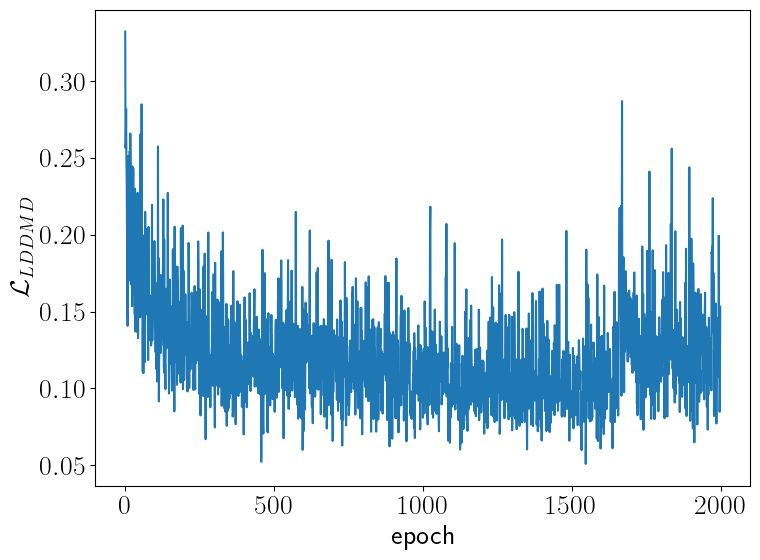

In [13]:
# Plot loss progression
plt.figure(figsize=figsize)
plt.plot(losses)
plt.ylabel(r"$\mathcal{L}_{LDDMD}$")
plt.xlabel("epoch")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "loss.eps"))
plt.show()

In [14]:
# Validate the model
S_net = dynamics_model.forward(i.float(), X.float())

p_net = S_net.detach().cpu()
v_net = regression_model(p_net).detach().cpu().squeeze()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


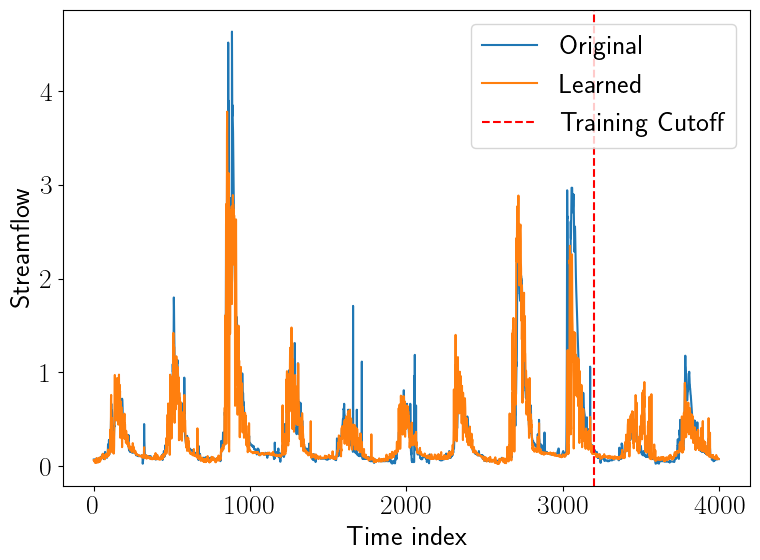

In [15]:
# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='Learned')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Streamflow")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_reconstruction.eps"))
plt.show()

In [16]:
# define NSE metric
def nse(original, predicted):
    
    if original.shape != predicted.shape:
        raise ValueError("Input tensors must have the same shape")
    
    mean_observed = torch.mean(original)
    numerator = torch.sum((original - predicted) ** 2)
    denominator = torch.sum((original - mean_observed) ** 2)

    return 1 - (numerator / denominator)

In [17]:
# Compute NSE metrics
total_nse = nse(v, v_net)

# Training NSE
train_nse = nse(v[:int(i_train[-1].item())+1], v_net[:int(i_train[-1].item())+1])

# Validation NSE
val_nse = nse(v[int(i_train[-1].item())+1:], v_net[int(i_train[-1].item())+1:])

print(f"Total NSE = {total_nse} | NSE on training data = {train_nse} | NSE on validation data = {val_nse}")

Total NSE = 0.7421646241775113 | NSE on training data = 0.7461737227502024 | NSE on validation data = 0.45647417895398024


### Reconstruct using LSTM ###

In [18]:
from neuralhydrology.modelzoo import get_model
from neuralhydrology.utils.config import Config
from torch.optim.lr_scheduler import LambdaLR

In [19]:
config = Config(
    {
    'validate_every': 3, # specify after how many epochs to perform validation
    'validate_n_random_basins': 1, # specify how many random basins to use for validation
    'metrics': ['NSE'], # specify which metrics to calculate during validation (see neuralhydrology.evaluation.metrics)
    # --- Model configuration --------------------------------------------------------------------------
    'model': 'cudalstm', # base model type [lstm, ealstm, cudalstm, embcudalstm, mtslstm]
    'head': 'regression', # prediction head [regression]. Define the head specific parameters below
    'dynamic_inputs': ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14'],  # Feature names
    'target_variables': ['discharge'],
    # ----> Regression settings <----
    'output_activation': 'linear',  
    # ----> General settings <----
    'hidden_size': 20, # Number of cell states of the LSTM
    'initial_forget_bias': 3, # Initial bias value of the forget gate
    'output_dropout': 0.4, # Dropout applied to the output of the LSTM
    # --- Training configuration -----------------------------------------------------------------------
    'optimizer': 'Adam', # specify optimizer [Adam]
    'loss': 'MSE', # specify loss [MSE, NSE, RMSE]
    'learning_rate': {0: 1e-2, 30: 5e-3, 40: 1e-3}, # specify learning rates to use starting at specific epochs (0 is the initial learning rate)
    'batch_size': 256, # Mini-batch size
    'epochs': 50, # Number of training epochs
    'clip_gradient_norm': 1, # If a value, clips the gradients during training to that norm.
    'predict_last_n': 1, # Defines which time steps are used to calculate the loss. Can't be larger than seq_length.
    'seq_length': 365, # Length of the input sequence
    'num_workers': 1, # Number of parallel workers used in the data pipeline
    'log_interval': 5, # Log the training loss every n steps
    'log_tensorboard': False, # If true, writes logging results into tensorboard file
    'log_n_figures': 0., # If a value and greater than 0, logs n random basins as figures during validation
    'save_weights_every': 1, # Save model weights every n epochs
    }
)

In [20]:
class HydrologyDataset(Dataset):
    def __init__(self, x, v, window_size):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.x) - self.window_size + 1

    def __getitem__(self, idx):
        return {'x_d': self.x[idx:idx+self.window_size], 'y': self.v[idx+self.window_size-1]}

# Create the dataset
train_dataset = HydrologyDataset(X_train, v_train, config.seq_length)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_dataset = HydrologyDataset(X, v, config.seq_length)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_5213/1881238587.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)
/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_5213/1881238587.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v = torch.tensor(v, dtype=torch.float32)


In [21]:
model = get_model(config).to(config.device)

In [22]:
# Extract initial learning rate from config dictionary
initial_lr = config.learning_rate[0]  # Get 1e-2 from {0: 1e-2, 30: 5e-3, 40: 1e-3}

# Create optimizer with initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Implement custom learning rate schedule
def lr_lambda(epoch):
    for key in sorted(config.learning_rate.keys(), reverse=True):
        if epoch >= key:
            return config.learning_rate[key] / initial_lr
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
criterion = torch.nn.MSELoss()

for epoch in range(config.epochs):
    model.train()
    for batch in train_loader:  # Use standard batch unpacking
        optimizer.zero_grad()
        
        # NeuralHydrology 1.7 expects dictionary-style inputs
        x_d = batch['x_d'].to(config.device).float()
        y_true = batch['y'][:,None].to(config.device).float()

        # Forward pass (model expects dictionary input in older versions)
        output = model(batch)
        loss = criterion(output['y_hat'][:,-1], y_true)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_gradient_norm)
        optimizer.step()
    
    # Update learning rate according to schedule
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{config.epochs} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]:.5f}')

Epoch 1/50 | Loss: 0.0789 | LR: 0.01000
Epoch 2/50 | Loss: 0.0880 | LR: 0.01000
Epoch 3/50 | Loss: 0.3748 | LR: 0.01000
Epoch 4/50 | Loss: 0.3091 | LR: 0.01000
Epoch 5/50 | Loss: 0.2932 | LR: 0.01000
Epoch 6/50 | Loss: 0.0408 | LR: 0.01000
Epoch 7/50 | Loss: 0.0570 | LR: 0.01000
Epoch 8/50 | Loss: 0.0424 | LR: 0.01000
Epoch 9/50 | Loss: 0.1140 | LR: 0.01000
Epoch 10/50 | Loss: 0.1214 | LR: 0.01000
Epoch 11/50 | Loss: 0.0564 | LR: 0.01000
Epoch 12/50 | Loss: 0.0513 | LR: 0.01000
Epoch 13/50 | Loss: 0.0343 | LR: 0.01000
Epoch 14/50 | Loss: 0.0688 | LR: 0.01000
Epoch 15/50 | Loss: 0.0685 | LR: 0.01000
Epoch 16/50 | Loss: 0.0435 | LR: 0.01000
Epoch 17/50 | Loss: 0.0172 | LR: 0.01000
Epoch 18/50 | Loss: 0.0160 | LR: 0.01000
Epoch 19/50 | Loss: 0.0540 | LR: 0.01000
Epoch 20/50 | Loss: 0.0432 | LR: 0.01000
Epoch 21/50 | Loss: 0.0960 | LR: 0.01000
Epoch 22/50 | Loss: 0.0653 | LR: 0.01000
Epoch 23/50 | Loss: 0.0779 | LR: 0.01000
Epoch 24/50 | Loss: 0.0269 | LR: 0.01000
Epoch 25/50 | Loss: 0.020

In [23]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in loader:
            
            output = model(batch)
            y_pred = output['y_hat'].cpu()
            
            all_preds.append(y_pred[:,-1])
    
    preds = torch.cat(all_preds).squeeze()
    return preds

# For test set (final evaluation)
v_lstm = torch.zeros_like(v)
v_lstm[config.seq_length-1:] = evaluate_model(model, test_loader)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


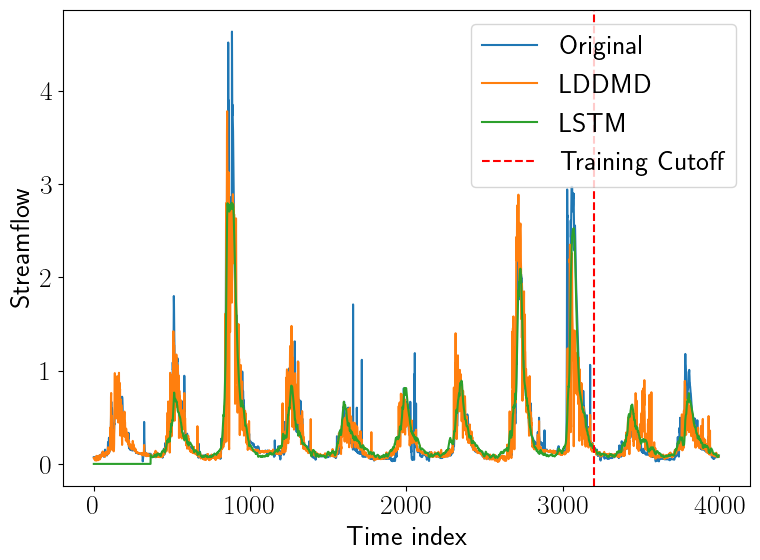

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


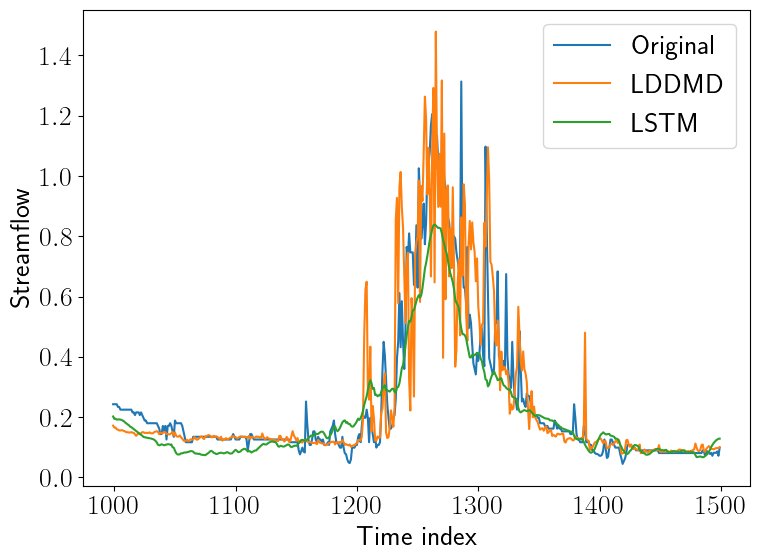

In [26]:
# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='LDDMD')
plt.plot(i, v_lstm, label='LSTM')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Streamflow")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_reconstruction_comparison.eps"))
plt.show()

# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i[999:1500], v[999:1500], label='Original')
plt.plot(i[999:1500], v_net[999:1500], label='LDDMD')
plt.plot(i[999:1500], v_lstm[999:1500], label='LSTM')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Streamflow")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_reconstruction_comparison_zoom.eps"))
plt.show()

In [25]:
# Compute NSE metrics
total_nse = nse(v[config.seq_length-1:], v_lstm[config.seq_length-1:])

# Training NSE
train_nse = nse(v[config.seq_length-1:int(i_train[-1].item())+1], v_lstm[config.seq_length-1:int(i_train[-1].item())+1])

# Validation NSE
val_nse = nse(v[int(i_train[-1].item())+1:], v_lstm[int(i_train[-1].item())+1:])

print(f"Total NSE = {total_nse} | NSE on training data = {train_nse} | NSE on validation data = {val_nse}")

Total NSE = 0.8872278474938077 | NSE on training data = 0.8902260631111878 | NSE on validation data = 0.7155609111050224
